# Performance Skyline and Anomaly Detection
The perfomance skyline of a trace contains only the events in the critical path

In [1]:
#%matplotlib widget
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    %autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from perfSky import Visualizer as pt


In [2]:
import importlib

In [3]:
print(os.getcwd())


/Users/andreamaldonado/git_tree/perfSky/notebooks


In [4]:
#CASE_ID = "Auftragsnr.-Artikelnr."
CASE_ID = 'case'
ACTIVITY_ID = 'common_act'

#df = pd.read_csv("../data/Auswertung_März_merged_Auftragsnr.-Artikelnr.csv", sep=";", dtype='unicode')
#appended = pd.read_csv("../../perfsky/data/clustered_agg_edit_75_daily.csv", sep=";", dtype='unicode')
appended = pd.read_csv("../../perfsky/data/clustered_dbscan_edit_eps80_ms10_daily.csv", sep=";", dtype='unicode')

appended['activity_b'] = appended['activity']
appended['activity'] = appended[ACTIVITY_ID]

print('Data set contains:')
print('- ',len(appended),'events')
print('- ',len(appended['case'].unique()),'cases')
print('- ',len(appended['activity'].unique()),'activities')

avg_activities = appended[CASE_ID].value_counts().mean()
print("- Avg. events per case: ", avg_activities)

Data set contains:
-  61864 events
-  50 cases
-  49 activities
- Avg. events per case:  1237.28


In [5]:
#csv_list = []
#appended = pd.DataFrame()
#LUIGI_LOG_PATH = '../data'
#for filename in os.listdir(LUIGI_LOG_PATH):
#    if filename.endswith('.csv') and filename.startswith('d'):#Use startswith('') to choose which csvs
#        log_path = LUIGI_LOG_PATH+'/'+filename
#        csv_list.append(filename)
#        print('Preprocessing... ',log_path)
#        df = pd.read_csv(log_path, index_col=False)
#        appended = appended.append(df)

#appended_df
#csv_list.sort()
#print(csv_list)

#filename = os.path.splitext(csv_list[0])[0]

#appended_df.to_datetime(start_time, format="%Y-%m-%d:%H:%M:%S").sort_values()
#appended['start_time'] = pd.to_datetime(appended['start_time'], format="%Y-%m-%d %H:%M:%S").sort_values()
#appended['end_time'] = pd.to_datetime(appended['end_time'], format="%Y-%m-%d %H:%M:%S").sort_values()
#appended = appended.sort_values(by=['start_time'], ascending=True)
#appended['case'] = appended.apply(lambda row: str(row['case']), axis=1)
#print('contains',len(appended), 'events/points')
appended.head()

case  \
0  daily.2019-09-24_05-05-02   
1  daily.2019-09-24_05-05-02   
2  daily.2019-09-24_05-05-02   
3  daily.2019-09-24_05-05-02   
4  daily.2019-09-24_05-05-02   

                                            activity           start_time  \
0  DumpTask(sql_filename=regular_urls)(kvs=None)(...  2019-09-24 05:20:10   
1  DumpTask(sql_filename=reprocess_urls)(kvs=None...  2019-09-24 05:20:10   
2  DumpTask(sql_filename=daily_urls)(kvs=None)(ch...  2019-09-24 05:20:10   
3                                                C_0  2019-09-24 05:20:10   
4                                                C_0  2019-09-24 05:20:10   

              end_time cluster_id  \
0  2019-09-24 05:40:21         -1   
1  2019-09-24 05:21:03         -1   
2  2019-09-24 05:21:32         -1   
3  2019-09-24 05:32:45          0   
4  2019-09-24 05:43:43          0   

                                          common_act  \
0  DumpTask(sql_filename=regular_urls)(kvs=None)(...   
1  DumpTask(sql_filename=reprocess_urls)(kvs=None...   
2  DumpTask(sql_filename=daily_urls)(kvs=None)(ch...   
3                                                C_0   
4                                                C_0   

                                          activity_b  
0  DumpTask(sql_filename=regular_urls)(kvs=None)(...  
1  DumpTask(sql_filename=reprocess_urls)(kvs=None...  
2  DumpTask(sql_filename=daily_urls)(kvs=None)(ch...  
3                                     ProxySetupTask  
4                                      CrawlFeedTask

In [6]:
sample = appended[appended['case'].isin(appended['case'].unique()[:3])]
print(len(sample))
sample.head()

3236


case  \
0  daily.2019-09-24_05-05-02   
1  daily.2019-09-24_05-05-02   
2  daily.2019-09-24_05-05-02   
3  daily.2019-09-24_05-05-02   
4  daily.2019-09-24_05-05-02   

                                            activity           start_time  \
0  DumpTask(sql_filename=regular_urls)(kvs=None)(...  2019-09-24 05:20:10   
1  DumpTask(sql_filename=reprocess_urls)(kvs=None...  2019-09-24 05:20:10   
2  DumpTask(sql_filename=daily_urls)(kvs=None)(ch...  2019-09-24 05:20:10   
3                                                C_0  2019-09-24 05:20:10   
4                                                C_0  2019-09-24 05:20:10   

              end_time cluster_id  \
0  2019-09-24 05:40:21         -1   
1  2019-09-24 05:21:03         -1   
2  2019-09-24 05:21:32         -1   
3  2019-09-24 05:32:45          0   
4  2019-09-24 05:43:43          0   

                                          common_act  \
0  DumpTask(sql_filename=regular_urls)(kvs=None)(...   
1  DumpTask(sql_filename=reprocess_urls)(kvs=None...   
2  DumpTask(sql_filename=daily_urls)(kvs=None)(ch...   
3                                                C_0   
4                                                C_0   

                                          activity_b  
0  DumpTask(sql_filename=regular_urls)(kvs=None)(...  
1  DumpTask(sql_filename=reprocess_urls)(kvs=None...  
2  DumpTask(sql_filename=daily_urls)(kvs=None)(ch...  
3                                     ProxySetupTask  
4                                      CrawlFeedTask

In [7]:
import os
import sys
module_path = os.path.abspath(os.path.join('../perfSky'))
if module_path not in sys.path:
    sys.path.append(module_path)

from Skyline import get_relative_timestamps

In [8]:
vis = pt.Vis()
excluding = get_relative_timestamps(sample, exclude_tasks=['AllTasks']) #'AllTasks' is one entry per log with its overall duration

print('Data set contains:')
print('- ',len(excluding),'events')
print('- ',len(excluding['case'].unique()),'cases')
print('- ',len(excluding['activity'].unique()),'activities')

excluding.head()

Grouped: 3236 columns ['case', 'activity', 'start_time', 'end_time', 'cluster_id', 'common_act', 'activity_b', 'zero_point']
Merged relatived: 3240 columns ['case', 'activity', 'start_time', 'end_time', 'cluster_id_x', 'common_act_x', 'activity_b_x', 'zero_point', 'cluster_id_y', 'common_act_y', 'activity_b_y']
Data set contains:
-  3240 events
-  3 cases
-  49 activities


case  \
4  daily.2019-07-21_09-53-01   
5  daily.2019-07-21_09-53-01   
6  daily.2019-07-21_09-53-01   
7  daily.2019-07-21_09-53-01   
8  daily.2019-07-21_09-53-01   

                                            activity rel_start  rel_end  \
4  DumpTask(sql_filename=daily_urls)(kvs=None)(ch...   0:00:00  0:01:20   
5  DumpTask(sql_filename=regular_urls)(kvs=None)(...   0:00:00  0:25:25   
6  DumpTask(sql_filename=other_urls)(kvs=None)(ch...   0:00:00  0:00:52   
7                                                C_0   0:00:00  0:13:07   
8                                                C_0   0:00:00  0:18:07   

   num_start  num_end           start_time             end_time  
4        0.0     80.0  2019-07-21 10:05:16  2019-07-21 10:06:36  
5        0.0   1525.0  2019-07-21 10:05:16  2019-07-21 10:30:41  
6        0.0     52.0  2019-07-21 10:05:16  2019-07-21 10:06:08  
7        0.0    787.0  2019-07-21 10:05:16  2019-07-21 10:18:23  
8        0.0   1087.0  2019-07-21 10:05:16  2019-07-21 10:23:23

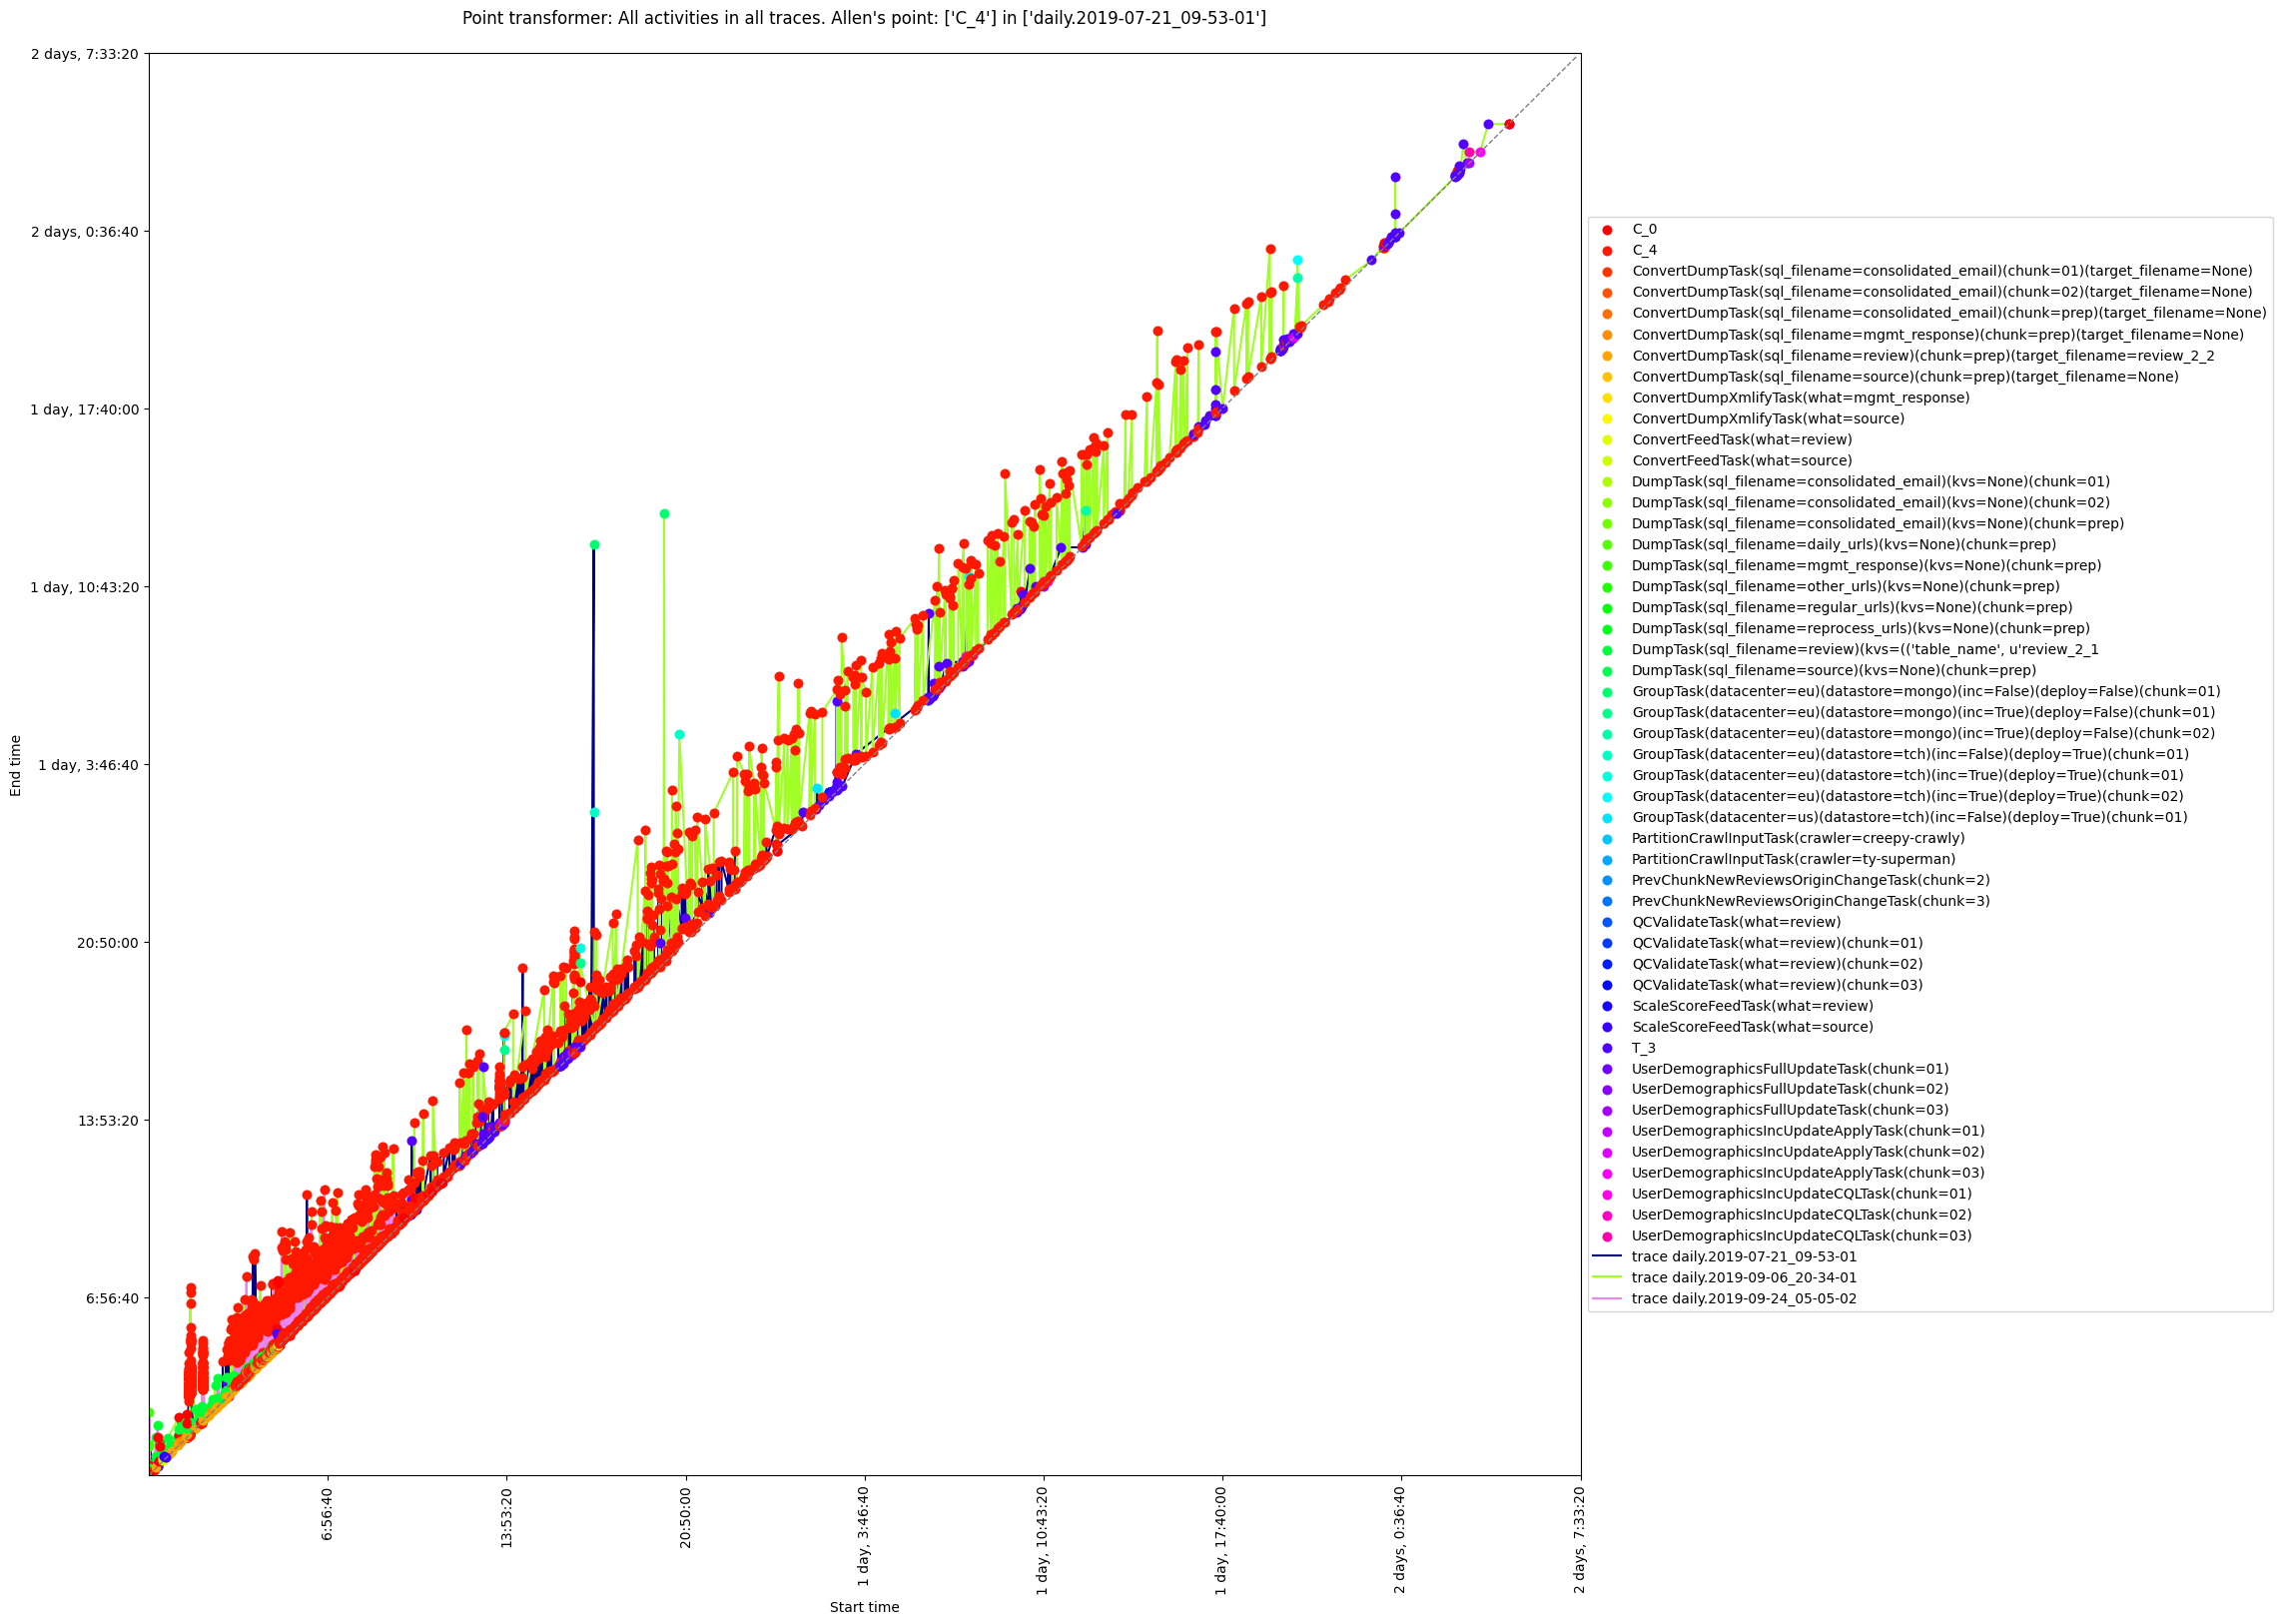

In [38]:
vis.plot_traces(excluding, show_plot=None)

<AxesSubplot:ylabel='Frequency'>

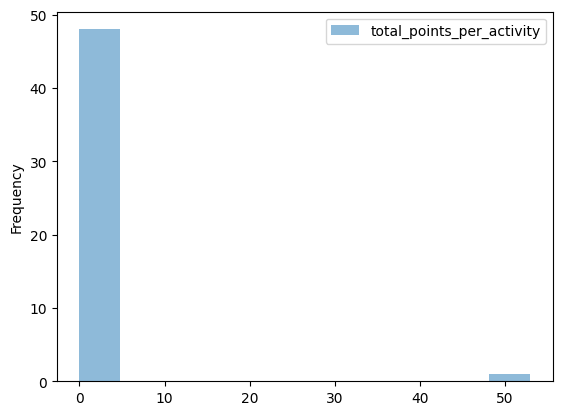

In [39]:
all_by_activity = excluding.groupby('activity').size().reset_index(name='total_points_per_activity').sort_values(by=['total_points_per_activity'], ascending=False)
all_by_activity['total_points_per_activity']=all_by_activity.apply(lambda row: round(row['total_points_per_activity']/50), axis=1)
all_by_activity.plot.hist(bins=11, alpha=0.5)

Frequency of activities having more than 1 event per activity  4 

                                             activity  \
1                                                 C_4   
39                                                T_3   
6   ConvertDumpTask(sql_filename=review)(chunk=pre...   
20  DumpTask(sql_filename=review)(kvs=(('table_nam...   

    total_points_per_activity  
1                          53  
39                          4  
6                           2  
20                          2  


<AxesSubplot:ylabel='Frequency'>

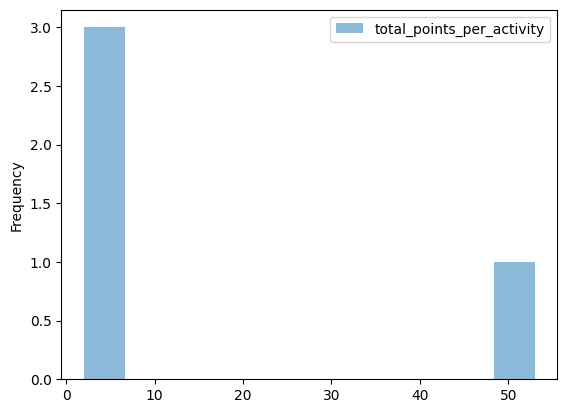

In [40]:
print('Frequency of activities having more than 1 event per activity ',len(all_by_activity[all_by_activity['total_points_per_activity']>1]), '\n')
print(all_by_activity[all_by_activity['total_points_per_activity']>1])
all_by_activity[all_by_activity['total_points_per_activity']>1].plot.hist(bins=11, alpha=0.5)

## Compute average trace
Average skyline contains a point per activity, depicting the average start and average end timestamps of it.

In [41]:
average_trace_activities = vis.get_data_selection_avgtrace(vis.get_relative_timestamps(excluding)).sort_values(by=['num_start'])
print('Average trace over activities has',len(average_trace_activities),'events')
average_trace_activities.head()
#print('AllTasks' in average_trace_activities)

Grouped: 3240 columns ['case', 'activity', 'rel_start', 'rel_end', 'num_start', 'num_end', 'start_time', 'end_time', 'zero_point']
Merged relatived: 3264 columns ['case', 'activity', 'rel_start_x', 'rel_end_x', 'num_start_x', 'num_end_x', 'start_time', 'end_time', 'zero_point', 'rel_start_y', 'rel_end_y', 'num_start_y', 'num_end_y']
Average trace over activities has 49 events


activity average_start  \
0  DumpTask(sql_filename=daily_urls)(kvs=None)(ch...      00:00:00   
1  DumpTask(sql_filename=regular_urls)(kvs=None)(...      00:00:00   
4  DumpTask(sql_filename=reprocess_urls)(kvs=None...      00:00:17   
3  DumpTask(sql_filename=other_urls)(kvs=None)(ch...      00:00:40   
5  DumpTask(sql_filename=mgmt_response)(kvs=None)...      00:01:17   

  average_end  num_start      num_end          case  std_num_end  
0    00:01:17   0.000000    77.333333  Average Case          0.0  
1    00:23:55   0.000000  1435.000000  Average Case          0.0  
4    00:01:06  17.333333    66.666667  Average Case          0.0  
3    00:01:26  40.000000    86.666667  Average Case          0.0  
5    01:36:18  77.333333  5778.666667  Average Case          0.0

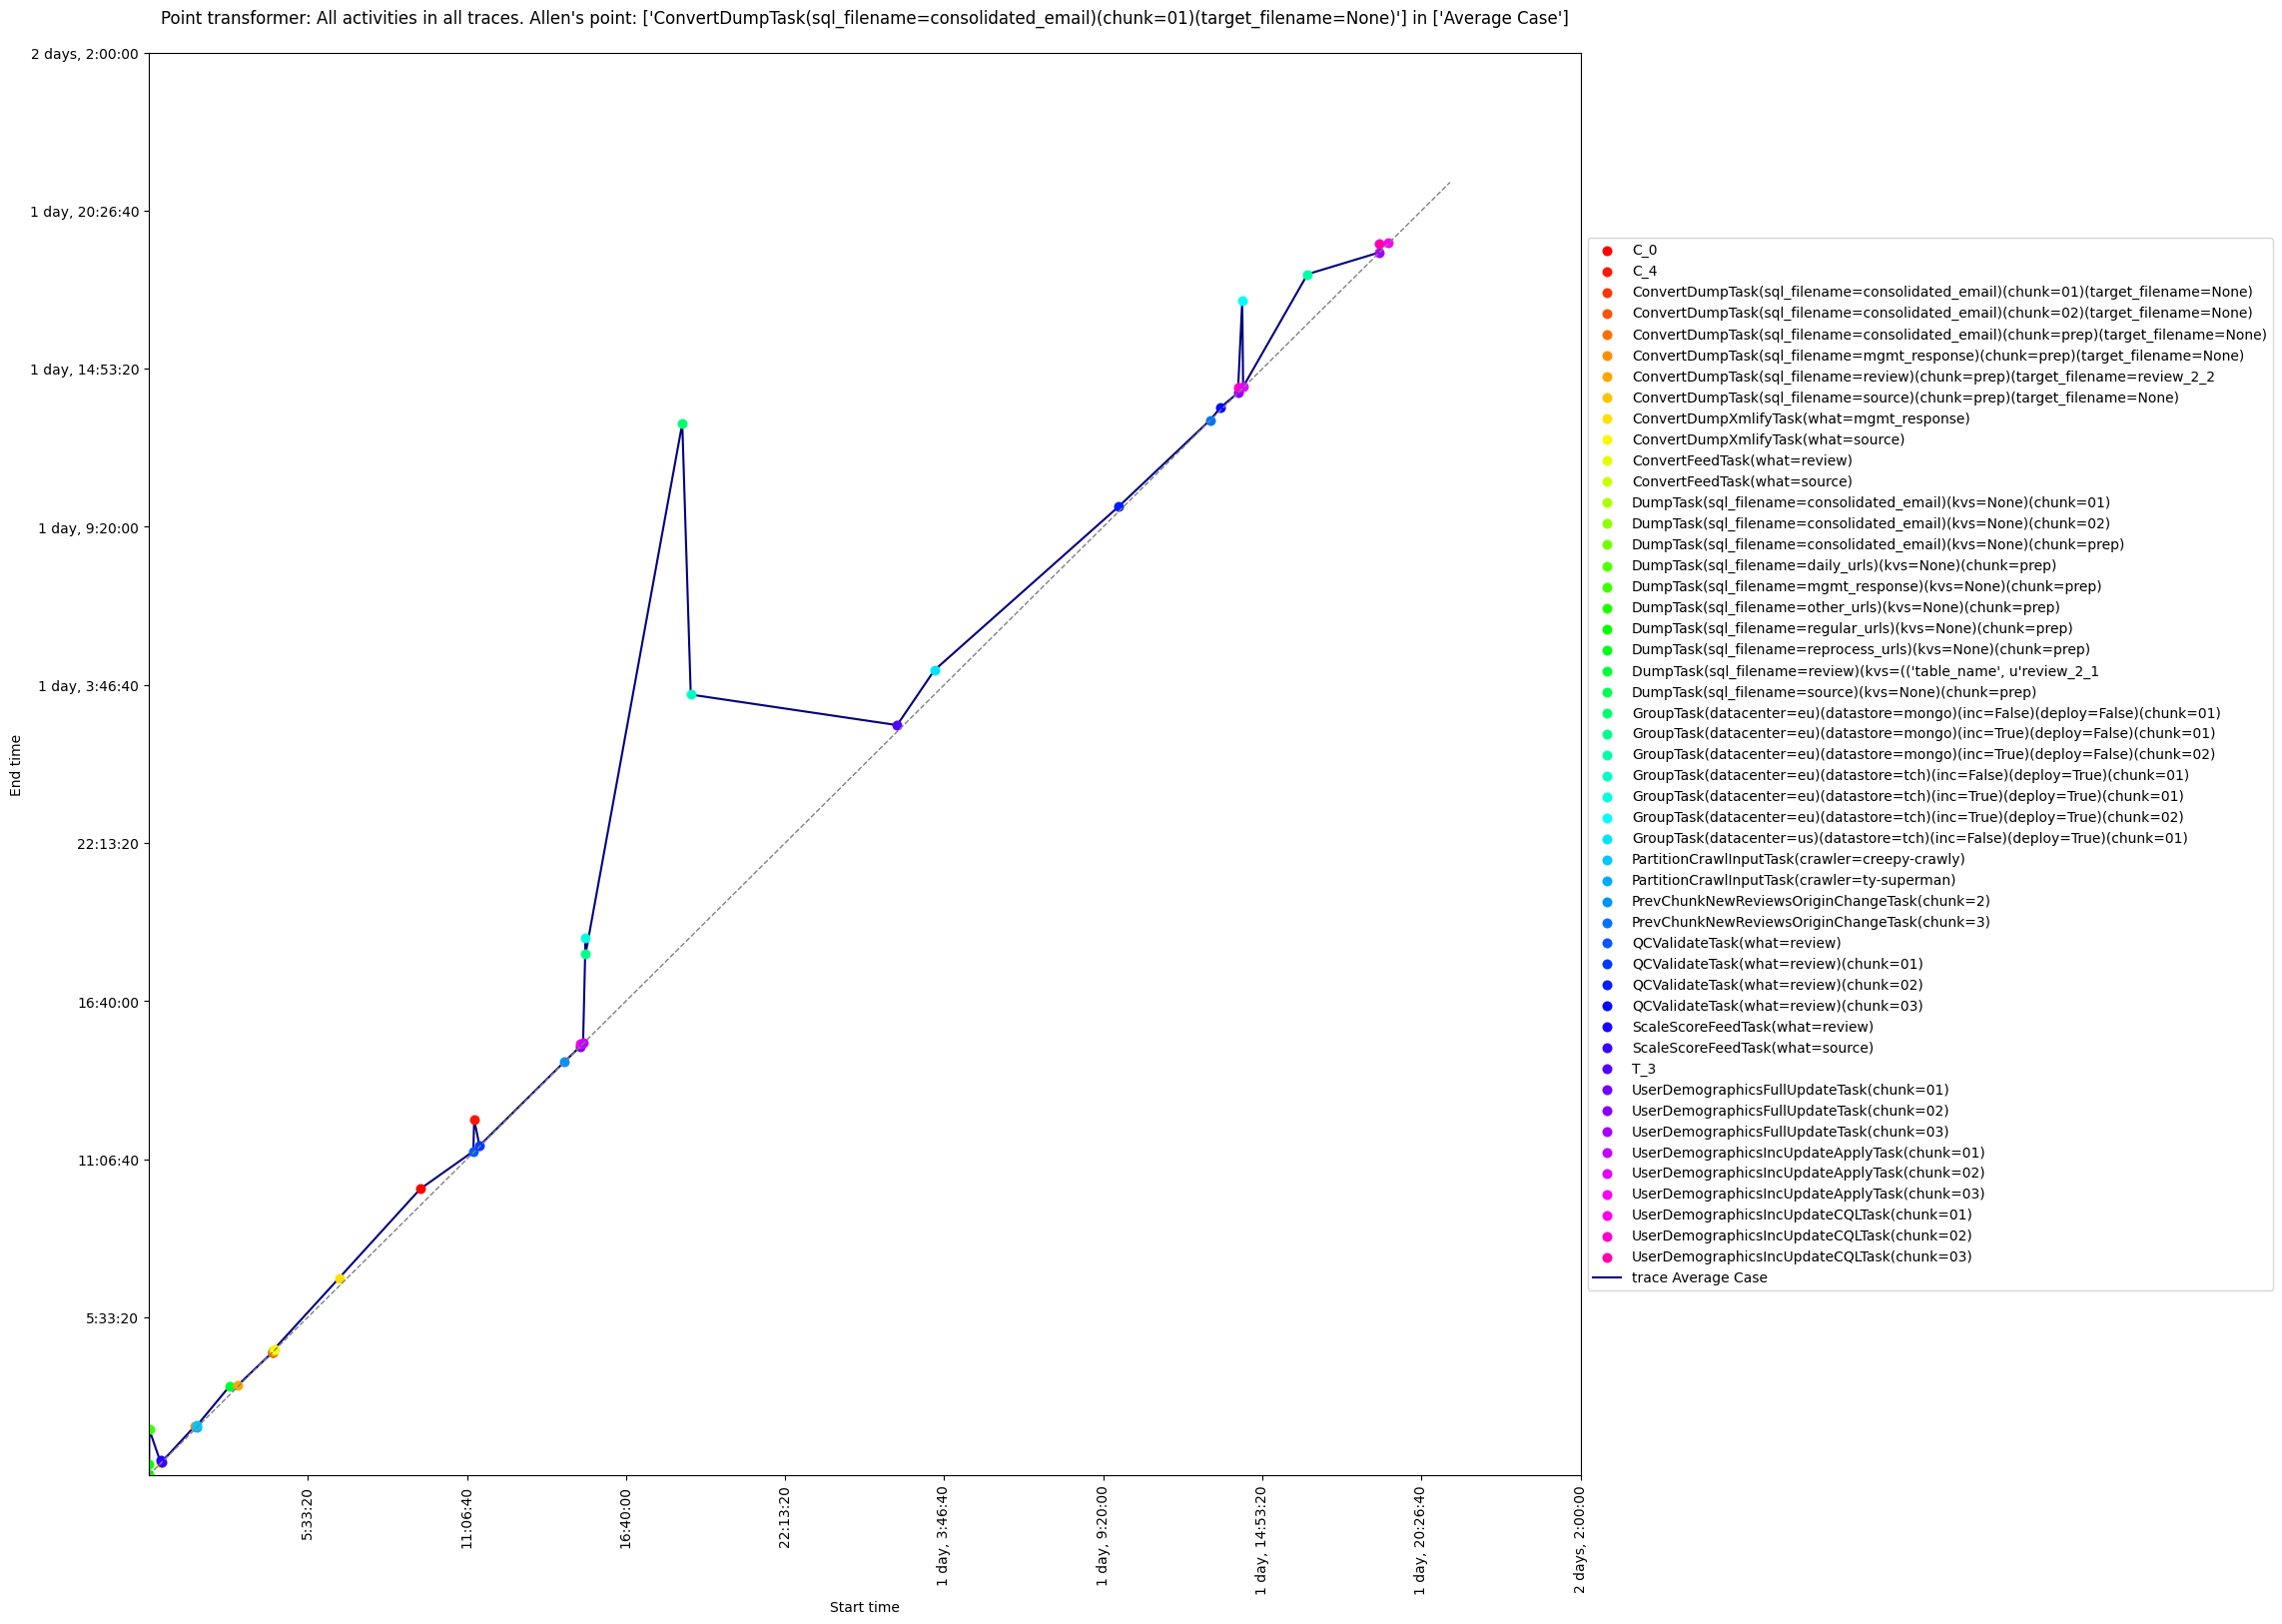

In [42]:
vis.plot_traces(average_trace_activities, show_plot=None)


In case only one subset of activities from the whole data set should be investigated

NOTE: This is specific to the 'daily.2019-0.csv' dataset

pd.set_option('display.max_colwidth', -1)

index_used=[[117,120]]
#Indexes used for produced 'graphs/avgActSlideSplit/' (to have an avg of 400 points per visualization)
#index_used=[[0,31],[21,51],[41,71],[61,91],[81,111],[87,117],
#            [101,119],[117,120],[118,122],[120,126],[123,156],
#            [139,170],[141,171],[170,178],[175,216],[206,246],[216,256]]

for indexes in index_used:
    #subset = appended[appended['activity'].str.startswith('ExtractTask') & appended['case']]
    subset = appended[appended['activity'].isin(average_trace_activities['activity'][indexes[0]:indexes[1]])]
    #subset = appended[appended['activity'].isin(average_trace_activities[indexes[0]:indexes[1]]) & ~appended['activity'].str.startswith('ExtractTask(crawler=creepy-crawly)(chunk')]

    output_prefix = LUIGI_LOG_PATH+'graphs/avgActSlideSplit/'+filename+'All_'+str(indexes[0])+'_'+str(indexes[1])+'act_'+str(len(subset))+'pts'
    #print(output_prefix)

output_prefix = LUIGI_LOG_PATH+'graphs/'+filename
print(output_prefix)
#snippet = vis.plot_point_transformer_selection(subset, output_prefix)
subset = vis.get_relative_timestamps(subset, ['AllTasks'])
print('There are ', len(subset),'subset entries in the activities interval:',index_used[0])

subset.head()


In [43]:
subset = excluding.copy() #Comment this out to only examine a certain snippet of the subset from above

## Compute Performance Skyline

In [44]:
skyline_points = vis.get_skyline_points(subset)
representative = skyline_points[['case','activity']].drop_duplicates()

print(len(subset),' points in total distributed among', len(subset['case'].unique()), 'cases\n\nInfo about the skyline:')
print('- ',len(skyline_points),'/',len(subset),'=', round(len(skyline_points)/len(subset)*100,2), '% events are part of a skyline')
print('- ',len(skyline_points['activity'].unique()),'/',len(subset['activity'].unique()),'=', round(len(skyline_points['activity'].unique())/len(subset['activity'].unique())*100,2), 'activities are part of a skyline.')
print('- ',len(representative),'/',len(skyline_points),'=', round(len(representative)/len(skyline_points)*100,2), '% unique activities on the skylines.') 
print("   'Unique' meaning there are no two points with the same 'activity' on the skyline of the same trace. ")

skyline_points.head()

3240  points in total distributed among 3 cases

Info about the skyline:
-  159 / 3240 = 4.91 % events are part of a skyline
-  15 / 49 = 30.61 activities are part of a skyline.
-  29 / 159 = 18.24 % unique activities on the skylines.
   'Unique' meaning there are no two points with the same 'activity' on the skyline of the same trace. 


num_start  num_end                                           activity  \
0        0.0     80.0  DumpTask(sql_filename=daily_urls)(kvs=None)(ch...   
1        0.0   1525.0  DumpTask(sql_filename=regular_urls)(kvs=None)(...   
2        0.0   1525.0  DumpTask(sql_filename=other_urls)(kvs=None)(ch...   
3        0.0   1525.0                                                C_0   
4       80.0   4085.0  DumpTask(sql_filename=mgmt_response)(kvs=None)...   

                        case  
0  daily.2019-07-21_09-53-01  
1  daily.2019-07-21_09-53-01  
2  daily.2019-07-21_09-53-01  
3  daily.2019-07-21_09-53-01  
4  daily.2019-07-21_09-53-01

## Stats by Case

In [45]:
all_by_case = subset.groupby('case').size().reset_index(name='total_points_in_case').sort_values(by=['total_points_in_case'], ascending=False)
skyline_by_case = skyline_points.groupby('case').size().reset_index(name='skyline_points_in_case').sort_values(by=['skyline_points_in_case'], ascending=False)
r_by_case = representative.groupby('case').size().reset_index(name='unique_skyline_activities_in_case').sort_values(by=['unique_skyline_activities_in_case'], ascending=False)
by_case = r_by_case.merge(skyline_by_case, on='case', how='inner')
#all_by_case.plot.hist(bins=8, alpha=0.5)

all_by_activity = subset.groupby('activity').size().reset_index(name='total_points_per_activity').sort_values(by=['total_points_per_activity'], ascending=False)
all_by_activity['total_points_per_activity']=all_by_activity.apply(lambda row: round(row['total_points_per_activity']/50), axis=1)

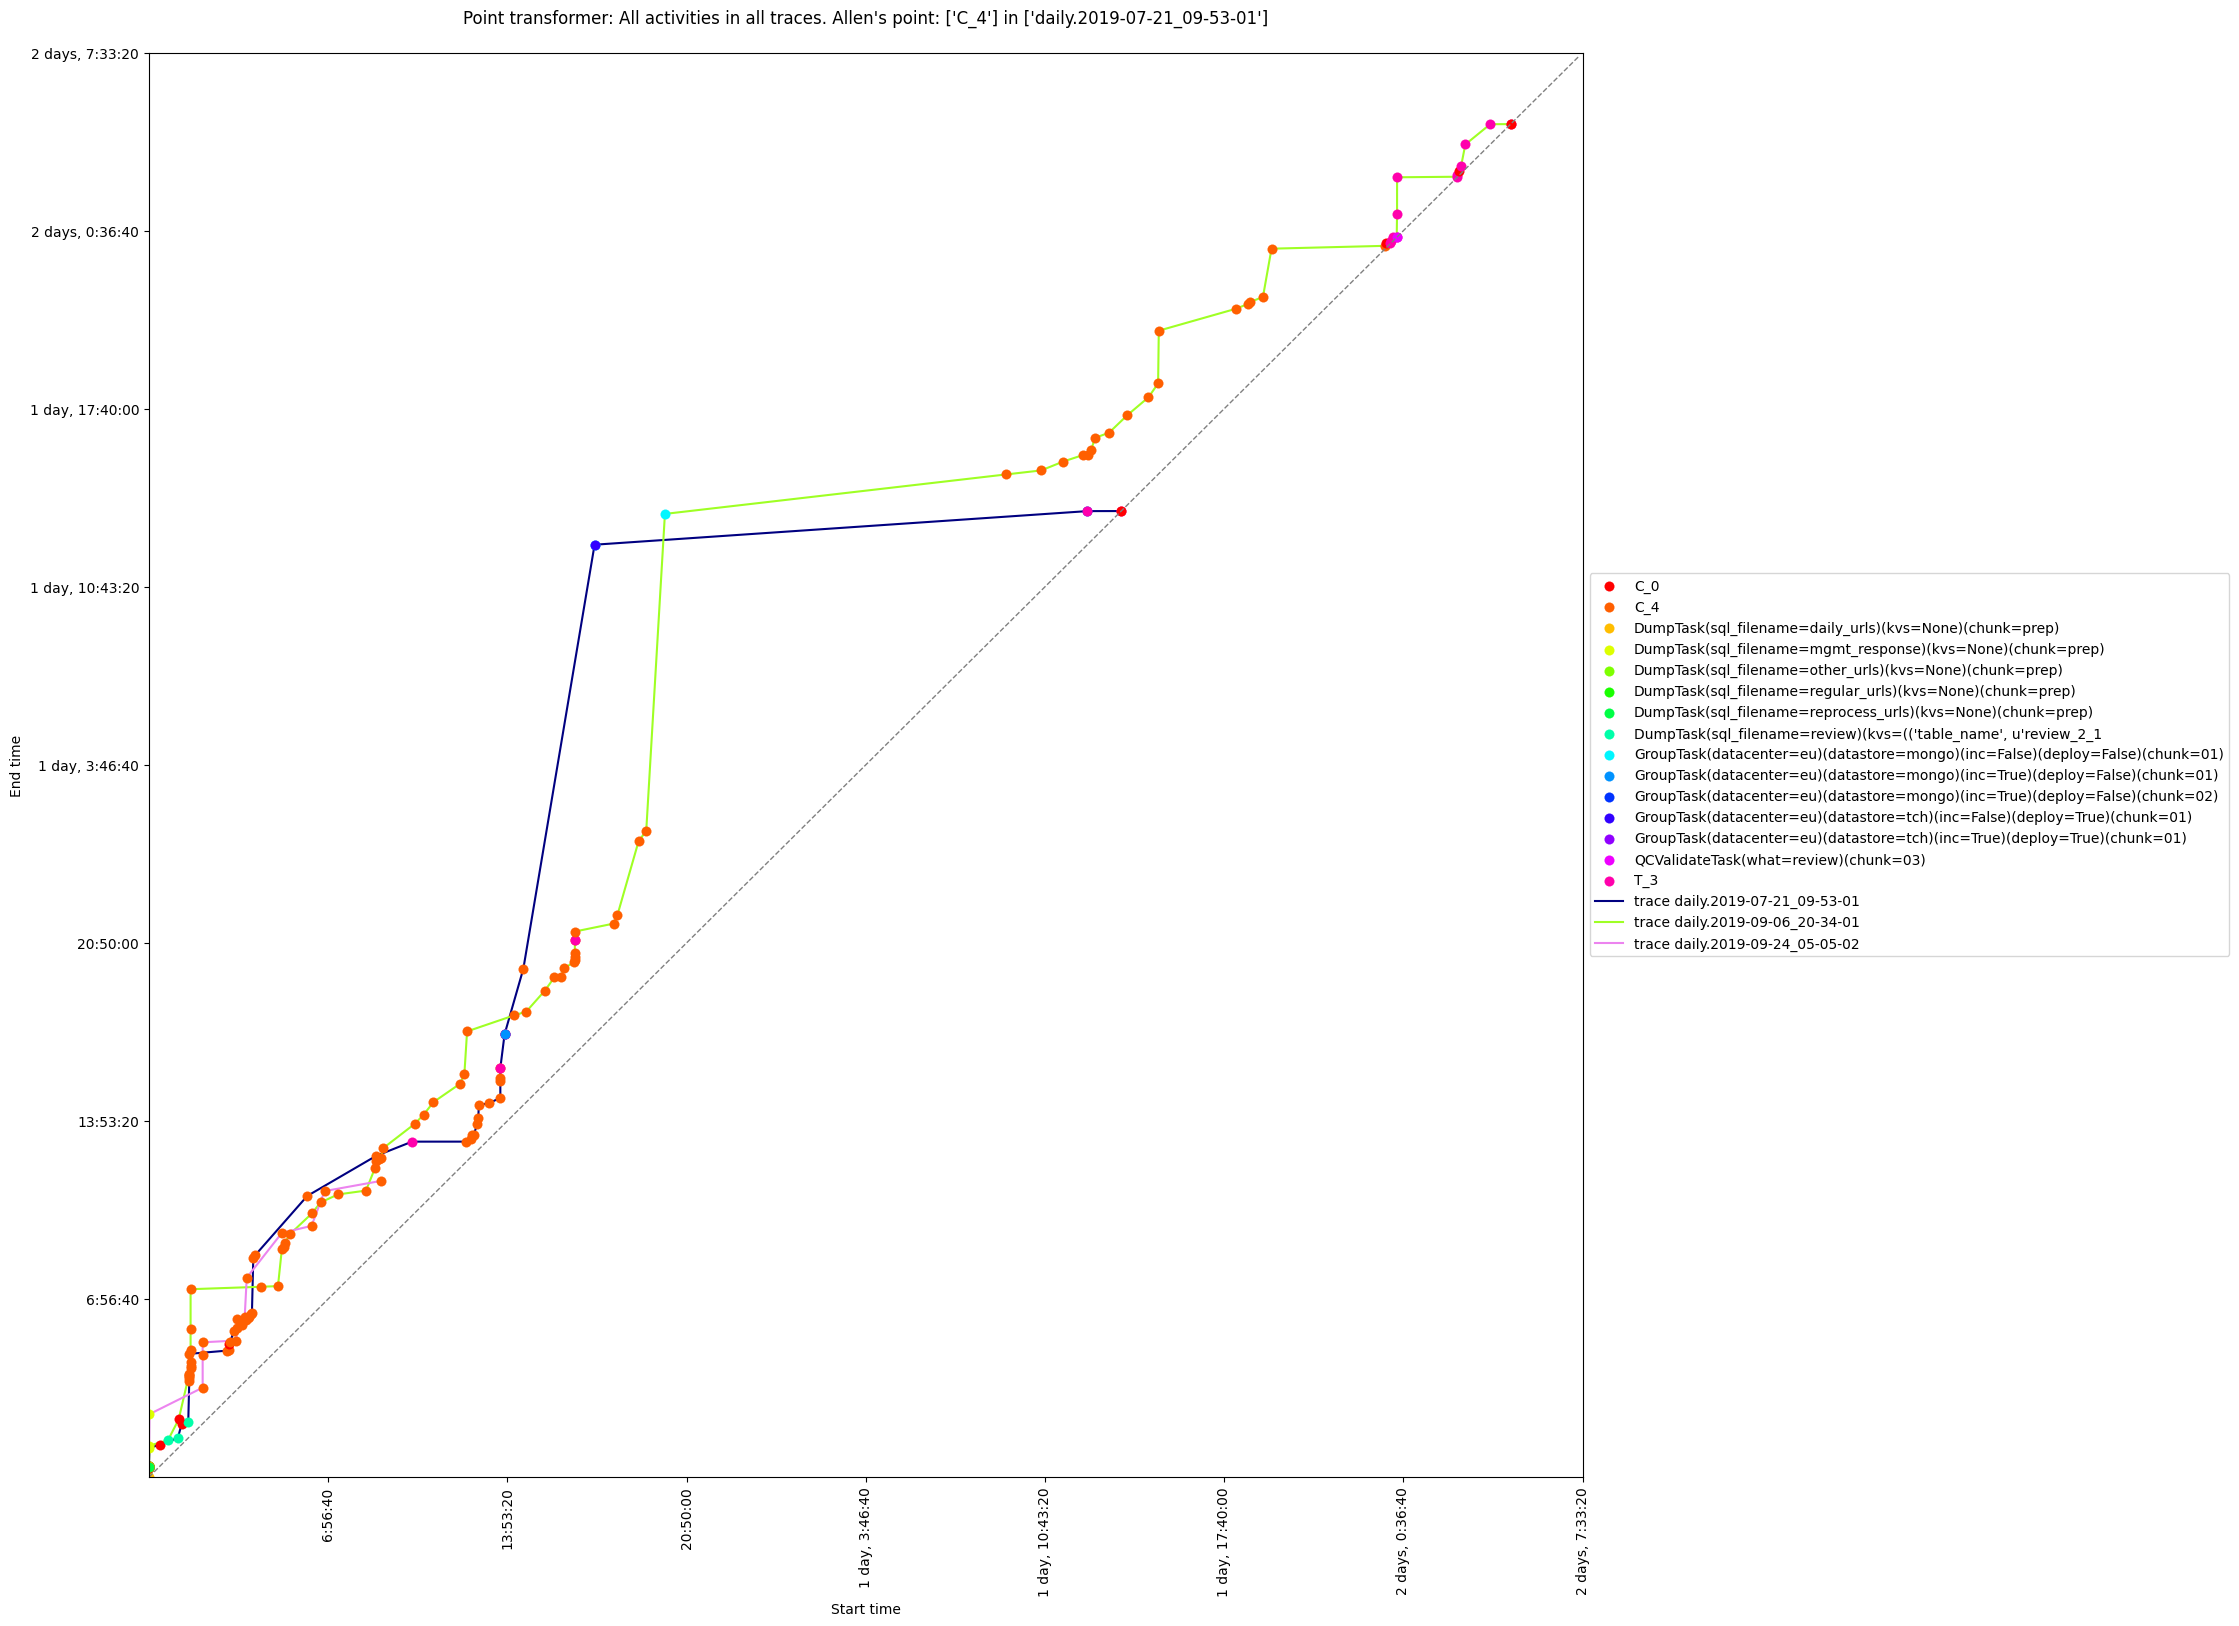

In [46]:
vis.plot_traces(skyline_points, show_plot=False)

In [47]:
merged_by_case = by_case.merge(all_by_case)[['case','total_points_in_case','skyline_points_in_case', 'unique_skyline_activities_in_case']].sort_values(by=['total_points_in_case'], ascending=False)
merged_by_case['skyline_percentage'] = merged_by_case.apply(lambda row: round(row['skyline_points_in_case']/row['total_points_in_case']*100,2), axis=1)
merged_by_case['unique_percentage'] = merged_by_case.apply(lambda row: round(row['unique_skyline_activities_in_case']/row['skyline_points_in_case']*100,2), axis=1)
print('Expectation/Averages: \ntotal_points_in_case:\t\t\t',round(merged_by_case['total_points_in_case'].mean(),2))
print('skyline_points_in_case:\t\t\t',round(merged_by_case['skyline_points_in_case'].mean(),2))
print('unique_skyline_activities_in_case:\t',round(merged_by_case['unique_skyline_activities_in_case'].mean(),2))
print('skyline_percentage:\t\t\t',round(merged_by_case['skyline_percentage'].mean(),2))
print('unique_percentage:\t\t\t',round(merged_by_case['unique_percentage'].mean(),2))
merged_by_case.head()

Expectation/Averages: 
total_points_in_case:			 1080.0
skyline_points_in_case:			 53.0
unique_skyline_activities_in_case:	 9.67
skyline_percentage:			 4.57
unique_percentage:			 22.87


case  total_points_in_case  skyline_points_in_case  \
0  daily.2019-07-21_09-53-01                  1249                      55   
1  daily.2019-09-06_20-34-01                  1249                      86   
2  daily.2019-09-24_05-05-02                   742                      18   

   unique_skyline_activities_in_case  skyline_percentage  unique_percentage  
0                                 13                4.40              23.64  
1                                 10                6.89              11.63  
2                                  6                2.43              33.33

# Anomaly Detection

In [48]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np 
from matplotlib.ticker import FuncFormatter


In [49]:
def plot_star_from_point(s_plot, reference_points, body_points, anomaly_name=None):
    missing_label = ['present','missing']
    #unique_trace = data_selection['case'].unique().tolist()
    colorlist = ["green", "red"]
    by_missing = dict(zip(missing_label, colorlist)) 

    axis = s_plot.get_axes()
    average_skyline = reference_points
    
    if anomaly_name == 'skyline_points_in_case':
            average_skyline = vis.get_skyline_points(reference_points)
  
    if anomaly_name == 'activity_set':
        average_skyline = body_points
        body_points = reference_points

    axis[0].plot(body_points['num_start'],body_points['num_end'],color='orange',linewidth=1.5)    
    axis[0].plot(average_skyline['num_start'],average_skyline['num_end'],color='green',linewidth=1.5)
        
    missing = average_skyline[~average_skyline['activity'].isin(body_points['activity'].unique())]
    
    for index, reference_point in missing.iterrows(): 
        x = []
        y = []
        x.append(reference_point['num_start'])
        y.append(reference_point['num_end'])
        axis[0].plot(x,y, label = 'missing', marker='s', color='red', markersize=8)
     

    if anomaly_name in ['skyline_points_in_case','activity_set']:
        for index, reference_point in reference_points.iterrows(): 
            for jndex, point in body_points[body_points['activity']==reference_point['activity']].iterrows():
                x = []
                y = []
                x.append(reference_point['num_start'])
                x.append(point['num_start'])
                y.append(reference_point['num_end'])
                y.append(point['num_end'])
                axis[0].plot(x,y,color='black', linewidth=0.5)
            
        

    handles, labels = axis[0].get_legend_handles_labels()
    expectation = mlines.Line2D([], [], color='green', marker='_', markersize=15, label='Average Trace')
    anomaly = mlines.Line2D([], [], color='orange', marker='_',markersize=15, label='Anomaly Trace')
    missing_legend = mlines.Line2D([], [], color='red', marker='s',markersize=10, label='missing activities')
    
    handles_all = list(dict.fromkeys(handles))
    axis[0].legend(handles=[expectation, anomaly, missing_legend])
    
    return s_plot

    
    present_legend = mlines.Line2D([], [], color='green', marker='s',markersize=10, label='present activities')
    present = reference_points[reference_points['activity'].isin(body_points['activity'].unique())]
    for index, reference_point in present.iterrows(): 
        x = []
        y = []
        x.append(reference_point['num_start'])
        y.append(reference_point['num_end'])
        axis[0].plot(x,y, label='present', marker='s', color='green')

    mutual = reference_point[reference_point['activity']==body_points['activity']]

    
    #skyline_plot.show()
    return s_plot

#plot_star_from_point(some_plot,average_trace_activities,anomaly_suspects, anomaly_name='skyline_points_in_case')

In [50]:
def millions(x, pos):
    'The two args are the value and tick position'
    return '%11.1i'% (x)+'%' 

def threshold_histogram(input_data, bucket=None, anomaly_name=None, in_percentage=None, x_axis_name=None):
    plt.rcdefaults()
    fig, ax = plt.subplots(figsize=(20, 20))

    input_data= input_data.sort_values(by=anomaly_name, ascending=False)
    # Example data
    y_values = input_data[bucket]
    y_pos = np.arange(len(y_values))
    x_values = input_data[anomaly_name]
    error = 0

    formatter = FuncFormatter(millions)

    ax.barh(y_pos, x_values, xerr=error, align='center')
    if in_percentage:
        ax.xaxis.set_major_formatter(formatter)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(y_values)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel(x_axis_name)
    ax.set_title(x_axis_name+' per '+bucket+' id')
    return plt

#threshold_histogram(merged_by_case, bucket='case', anomaly_name='skyline_percentage',in_percentage=1, x_axis_name='Percentage of events in skyline')

In [51]:
def evaluate_condition(condition, content, anomaly_name=None, bucket=None):
#    if bucket == 'activity': 
#        anomaly_results = content
    anomaly_results = content[(content[anomaly_name]<condition['lower_bound']) | (content[anomaly_name]>condition['upper_bound'])]
    return len(anomaly_results), anomaly_results[bucket].unique()
    
def get_anomaly_results(input_data, std_factors=range(10), anomaly_name=None, bucket=None):
    
    anomaly_condition = pd.DataFrame()
    anomaly_condition['factor_std'] = std_factors
    if bucket == 'activity': 
        anomaly_condition['average']=input_data.mean(axis=1).apply(math.floor)
        anomaly_condition['std']=input_data.std(axis=1)
    anomaly_condition['average'] =round(input_data[anomaly_name].mean(),2)
    anomaly_condition['std'] =round(input_data[anomaly_name].std(),2)
    anomaly_condition['lower_bound'] = anomaly_condition.apply(lambda row: round(max(row['average']-row['factor_std']*row['std'],0),2), axis=1)
    anomaly_condition['upper_bound'] = anomaly_condition.apply(lambda row: round(max(row['average']+row['factor_std']*row['std'],0),2), axis=1)
    anomaly_condition[['number_of_anomalies','anomaly_traces']] = anomaly_condition.apply(lambda row: evaluate_condition(row, input_data, anomaly_name=anomaly_name, bucket=bucket), result_type='expand', axis=1)

    return anomaly_condition

#get_anomaly_results(merged_by_case, std_factors=[ 1.5**x for x in range(16)], anomaly_name='skyline_percentage', bucket='case').head()

### Anomaly of number of points in trace: 

#### Causes for this anomaly:  
* More activities than expected being restarted. (for upper bound)
* A trace being unexpectedly interrupted. (for lower bound)
* A log being incomplete. (for lower bound)

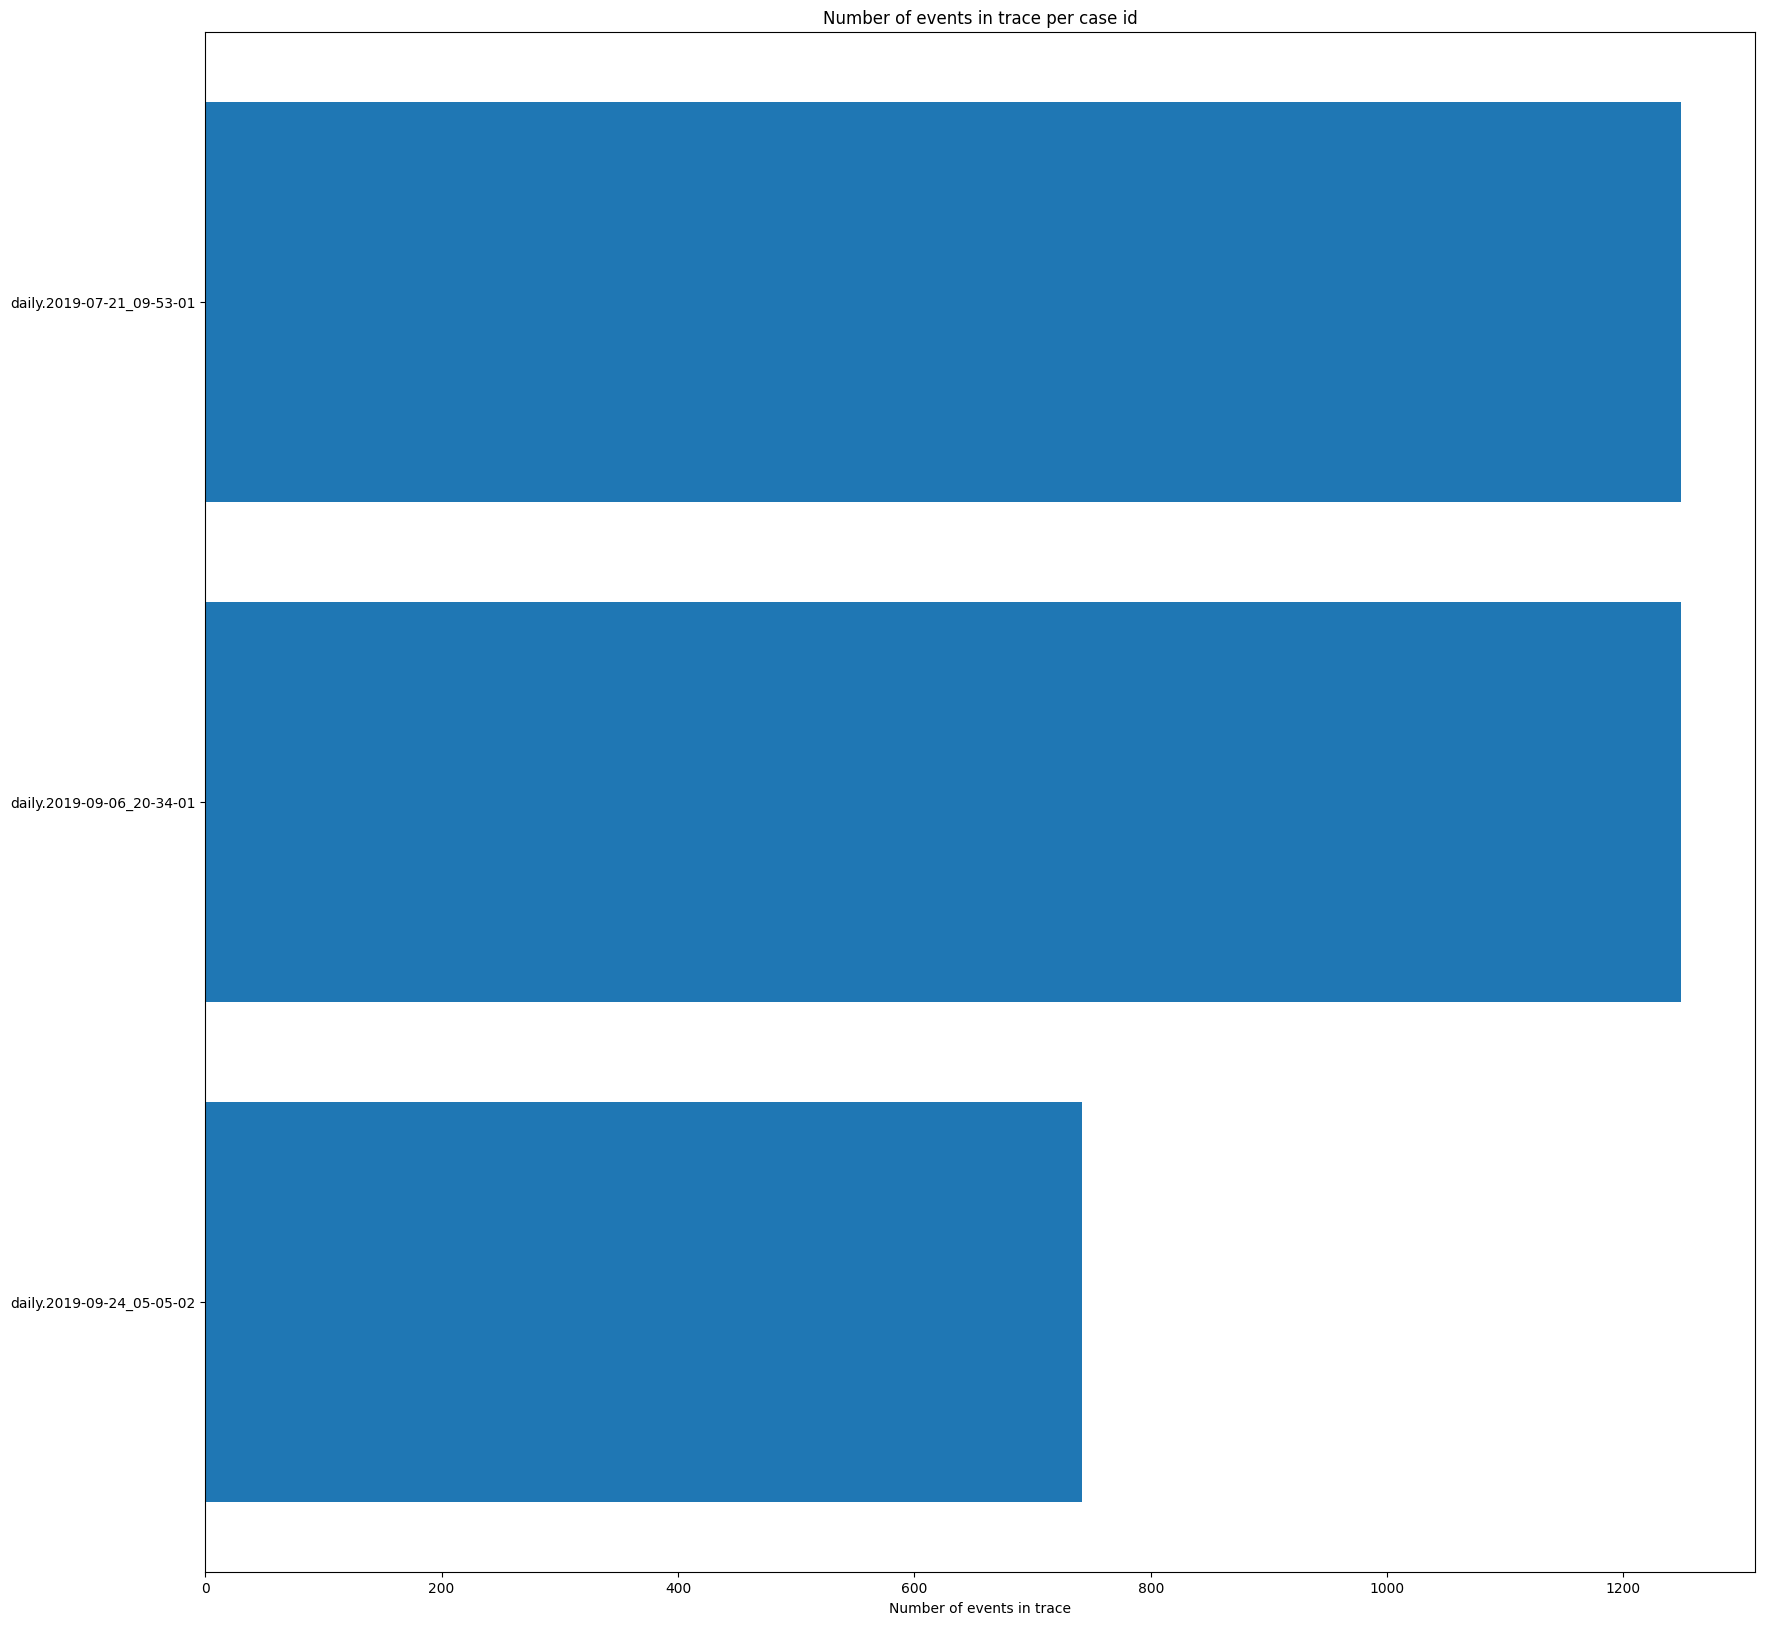

In [52]:
threshold_events_trace = threshold_histogram(merged_by_case, bucket='case', anomaly_name='total_points_in_case', x_axis_name='Number of events in trace')
#output_path = LUIGI_LOG_PATH+'/../../graphs/allDataAtOnce/daily.2019-0709_three_months_anomaly_threshold_num_events_trace.png'
#plt.savefig(output_path,  bbox_inches='tight')

In [53]:
anomaly_number_of_events_trace_results = get_anomaly_results(merged_by_case, std_factors=[ 1.5**x for x in range(8)], anomaly_name='total_points_in_case', bucket='case')
#output_path = LUIGI_LOG_PATH+'/../../graphs/allDataAtOnce/daily.2019-0709_three_months_anomaly_results_num_events_trace.csv'
#anomaly_number_of_events_trace_results.to_csv(output_path, index = None, header=True)
anomaly_number_of_events_trace_results

factor_std  average     std  lower_bound  upper_bound  number_of_anomalies  \
0    1.000000   1080.0  292.72       787.28      1372.72                    1   
1    1.500000   1080.0  292.72       640.92      1519.08                    0   
2    2.250000   1080.0  292.72       421.38      1738.62                    0   
3    3.375000   1080.0  292.72        92.07      2067.93                    0   
4    5.062500   1080.0  292.72         0.00      2561.90                    0   
5    7.593750   1080.0  292.72         0.00      3302.84                    0   
6   11.390625   1080.0  292.72         0.00      4414.26                    0   
7   17.085938   1080.0  292.72         0.00      6081.40                    0   

                anomaly_traces  
0  [daily.2019-09-24_05-05-02]  
1                           []  
2                           []  
3                           []  
4                           []  
5                           []  
6                           []  
7                           []

In [54]:
extreme_anomalies = anomaly_number_of_events_trace_results[anomaly_number_of_events_trace_results['number_of_anomalies']>=1].tail(1)
print(extreme_anomalies[['average','std','factor_std','lower_bound','upper_bound']])
print('The following anomalies were found:')
anomaly_case_id = extreme_anomalies['anomaly_traces'].values[0]
suspects_stats = merged_by_case[merged_by_case['case'].isin(anomaly_case_id)]
suspects_stats.head()

   average     std  factor_std  lower_bound  upper_bound
0   1080.0  292.72         1.0       787.28      1372.72
The following anomalies were found:


case  total_points_in_case  skyline_points_in_case  \
2  daily.2019-09-24_05-05-02                   742                      18   

   unique_skyline_activities_in_case  skyline_percentage  unique_percentage  
2                                  6                2.43              33.33

In [55]:
# Preparing anomaly to be plotted:

cases_to_plot = anomaly_case_id.tolist()
cases_to_plot.append('Average Case')
print("- Cases to be plotted:",cases_to_plot)

anomaly_suspects = subset[subset['case'].isin(cases_to_plot)]
print('- Number of activities in suspect trace:',len(anomaly_suspects['activity'].unique()))

average_trace_activities = vis.get_data_selection_avgtrace(vis.get_relative_timestamps(subset)).sort_values(by=['num_start'])[0:len(anomaly_suspects['activity'].unique())+20]
print('- Number of activities in average trace:',len(average_trace_activities))
print('- Number of activities in average trace but not in anomaly traces:',len(average_trace_activities[~average_trace_activities['activity'].isin(anomaly_suspects['activity'].unique())]))

average_skyline_activities = average_trace_activities[average_trace_activities['activity'].isin(anomaly_suspects['activity'].unique())]
#print(len(average_skyline_activities['activity'].unique()))


anomaly_suspects_and_average = pd.concat([anomaly_suspects, average_trace_activities[['num_start','num_end','activity','case', 'std_num_end']]], ignore_index=True)                                          
suspects_and_average=anomaly_suspects_and_average.copy()
print("- Number of events to be plotted:",len(anomaly_suspects_and_average))

suspects_and_average.head()


- Cases to be plotted: ['daily.2019-09-24_05-05-02', 'Average Case']
- Number of activities in suspect trace: 28
Grouped: 3240 columns ['case', 'activity', 'rel_start', 'rel_end', 'num_start', 'num_end', 'start_time', 'end_time', 'zero_point']
Merged relatived: 3264 columns ['case', 'activity', 'rel_start_x', 'rel_end_x', 'num_start_x', 'num_end_x', 'start_time', 'end_time', 'zero_point', 'rel_start_y', 'rel_end_y', 'num_start_y', 'num_end_y']
- Number of activities in average trace: 48
- Number of activities in average trace but not in anomaly traces: 20
- Number of events to be plotted: 790


case  \
0  daily.2019-09-24_05-05-02   
1  daily.2019-09-24_05-05-02   
2  daily.2019-09-24_05-05-02   
3  daily.2019-09-24_05-05-02   
4  daily.2019-09-24_05-05-02   

                                            activity rel_start  rel_end  \
0  DumpTask(sql_filename=regular_urls)(kvs=None)(...   0:00:00  0:20:11   
1                                                C_0   0:00:00  0:12:35   
2                                                C_0   0:00:00  0:23:33   
3  DumpTask(sql_filename=daily_urls)(kvs=None)(ch...   0:00:00  0:01:22   
4  DumpTask(sql_filename=reprocess_urls)(kvs=None...   0:00:00  0:00:53   

   num_start  num_end           start_time             end_time  std_num_end  
0        0.0   1211.0  2019-09-24 05:20:10  2019-09-24 05:40:21          NaN  
1        0.0    755.0  2019-09-24 05:20:10  2019-09-24 05:32:45          NaN  
2        0.0   1413.0  2019-09-24 05:20:10  2019-09-24 05:43:43          NaN  
3        0.0     82.0  2019-09-24 05:20:10  2019-09-24 05:21:32          NaN  
4        0.0     53.0  2019-09-24 05:20:10  2019-09-24 05:21:03          NaN

In [56]:
#output_path = LUIGI_LOG_PATH+'/../../graphs/allDataAtOnce/daily.2019-0709_three_months_anomaly_number_events_trace_example.png'
some_plot = vis.plot_traces(suspects_and_average)#, output_path=output_path
some_plot = plot_star_from_point(some_plot,average_trace_activities,anomaly_suspects)
#some_plot.savefig(output_path,  bbox_inches='tight')

### Anomaly of percentage of skyline points

#### Causes for this anomaly: 
* Deviation on specific activity/ies for a specific trace
* Upper: Tasks that normally do not last that long are

Open questions: 
* Further investigate points in shadow of each other.

<module 'matplotlib.pyplot' from '/Users/andreamaldonado/miniconda3/envs/py39/lib/python3.9/site-packages/matplotlib/pyplot.py'>

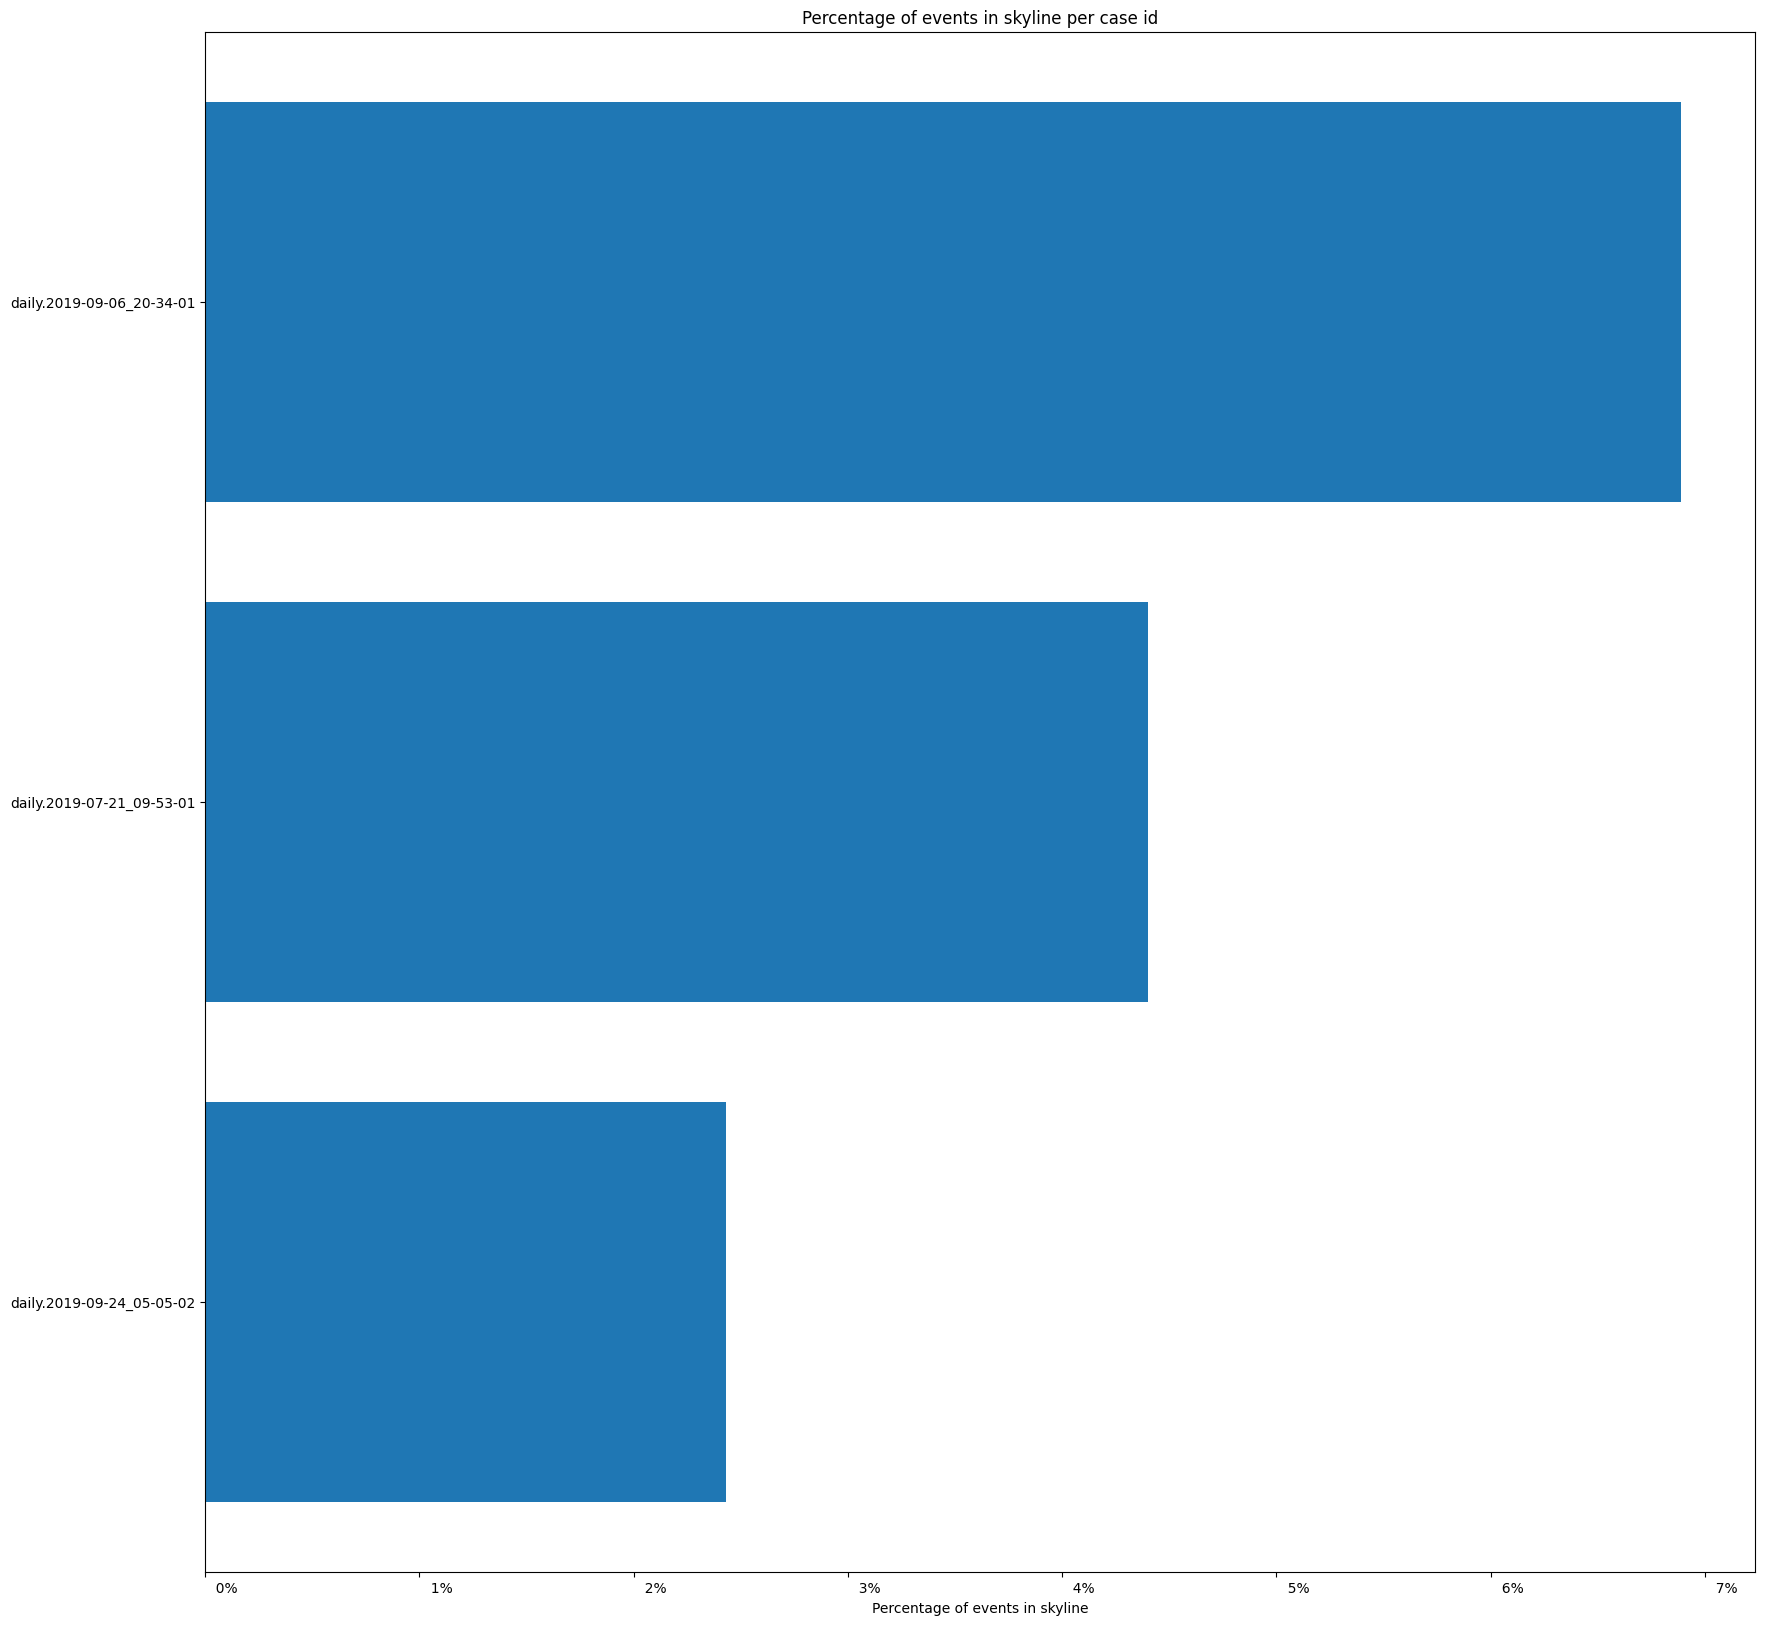

In [57]:
#threshold_histogram(merged_by_case, bucket='case', anomaly_name='skyline_points_in_case', x_axis_name='Number of events in skyline')
threshold_histogram(merged_by_case, bucket='case', anomaly_name='skyline_percentage',in_percentage=1, x_axis_name='Percentage of events in skyline')

#output_path = LUIGI_LOG_PATH+'/../../graphs/allDataAtOnce/daily.2019-0709_three_months_anomaly_threshold_num_events_skyline.png'
#plt.savefig(output_path,  bbox_inches='tight')

In [58]:
anomaly_number_of_events_skyline_results = get_anomaly_results(merged_by_case, std_factors=[ 1.5**x for x in range(8)], anomaly_name='skyline_percentage', bucket='case')

#output_path = LUIGI_LOG_PATH+'/../../graphs/allDataAtOnce/daily.2019-0709_three_months_anomaly_results_per_events_skyline.csv'
#anomaly_number_of_events_skyline_results.to_csv(output_path, index = None, header=True)
anomaly_number_of_events_skyline_results

factor_std  average   std  lower_bound  upper_bound  number_of_anomalies  \
0    1.000000     4.57  2.24         2.33         6.81                    1   
1    1.500000     4.57  2.24         1.21         7.93                    0   
2    2.250000     4.57  2.24         0.00         9.61                    0   
3    3.375000     4.57  2.24         0.00        12.13                    0   
4    5.062500     4.57  2.24         0.00        15.91                    0   
5    7.593750     4.57  2.24         0.00        21.58                    0   
6   11.390625     4.57  2.24         0.00        30.09                    0   
7   17.085938     4.57  2.24         0.00        42.84                    0   

                anomaly_traces  
0  [daily.2019-09-06_20-34-01]  
1                           []  
2                           []  
3                           []  
4                           []  
5                           []  
6                           []  
7                           []

In [59]:
extreme_anomalies = anomaly_number_of_events_skyline_results[anomaly_number_of_events_skyline_results['number_of_anomalies']>=1].tail(1)
print(extreme_anomalies[['average','std','factor_std','lower_bound','upper_bound']])
print('The following anomalies were found:')
anomaly_case_id = extreme_anomalies['anomaly_traces'].values[0]
suspects_stats = merged_by_case[merged_by_case['case'].isin(anomaly_case_id)]
suspects_stats.head()

   average   std  factor_std  lower_bound  upper_bound
0     4.57  2.24         1.0         2.33         6.81
The following anomalies were found:


case  total_points_in_case  skyline_points_in_case  \
1  daily.2019-09-06_20-34-01                  1249                      86   

   unique_skyline_activities_in_case  skyline_percentage  unique_percentage  
1                                 10                6.89              11.63

In [60]:
# Preparing anomaly to be plotted:

cases_to_plot = [anomaly_case_id.tolist()[0]]
cases_to_plot.append('Average Case')
print("- Cases to be plotted:",cases_to_plot)

#skyline_points = vis.get_skyline_points(subset)
anomaly_suspects = skyline_points[skyline_points['case'].isin(cases_to_plot)]
print('- Number of activities in suspect skyline:',len(anomaly_suspects['activity'].unique()))

average_trace_activities = vis.get_data_selection_avgtrace(vis.get_relative_timestamps(subset)).sort_values(by=['num_start'])
print('- Number of activities in average trace:',len(average_trace_activities))
print('- Number of activities in average trace but not in anomaly skyline:',len(average_trace_activities[~average_trace_activities['activity'].isin(anomaly_suspects['activity'].unique())]))

average_skyline_activities = average_trace_activities[average_trace_activities['activity'].isin(anomaly_suspects['activity'].unique())]
#print(len(average_skyline_activities['activity'].unique()))


anomaly_suspects_and_average = pd.concat([anomaly_suspects, average_trace_activities[['num_start','num_end','activity','case', 'std_num_end']]], ignore_index=True)                                          
suspects_and_average=anomaly_suspects_and_average.copy()
print("- Number of events to be plotted:",len(anomaly_suspects_and_average))

average_skyline_activities.head()

- Cases to be plotted: ['daily.2019-09-06_20-34-01', 'Average Case']
- Number of activities in suspect skyline: 10
Grouped: 3240 columns ['case', 'activity', 'rel_start', 'rel_end', 'num_start', 'num_end', 'start_time', 'end_time', 'zero_point']
Merged relatived: 3264 columns ['case', 'activity', 'rel_start_x', 'rel_end_x', 'num_start_x', 'num_end_x', 'start_time', 'end_time', 'zero_point', 'rel_start_y', 'rel_end_y', 'num_start_y', 'num_end_y']
- Number of activities in average trace: 49
- Number of activities in average trace but not in anomaly skyline: 39
- Number of events to be plotted: 135


activity average_start  \
0  DumpTask(sql_filename=daily_urls)(kvs=None)(ch...      00:00:00   
1  DumpTask(sql_filename=regular_urls)(kvs=None)(...      00:00:00   
4  DumpTask(sql_filename=reprocess_urls)(kvs=None...      00:00:17   
5  DumpTask(sql_filename=mgmt_response)(kvs=None)...      00:01:17   
6  DumpTask(sql_filename=review)(kvs=(('table_nam...      02:48:56   

  average_end     num_start       num_end          case  std_num_end  
0    00:01:17      0.000000     77.333333  Average Case          0.0  
1    00:23:55      0.000000   1435.000000  Average Case          0.0  
4    00:01:06     17.333333     66.666667  Average Case          0.0  
5    01:36:18     77.333333   5778.666667  Average Case          0.0  
6    03:07:15  10136.870370  11235.277778  Average Case          0.0

In [61]:
#output_path = LUIGI_LOG_PATH+'/../../graphs/allDataAtOnce/daily.2019-0709_three_months_anomaly_number_events_skyline_example.png'
some_plot = vis.plot_traces(suspects_and_average, draw_skylines=1)#, output_path=output_path
some_plot = plot_star_from_point(some_plot,average_trace_activities,anomaly_suspects, anomaly_name='skyline_points_in_case')
#some_plot.savefig(output_path,  bbox_inches='tight')

### Anomaly of Number of Events in Trace per Activity

Thoughts: If any activity deviates too much for any case it can be consider as a anomaly for the that specific trace. Leading to further investigation. 

In [62]:
by_case_activity_p = subset.groupby(['activity', 'case']).size().reset_index(name='total_points_in_case').sort_values(by=['total_points_in_case'], ascending=False)
by_case_activity= by_case_activity_p.pivot(index='activity', columns='case', values='total_points_in_case').reset_index()
by_case_activity=by_case_activity.set_index('activity')

# Select any row where any column fullfills any condition:
mask = by_case_activity.applymap(lambda x: x>1)
candidates = by_case_activity[mask.any(axis=1)]
candidates = candidates.fillna(0)
candidates

case                                                daily.2019-07-21_09-53-01  \
activity                                                                        
C_0                                                                      18.0   
C_4                                                                    1018.0   
ConvertDumpTask(sql_filename=review)(chunk=prep...                       36.0   
DumpTask(sql_filename=review)(kvs=(('table_name...                       36.0   
T_3                                                                      98.0   

case                                                daily.2019-09-06_20-34-01  \
activity                                                                        
C_0                                                                      18.0   
C_4                                                                    1018.0   
ConvertDumpTask(sql_filename=review)(chunk=prep...                       36.0   
DumpTask(sql_filename=review)(kvs=(('table_name...                       36.0   
T_3                                                                      98.0   

case                                                daily.2019-09-24_05-05-02  
activity                                                                       
C_0                                                                      20.0  
C_4                                                                     622.0  
ConvertDumpTask(sql_filename=review)(chunk=prep...                       36.0  
DumpTask(sql_filename=review)(kvs=(('table_name...                       36.0  
T_3                                                                       5.0

In [63]:
stats_case_activity = pd.DataFrame()
stats_case_activity['average']=by_case_activity.mean(axis=1).apply(math.floor)
stats_case_activity['std']=by_case_activity.std(axis=1)
stats_case_activity['lower_bound']=stats_case_activity.apply(lambda row: row['average']-row['std'], axis=1)
stats_case_activity['upper_bound']=stats_case_activity.apply(lambda row: row['average']+row['std'], axis=1)
#stats_case_activity[stats_case_activity['stddev']>0]
stats_case_activity=stats_case_activity.sort_values(by='std', ascending=False).head(15)
activity_candidates =stats_case_activity[stats_case_activity['std']!=0].reset_index()
activity_candidates

activity  average         std  lower_bound  upper_bound
0      C_4      886  228.630707   657.369293  1114.630707
1      T_3       67   53.693575    13.306425   120.693575
2      C_0       18    1.154701    16.845299    19.154701

In [64]:
activity_candidates =stats_case_activity[stats_case_activity['std']!=0].reset_index()
candidates_names= activity_candidates['activity'].unique()

anomaly_activities = by_case_activity_p[by_case_activity_p['activity'].isin(candidates_names)]

activity_evaluated = pd.DataFrame(columns=['activity','number_of_anomalies','anomaly_traces'])
for index, condition in activity_candidates.iterrows():
    #print(condition)
    content = anomaly_activities[anomaly_activities['activity']==condition['activity']]
    x,y = evaluate_condition(condition, content, anomaly_name='total_points_in_case', bucket='case')
    if x>0:
        activity_evaluated = activity_evaluated.append({'activity': condition['activity'], 'number_of_anomalies':x, 'anomaly_traces':y}, ignore_index=True)
#activity_evaluated.sort_values(by='number_of_anomalies', ascending=False)
activity_evaluated['prob_of_anomalies'] = 1-(activity_evaluated['number_of_anomalies']/11)
activity_evaluated.sort_values(by='number_of_anomalies', ascending=False)

/var/folders/d0/btmbyskx4t106_l2zghzln2w0000gn/T/ipykernel_8307/3712734030.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  activity_evaluated = activity_evaluated.append({'activity': condition['activity'], 'number_of_anomalies':x, 'anomaly_traces':y}, ignore_index=True)
/var/folders/d0/btmbyskx4t106_l2zghzln2w0000gn/T/ipykernel_8307/3712734030.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  activity_evaluated = activity_evaluated.append({'activity': condition['activity'], 'number_of_anomalies':x, 'anomaly_traces':y}, ignore_index=True)
/var/folders/d0/btmbyskx4t106_l2zghzln2w0000gn/T/ipykernel_8307/3712734030.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  activity_evaluated = activity_evaluated.append({'acti

activity number_of_anomalies               anomaly_traces prob_of_anomalies
0      C_4                   1  [daily.2019-09-24_05-05-02]          0.909091
1      T_3                   1  [daily.2019-09-24_05-05-02]          0.909091
2      C_0                   1  [daily.2019-09-24_05-05-02]          0.909091

<module 'matplotlib.pyplot' from '/Users/andreamaldonado/miniconda3/envs/py39/lib/python3.9/site-packages/matplotlib/pyplot.py'>

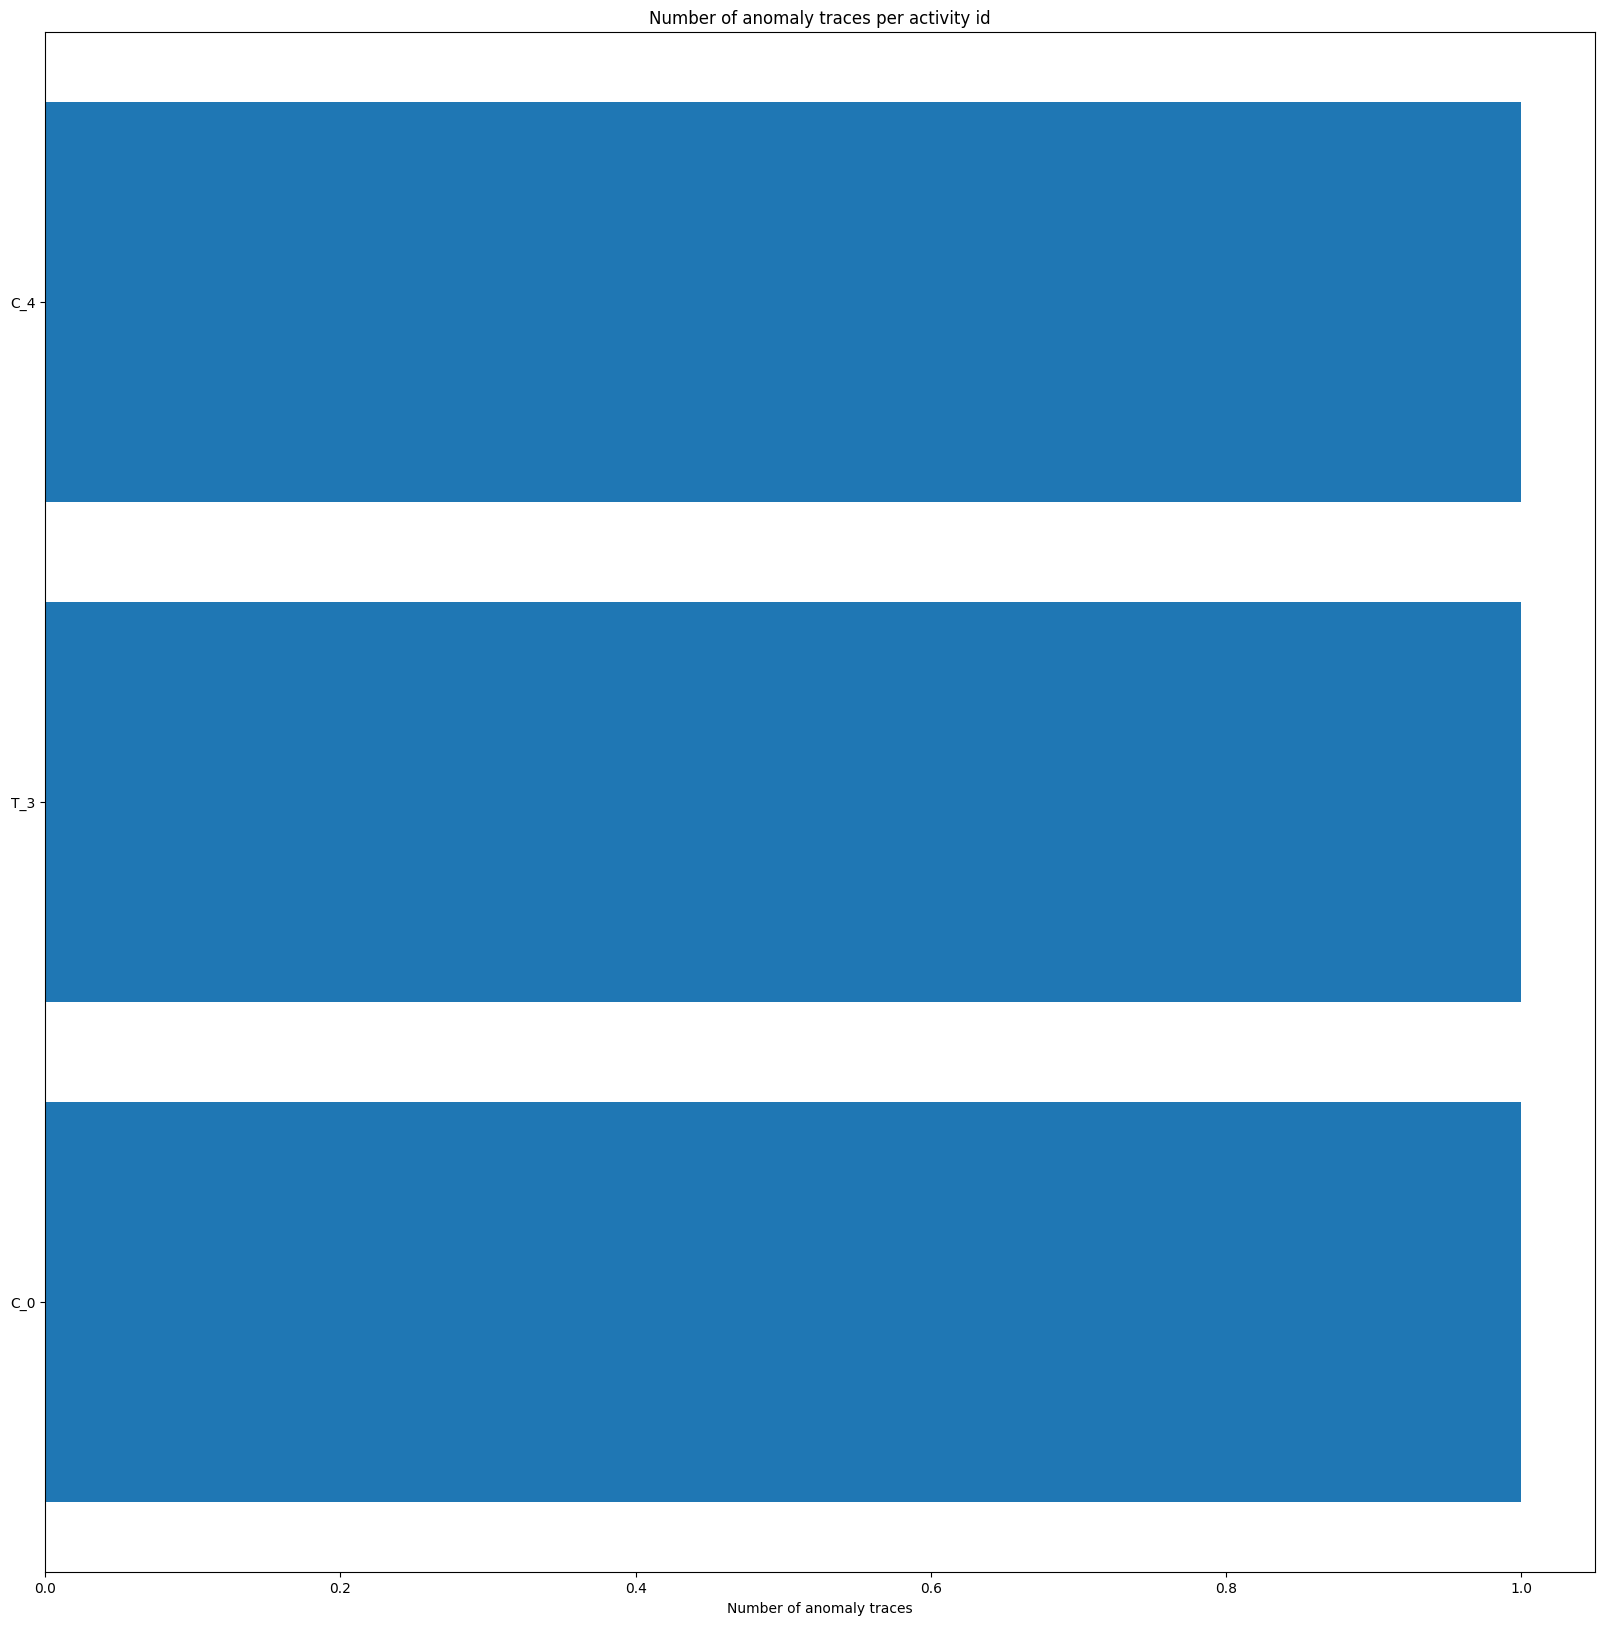

In [65]:
threshold_histogram(activity_evaluated, bucket='activity', anomaly_name='number_of_anomalies', x_axis_name='Number of anomaly traces')

#output_path = LUIGI_LOG_PATH+'/../../graphs/allDataAtOnce/daily.2019-0709_three_months_anomaly_threshold_num_activity_trace_anomaly_traces.png'
#plt.savefig(output_path,  bbox_inches='tight')

In [66]:
extreme_anomalies = activity_evaluated[activity_evaluated['number_of_anomalies']>=1].sort_values(by='number_of_anomalies').tail(1)
#print(extreme_anomalies[['average','std','lower_bound','upper_bound']])
print('The following anomalies were found:')
anomaly_activity_id = extreme_anomalies['activity'].values[0]
anomaly_case_id = extreme_anomalies['anomaly_traces'].values[0]
print(anomaly_case_id, 'for')
suspects_stats = activity_candidates[activity_candidates['activity'].isin([anomaly_activity_id])]
suspects_stats.head()

The following anomalies were found:
['daily.2019-09-24_05-05-02'] for


activity  average       std  lower_bound  upper_bound
2      C_0       18  1.154701    16.845299    19.154701

In [67]:
# Preparing anomaly to be plotted:

cases_to_plot = [anomaly_case_id.tolist()[0]]
cases_to_plot.append('Average Skyline')
print("- Cases to be plotted:",cases_to_plot)

#skyline_pointsdraw_skylines=t.get_skyline_points(subset)
anomaly_suspects = skyline_points[skyline_points['case'].isin(cases_to_plot)]
print('- Number of activities in suspect skyline:',len(anomaly_suspects['activity'].unique()))

average_trace_activities = vis.get_data_selection_avgtrace(vis.get_relative_timestamps(subset)).sort_values(by=['num_start'])
#average_trace_activities= vis.get_skyline_points(average_trace_activities)
print('- Number of activities in average trace:',len(average_skyline_activities))
print('- Number of activities in average trace but not in anomaly skyline:',len(average_trace_activities[~average_trace_activities['activity'].isin(anomaly_suspects['activity'].unique())]))


#average_trace_activities[average_trace_activities['activity'].isin(anomaly_suspects['activity'].unique())]
#print(len(average_skyline_activities['activity'].unique()))


anomaly_suspects_and_average = pd.concat([anomaly_suspects, average_trace_activities[['num_start','num_end','activity','case']]], ignore_index=True)                                          
suspects_and_average=anomaly_suspects_and_average.copy()
print("- Number of events to be plotted:",len(anomaly_suspects_and_average))

average_skyline_activities.head()

- Cases to be plotted: ['daily.2019-09-24_05-05-02', 'Average Skyline']
- Number of activities in suspect skyline: 6
Grouped: 3240 columns ['case', 'activity', 'rel_start', 'rel_end', 'num_start', 'num_end', 'start_time', 'end_time', 'zero_point']
Merged relatived: 3264 columns ['case', 'activity', 'rel_start_x', 'rel_end_x', 'num_start_x', 'num_end_x', 'start_time', 'end_time', 'zero_point', 'rel_start_y', 'rel_end_y', 'num_start_y', 'num_end_y']
- Number of activities in average trace: 10
- Number of activities in average trace but not in anomaly skyline: 43
- Number of events to be plotted: 67


activity average_start  \
0  DumpTask(sql_filename=daily_urls)(kvs=None)(ch...      00:00:00   
1  DumpTask(sql_filename=regular_urls)(kvs=None)(...      00:00:00   
4  DumpTask(sql_filename=reprocess_urls)(kvs=None...      00:00:17   
5  DumpTask(sql_filename=mgmt_response)(kvs=None)...      00:01:17   
6  DumpTask(sql_filename=review)(kvs=(('table_nam...      02:48:56   

  average_end     num_start       num_end          case  std_num_end  
0    00:01:17      0.000000     77.333333  Average Case          0.0  
1    00:23:55      0.000000   1435.000000  Average Case          0.0  
4    00:01:06     17.333333     66.666667  Average Case          0.0  
5    01:36:18     77.333333   5778.666667  Average Case          0.0  
6    03:07:15  10136.870370  11235.277778  Average Case          0.0

In [68]:
#output_path = LUIGI_LOG_PATH+'/../../graphs/allDataAtOnce/daily.2019-0709_three_months_anomaly_num_activity_trace_anomaly_traces_example.png'
some_plot = vis.plot_traces(suspects_and_average, draw_skylines=1)#, output_path=output_path
some_plot = plot_star_from_point(some_plot, average_trace_activities, anomaly_suspects, anomaly_name='skyline_points_in_case')
#some_plot.savefig(output_path,  bbox_inches='tight')

### Anomaly of Number of Events in Skyline per Activity

Thoughts: If any activity deviates too much for any case it can be consider as a anomaly for the that specific trace. I suspect deviations on the skyline lead to deviations of the overall time. 


In [69]:
s_by_case_activity_p = skyline_points.groupby(['activity', 'case']).size().reset_index(name='total_points_in_case').sort_values(by=['total_points_in_case'], ascending=False)
#print(s_by_case_activity.head())
s_by_case_activity= s_by_case_activity_p.pivot(index='activity', columns='case', values='total_points_in_case').reset_index()
#s_by_case_activity.head()
s_by_case_activity=s_by_case_activity.set_index('activity')
s_by_case_activity=s_by_case_activity.fillna(0)
s_by_case_activity.head()

case                                                daily.2019-07-21_09-53-01  \
activity                                                                        
C_0                                                                       6.0   
C_4                                                                      33.0   
DumpTask(sql_filename=daily_urls)(kvs=None)(chu...                        1.0   
DumpTask(sql_filename=mgmt_response)(kvs=None)(...                        1.0   
DumpTask(sql_filename=other_urls)(kvs=None)(chu...                        1.0   

case                                                daily.2019-09-06_20-34-01  \
activity                                                                        
C_0                                                                       5.0   
C_4                                                                      61.0   
DumpTask(sql_filename=daily_urls)(kvs=None)(chu...                        1.0   
DumpTask(sql_filename=mgmt_response)(kvs=None)(...                        1.0   
DumpTask(sql_filename=other_urls)(kvs=None)(chu...                        0.0   

case                                                daily.2019-09-24_05-05-02  
activity                                                                       
C_0                                                                       2.0  
C_4                                                                      12.0  
DumpTask(sql_filename=daily_urls)(kvs=None)(chu...                        1.0  
DumpTask(sql_filename=mgmt_response)(kvs=None)(...                        1.0  
DumpTask(sql_filename=other_urls)(kvs=None)(chu...                        0.0

In [70]:
# Select any row where any column fullfills any condition:
mask = s_by_case_activity.applymap(lambda x: x>1)
more_than = s_by_case_activity[mask.any(axis=1)]
#s_by_case_activity.head(20)
more_than


case                                                daily.2019-07-21_09-53-01  \
activity                                                                        
C_0                                                                       6.0   
C_4                                                                      33.0   
DumpTask(sql_filename=review)(kvs=(('table_name...                        2.0   
T_3                                                                       5.0   

case                                                daily.2019-09-06_20-34-01  \
activity                                                                        
C_0                                                                       5.0   
C_4                                                                      61.0   
DumpTask(sql_filename=review)(kvs=(('table_name...                        1.0   
T_3                                                                      13.0   

case                                                daily.2019-09-24_05-05-02  
activity                                                                       
C_0                                                                       2.0  
C_4                                                                      12.0  
DumpTask(sql_filename=review)(kvs=(('table_name...                        0.0  
T_3                                                                       0.0

In [71]:
stats_s_case_activity = pd.DataFrame()
stats_s_case_activity['avg']=s_by_case_activity.mean(axis=1).apply(math.floor)
stats_s_case_activity['std']=s_by_case_activity.std(axis=1)
stats_s_case_activity['lower_bound']=stats_s_case_activity.apply(lambda row: row['avg']-row['std'], axis=1)
stats_s_case_activity['upper_bound']=stats_s_case_activity.apply(lambda row: row['avg']+row['std'], axis=1)
stats_s_case_activity = stats_s_case_activity[stats_s_case_activity['std']>0].reset_index()

#TODO: Anomaly detection when any row exceeds lower or upper bound from stats.

In [72]:
activity_candidates =stats_s_case_activity[stats_s_case_activity['std']!=0].reset_index()
candidates_names= activity_candidates['activity'].unique()

anomaly_activities = s_by_case_activity_p[s_by_case_activity_p['activity'].isin(candidates_names)]

activity_evaluated = pd.DataFrame(columns=['activity','number_of_anomalies','anomaly_traces'])
for index, condition in activity_candidates.iterrows():
    #print(condition)
    content = anomaly_activities[anomaly_activities['activity']==condition['activity']]
    x,y = evaluate_condition(condition, content, anomaly_name='total_points_in_case', bucket='case')
    if x>0:
        activity_evaluated = activity_evaluated.append({'activity': condition['activity'], 'number_of_anomalies':x, 'anomaly_traces':y}, ignore_index=True)
#activity_evaluated.sort_values(by='number_of_anomalies', ascending=False)
activity_evaluated['prob_of_anomalies'] = 1-(activity_evaluated['number_of_anomalies']/11)
activity_evaluated.sort_values(by='number_of_anomalies', ascending=False)

/var/folders/d0/btmbyskx4t106_l2zghzln2w0000gn/T/ipykernel_8307/1686087174.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  activity_evaluated = activity_evaluated.append({'activity': condition['activity'], 'number_of_anomalies':x, 'anomaly_traces':y}, ignore_index=True)
/var/folders/d0/btmbyskx4t106_l2zghzln2w0000gn/T/ipykernel_8307/1686087174.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  activity_evaluated = activity_evaluated.append({'activity': condition['activity'], 'number_of_anomalies':x, 'anomaly_traces':y}, ignore_index=True)
/var/folders/d0/btmbyskx4t106_l2zghzln2w0000gn/T/ipykernel_8307/1686087174.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  activity_evaluated = activity_evaluated.append({'acti

activity number_of_anomalies  \
2  DumpTask(sql_filename=reprocess_urls)(kvs=None...                   2   
3  GroupTask(datacenter=eu)(datastore=mongo)(inc=...                   2   
0                                                C_4                   1   
1  DumpTask(sql_filename=other_urls)(kvs=None)(ch...                   1   
4  GroupTask(datacenter=eu)(datastore=mongo)(inc=...                   1   
5  GroupTask(datacenter=eu)(datastore=mongo)(inc=...                   1   
6  GroupTask(datacenter=eu)(datastore=tch)(inc=Fa...                   1   
7  GroupTask(datacenter=eu)(datastore=tch)(inc=Tr...                   1   
8              QCValidateTask(what=review)(chunk=03)                   1   
9                                                T_3                   1   

                                      anomaly_traces prob_of_anomalies  
2  [daily.2019-09-24_05-05-02, daily.2019-09-06_2...          0.818182  
3  [daily.2019-09-06_20-34-01, daily.2019-07-21_0...          0.818182  
0                        [daily.2019-09-06_20-34-01]          0.909091  
1                        [daily.2019-07-21_09-53-01]          0.909091  
4                        [daily.2019-07-21_09-53-01]          0.909091  
5                        [daily.2019-07-21_09-53-01]          0.909091  
6                        [daily.2019-07-21_09-53-01]          0.909091  
7                        [daily.2019-07-21_09-53-01]          0.909091  
8                        [daily.2019-09-06_20-34-01]          0.909091  
9                        [daily.2019-09-06_20-34-01]          0.909091

<module 'matplotlib.pyplot' from '/Users/andreamaldonado/miniconda3/envs/py39/lib/python3.9/site-packages/matplotlib/pyplot.py'>

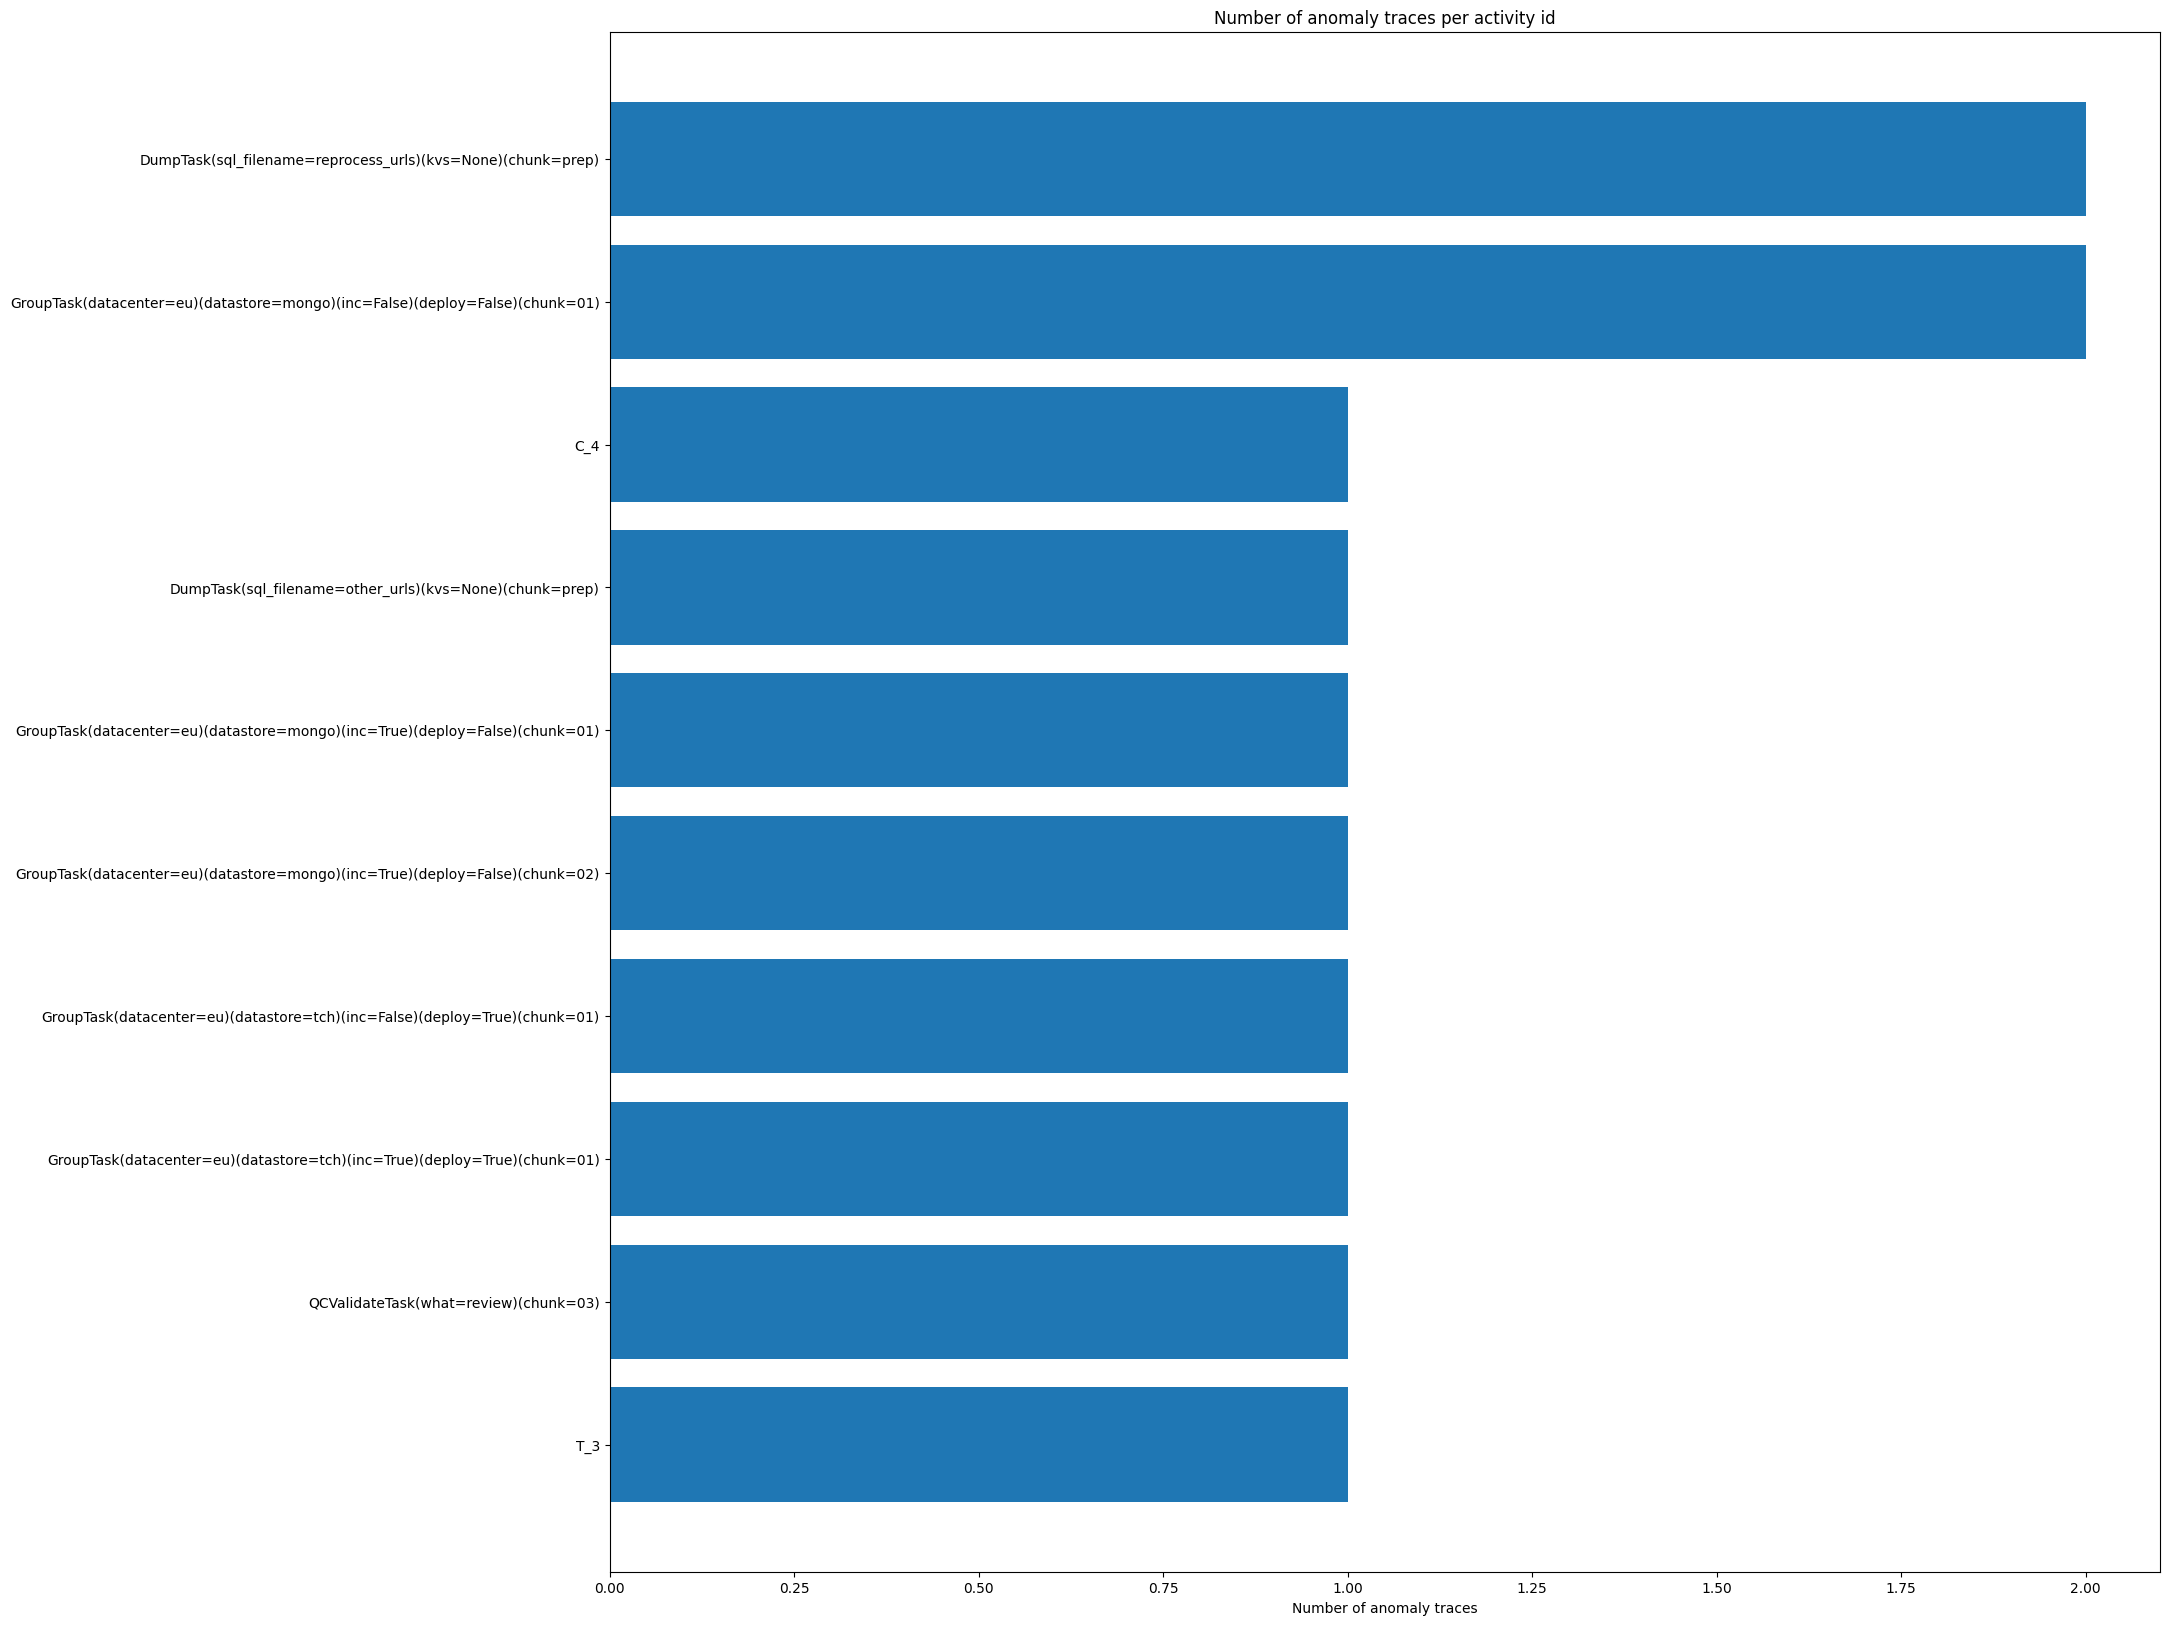

In [73]:
threshold_histogram(activity_evaluated, bucket='activity', anomaly_name='number_of_anomalies', x_axis_name='Number of anomaly traces')

#output_path = LUIGI_LOG_PATH+'/../../graphs/allDataAtOnce/daily.2019-0709_three_months_anomaly_threshold_num_activity_trace_anomaly_traces.png'
#plt.savefig(output_path,  bbox_inches='tight')

In [74]:
extreme_anomalies = activity_evaluated[activity_evaluated['number_of_anomalies']>=1].sort_values(by='number_of_anomalies').tail(1)
#print(extreme_anomalies[['average','std','lower_bound','upper_bound']])
print('The following anomalies were found:')
anomaly_activity_id = extreme_anomalies['activity'].values[0]
anomaly_case_id = extreme_anomalies['anomaly_traces'].values[0]
print(anomaly_case_id, 'for')
suspects_stats = activity_candidates[activity_candidates['activity'].isin([anomaly_activity_id])]
suspects_stats.head()

The following anomalies were found:
['daily.2019-09-06_20-34-01' 'daily.2019-07-21_09-53-01'] for


index                                           activity  avg      std  \
5      5  GroupTask(datacenter=eu)(datastore=mongo)(inc=...    0  0.57735   

   lower_bound  upper_bound  
5     -0.57735      0.57735

In [75]:
# Preparing anomaly to be plotted:

cases_to_plot = [anomaly_case_id.tolist()[0]]
cases_to_plot.append('Average Skyline')
print("- Cases to be plotted:",cases_to_plot)

#skyline_pointsdraw_skylines=t.get_skyline_points(subset)
anomaly_suspects = skyline_points[skyline_points['case'].isin(cases_to_plot)]
print('- Number of activities in suspect skyline:',len(anomaly_suspects['activity'].unique()))

average_trace_activities = vis.get_data_selection_avgtrace(vis.get_relative_timestamps(subset)).sort_values(by=['num_start'])
average_trace_activities= vis.get_skyline_points(average_trace_activities)
print('- Number of activities in average trace:',len(average_skyline_activities))
print('- Number of activities in average trace but not in anomaly skyline:',len(average_trace_activities[~average_trace_activities['activity'].isin(anomaly_suspects['activity'].unique())]))


#average_trace_activities[average_trace_activities['activity'].isin(anomaly_suspects['activity'].unique())]
#print(len(average_skyline_activities['activity'].unique()))


anomaly_suspects_and_average = pd.concat([anomaly_suspects, average_trace_activities[['num_start','num_end','activity','case']]], ignore_index=True)                                          
suspects_and_average=anomaly_suspects_and_average.copy()
print("- Number of events to be plotted:",len(anomaly_suspects_and_average))

average_skyline_activities.head()

- Cases to be plotted: ['daily.2019-09-06_20-34-01', 'Average Skyline']
- Number of activities in suspect skyline: 10
Grouped: 3240 columns ['case', 'activity', 'rel_start', 'rel_end', 'num_start', 'num_end', 'start_time', 'end_time', 'zero_point']
Merged relatived: 3264 columns ['case', 'activity', 'rel_start_x', 'rel_end_x', 'num_start_x', 'num_end_x', 'start_time', 'end_time', 'zero_point', 'rel_start_y', 'rel_end_y', 'num_start_y', 'num_end_y']
- Number of activities in average trace: 10
- Number of activities in average trace but not in anomaly skyline: 26
- Number of events to be plotted: 120


activity average_start  \
0  DumpTask(sql_filename=daily_urls)(kvs=None)(ch...      00:00:00   
1  DumpTask(sql_filename=regular_urls)(kvs=None)(...      00:00:00   
4  DumpTask(sql_filename=reprocess_urls)(kvs=None...      00:00:17   
5  DumpTask(sql_filename=mgmt_response)(kvs=None)...      00:01:17   
6  DumpTask(sql_filename=review)(kvs=(('table_nam...      02:48:56   

  average_end     num_start       num_end          case  std_num_end  
0    00:01:17      0.000000     77.333333  Average Case          0.0  
1    00:23:55      0.000000   1435.000000  Average Case          0.0  
4    00:01:06     17.333333     66.666667  Average Case          0.0  
5    01:36:18     77.333333   5778.666667  Average Case          0.0  
6    03:07:15  10136.870370  11235.277778  Average Case          0.0

In [76]:
#output_path = LUIGI_LOG_PATH+'/../../graphs/allDataAtOnce/daily.2019-0709_three_months_anomaly_num_activity_trace_anomaly_traces_example.png'
some_plot = vis.plot_traces(suspects_and_average, draw_skylines=1)#, output_path=output_path
some_plot = plot_star_from_point(some_plot, average_trace_activities, anomaly_suspects, anomaly_name='skyline_points_in_case')
#some_plot.savefig(output_path,  bbox_inches='tight')

## What set of activities are expected to appear on the skyline? 

* What activities are commonly on the skyline? 
* What traces deviate? and why?
* Frequent pattern mining for skyline activities? 
* Can we predict what activities will be on the skyline?

In [77]:
all_by_activity = subset.groupby('activity').size().reset_index(name='total_points_in_activity').sort_values(by=['total_points_in_activity'], ascending=False)
skyline_by_activity = skyline_points.groupby('activity').size().reset_index(name='points_in_skyline').sort_values(by=['points_in_skyline'], ascending=False)
r_by_activity = representative.groupby('activity').size().reset_index(name='cases_in_skyline').sort_values(by=['cases_in_skyline'], ascending=False)
by_activity = r_by_activity.merge(skyline_by_activity, on='activity')
#by_activity = by_activity.merge(all_by_activity, on='activity')
#all_by_activity.plot.hist(bins=16, alpha=0.5)

<AxesSubplot:ylabel='Frequency'>

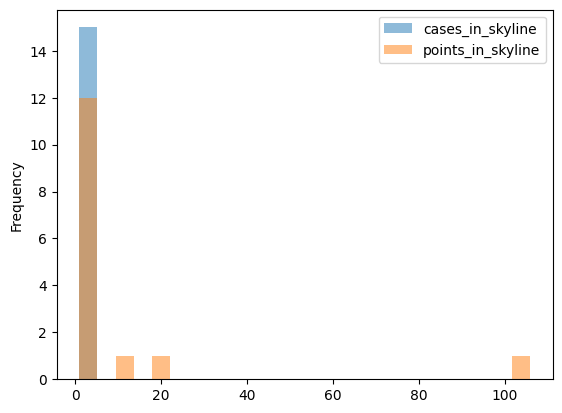

In [78]:
by_activity.plot.hist(bins=25, alpha=0.5, )

In [79]:
merged_by_activity = by_activity.merge(all_by_activity)[['activity','total_points_in_activity','points_in_skyline', 'cases_in_skyline']].sort_values(by=['total_points_in_activity'], ascending=False)
#merged_by_activity['skyline_percentage'] = round(merged_by_activity.apply(lambda row: row['points_in_skyline']/row['total_points_in_activity']*100, axis=1),2)

total_diffferent_cases= len(subset['case'].unique())
total_points_in_skyline = merged_by_activity['points_in_skyline'].sum()

merged_by_activity['probability_activity_in_skyline']=round(merged_by_activity.apply(lambda row: row['cases_in_skyline']/total_diffferent_cases*100, axis=1),2)
#merged_by_activity['prob_skyline_appearance']=round(merged_by_activity.apply(lambda row: row['points_in_skyline']/(total_points_in_skyline/total_diffferent_cases)*100, axis=1),2)
print(len(merged_by_activity))
merged_by_activity = merged_by_activity.sort_values(by='probability_activity_in_skyline', ascending=False)
merged_by_activity.head(6)

15


activity  \
1                                                C_4   
0                                                C_0   
2  DumpTask(sql_filename=daily_urls)(kvs=None)(ch...   
3  DumpTask(sql_filename=mgmt_response)(kvs=None)...   
4  DumpTask(sql_filename=regular_urls)(kvs=None)(...   
8                                                T_3   

   total_points_in_activity  points_in_skyline  cases_in_skyline  \
1                      2658                106                 3   
0                        56                 13                 3   
2                         3                  3                 3   
3                         3                  3                 3   
4                         3                  3                 3   
8                       201                 18                 2   

   probability_activity_in_skyline  
1                           100.00  
0                           100.00  
2                           100.00  
3                           100.00  
4                           100.00  
8                            66.67

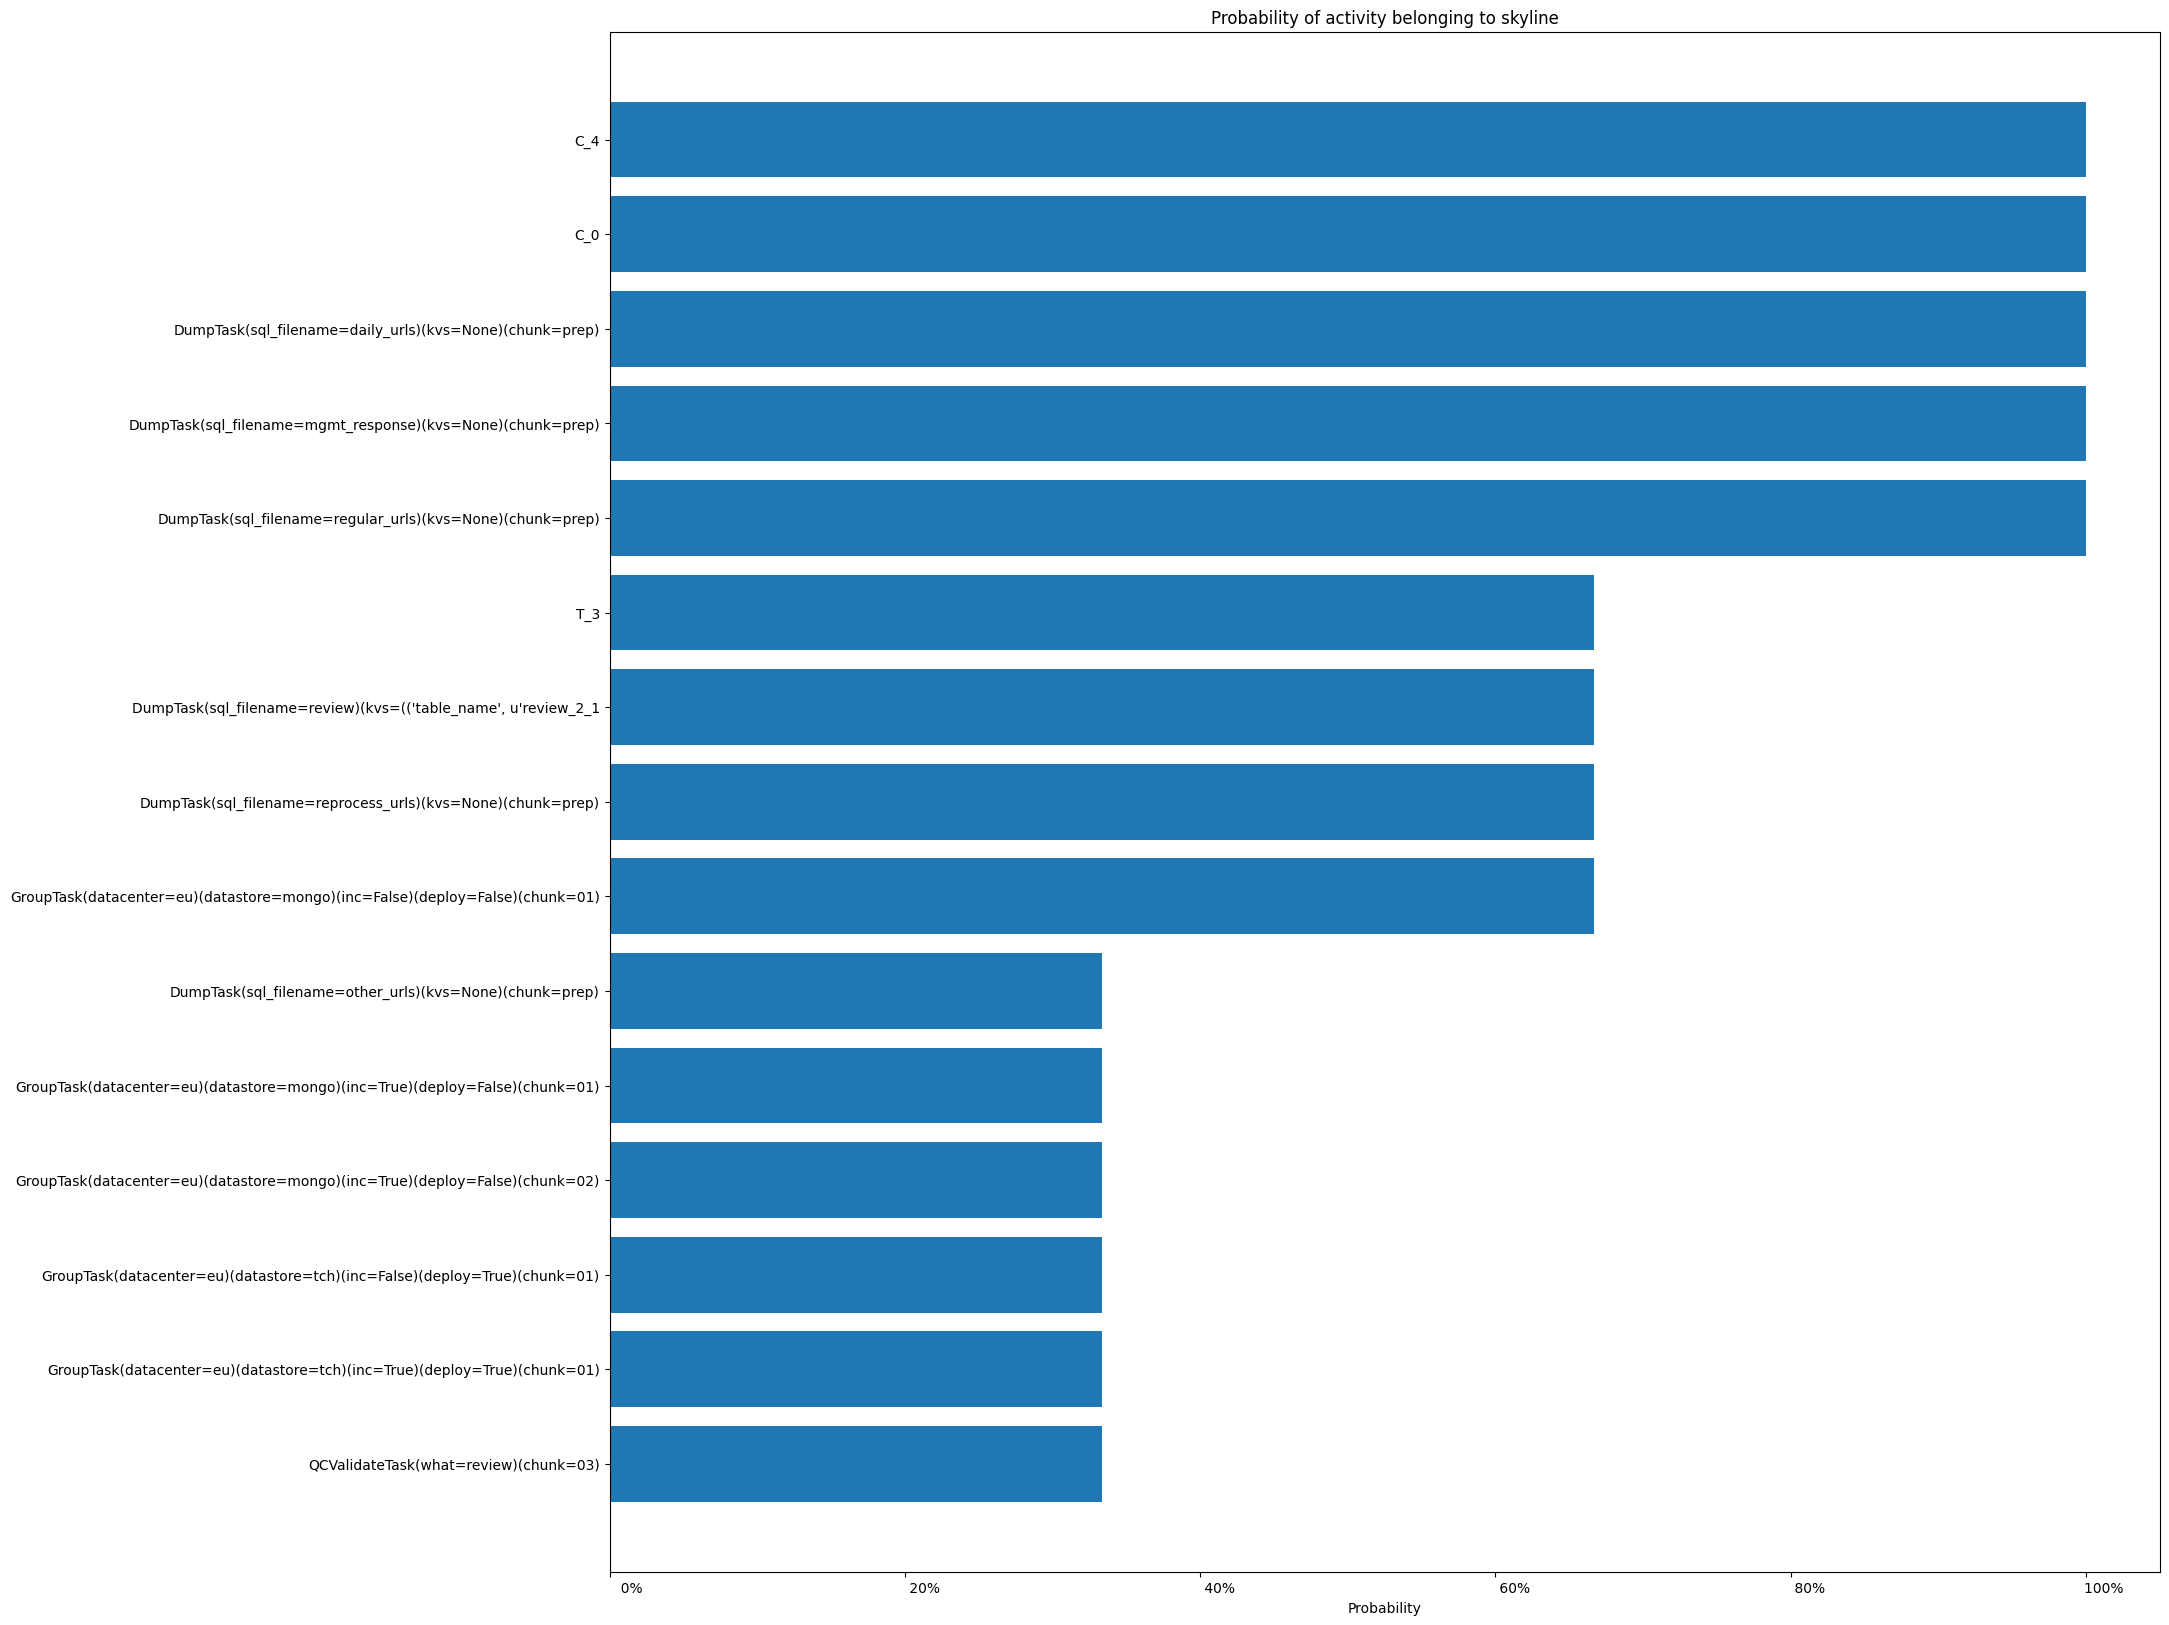

In [80]:
import matplotlib.pyplot as plt
import numpy as np 
from matplotlib.ticker import FuncFormatter

plt.rcdefaults()
fig, ax = plt.subplots(figsize=(20, 20))

# Example data
people = merged_by_activity['activity']
y_pos = np.arange(len(people))
performance = merged_by_activity['probability_activity_in_skyline']
error = 0

def millions(x, pos):
    'The two args are the value and tick position'
    return '%11.1i'% (x)+'%' 


formatter = FuncFormatter(millions)

ax.barh(y_pos, performance, xerr=error, align='center')
ax.xaxis.set_major_formatter(formatter)
ax.set_yticks(y_pos)
ax.set_yticklabels(people)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Probability')
ax.set_title('Probability of activity belonging to skyline')

#output_path = LUIGI_LOG_PATH+'/../../graphs/allDataAtOnce/daily.2019-0709_three_months_anomaly_probabilities_activity_set.png'
#plt.savefig(output_path,  bbox_inches='tight')
plt.show()

In [81]:
#anomaly_number_of_events_skyline_results = get_anomaly_results(merged_by_activity, std_factors=[ 1.5**x for x in range(8)], anomaly_name='probability_activity_in_skyline', bucket='activity')

#output_path = LUIGI_LOG_PATH+'/../../graphs/allDataAtOnce/daily.2019-0709_three_months_anomaly_results_num_events_skyline.csv'
#anomaly_number_of_events_skyline_results.to_csv(output_path, index = None, header=True)
#anomaly_number_of_events_skyline_results

In [82]:
not_in_all_cases = all_by_activity[all_by_activity['total_points_in_activity']<13]['activity'].values.tolist()
print(len(not_in_all_cases),'/',len(all_by_activity['activity'].unique()),' activities do not appear on every trace')

MIN_APPEARANCE_PROBABILITY=95.00
expected_in_case = merged_by_activity[merged_by_activity['probability_activity_in_skyline']>MIN_APPEARANCE_PROBABILITY]['activity'].values.tolist()

print(len(expected_in_case),'/',len(all_by_activity['activity'].unique()), 'activitties have a probability of ',MIN_APPEARANCE_PROBABILITY, 'or higher of appearing on the skyline:\n')
#print(expected_in_case)
#subset[(subset['case']=='daily.2019-09-24_05-05-02.csv') & (subset['activity'].isin(lessthan))]

44 / 49  activities do not appear on every trace
5 / 49 activitties have a probability of  95.0 or higher of appearing on the skyline:



In [83]:
subest = skyline_points[skyline_points['case']=='daily.2019-08-21_18-17-01.csv']
#print(set(subest['activity'].unique()))
print(set(expected_in_case) - set(subest['activity'].unique()))

{'C_0', 'C_4', 'DumpTask(sql_filename=regular_urls)(kvs=None)(chunk=prep)', 'DumpTask(sql_filename=daily_urls)(kvs=None)(chunk=prep)', 'DumpTask(sql_filename=mgmt_response)(kvs=None)(chunk=prep)'}


In [84]:
suspects_expected_activities_not_found = []
for ucase in skyline_points['case'].unique(): 
    activities = skyline_points[skyline_points['case']==ucase]['activity'].unique()
    if not set(expected_in_case) <= set(activities): 
        #print(ucase, set(expected_in_case) - set(activities))
        suspects_expected_activities_not_found.append(ucase)
        
print(len(suspects_expected_activities_not_found))

0


In [85]:
skyline_average = vis.get_data_selection_avgtrace(skyline_points)
skyline_average = skyline_average[['num_start', 'num_end', 'activity', 'case', 'std_num_end']]
skyline_average.head()
#pt.plot_traces(skyline_average)

num_start      num_end                                           activity  \
0    0.000000  1020.666667  DumpTask(sql_filename=daily_urls)(kvs=None)(ch...   
1    0.000000  1435.000000  DumpTask(sql_filename=regular_urls)(kvs=None)(...   
2    0.000000  1525.000000  DumpTask(sql_filename=other_urls)(kvs=None)(ch...   
13   0.000000  1491.000000  DumpTask(sql_filename=reprocess_urls)(kvs=None...   
4   77.333333  5778.666667  DumpTask(sql_filename=mgmt_response)(kvs=None)...   

            case  std_num_end  
0   Average Case          0.0  
1   Average Case          0.0  
2   Average Case          NaN  
13  Average Case          0.0  
4   Average Case          0.0

In [86]:
# Anomaly expected activity not found
#print(suspects_and_average['case'].unique())
two_cases=suspects_expected_activities_not_found[0:3]
#two_cases = list(set(suspect_duration['case'].unique()).intersection(suspects_intersection))[0:3]

activities_to_plot = suspects_and_average[suspects_and_average['case'].isin(two_cases)]['activity'].unique()
activities_to_plot = merged_by_activity['activity'].unique()
activities_to_plot = expected_in_case
#print(len(activities_to_plot)) 


skyline_average = vis.get_data_selection_avgtrace(skyline_points)
#average_skyline['case']='Average Skyline'

two_cases.append('Average Case')
print(two_cases)
two_cases=['daily.2019-09-01_09-29-01.csv']
data = suspects_and_average[suspects_and_average['case'].isin(two_cases)]
print(len(data))
data = data.append(skyline_average)
print(data.columns)    
two_cases.append('Average Case')
print(two_cases)
snippet=data[data['case'].isin(two_cases)&data['activity'].isin(activities_to_plot)]


skyline_plot= vis.plot_traces(snippet=snippet, show_plot=None)
some_plot= plot_star_from_point(skyline_plot, skyline_average[skyline_average['activity'].isin(activities_to_plot)], data[data['case'].isin(two_cases)], anomaly_name='activity_set')

#output_path=LUIGI_LOG_PATH+'graphs/avgActSlideSplit/param_catts_daily.2019-09-All_21_50act_390pts_skyline_activity_set_anomaly.png'
#some_plot.savefig(output_path,  bbox_inches='tight')

['Average Case']
0
Index(['num_start', 'num_end', 'activity', 'case', 'average_start',
       'average_end', 'std_num_end'],
      dtype='object')
['daily.2019-09-01_09-29-01.csv', 'Average Case']


/var/folders/d0/btmbyskx4t106_l2zghzln2w0000gn/T/ipykernel_8307/1891345844.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(skyline_average)


## WIP: Anomaly of Unexpect Number of Events per Activity on Skyline
- Percentage of skyline points per case deviation.
- Percentage of points on skyline per activities per case, compare to average for certain activity.

Ideas for anomaly detection using number of points in skyline and case:
- Anomaly if for any activity: it appears less times than there is cases.
- Anomaly if any case deviates strongly in number of total points
- Anomaly Detection through deviation of average. Overlapp of deviation on cases and activities per case could be helpful.

To continue: Create an expected skyline that does not average over activities but takes activity appereances into regard, so that two events with the same activity name in a trace are averaged to different activities in the expected skyline

In [138]:
#pt.plot_traces(snippet=skyline_points[skyline_points['case'].isin(case_selection)], draw_skylines=1, show_plot=1)
#subset.head()
#pt.plot_traces(snippet=subset, draw_skylines=1, show_plot=1)
#pt.plot_average_trace(snippet=skyline_points, draw_skylines=1, show_plot=1) #DEPRECATED

In [152]:
def plot_star_from_point(s_plot, reference_points, body_points):
    axis = s_plot.get_axes()
    #average_skyline = pt.get_skyline_points(body_points)
    average_skyline = body_points
    axis[0].plot(average_skyline['num_start'],average_skyline['num_end'],color='green')
    return s_plot

    for index, reference_point in reference_points.iterrows(): 
        for jndex, point in body_points[body_points['activity']==reference_point['activity']].iterrows():
            x = []
            y = []
            x.append(reference_point['num_start'])
            x.append(point['num_start'])
            y.append(reference_point['num_end'])
            y.append(point['num_end'])
            axis[0].plot(x,y,color='black', linewidth=0.5)

    
    #skyline_plot.show()
    return s_plot

In [153]:
by_case_activity = skyline_points.groupby(['activity', 'case']).size().reset_index(name='total_points_in_case').sort_values(by=['total_points_in_case'], ascending=False)
by_case_activity= by_case_activity.pivot(index='activity', columns='case', values='total_points_in_case').reset_index()
by_case_activity=by_case_activity.set_index('activity')
# Select any row where any column fullfills any condition:
mask = by_case_activity.applymap(lambda x: x>1)
candidates = by_case_activity[mask.any(axis=1)]
#candidates = candidates.fillna(0)
candidates




Empty DataFrame
Columns: []
Index: []

In [154]:
stats_case_activity = pd.DataFrame()
stats_case_activity['avg']=by_case_activity.mean(axis=1).apply(math.floor)
stats_case_activity['stddev']=by_case_activity.std(axis=1)
stats_case_activity['lower_bound']=stats_case_activity.apply(lambda row: row['avg']-row['stddev'], axis=1)
stats_case_activity['upper_bound']=stats_case_activity.apply(lambda row: row['avg']+row['stddev'], axis=1)
#stats_case_activity[stats_case_activity['stddev']>0]
stats_case_activity.sort_values(by='stddev', ascending=False).head(15)


#
#TODO: Anomaly detection when any row exceeds lower or upper bound from stats.

ValueError: Wrong number of items passed 2, placement implies 1

In [150]:
from perfSky import Visualizer as pt

skyline_points = vis.get_skyline_points(subset)
print(skyline_points['case'].unique())
case_selection = ['daily.2019-09-03_03-44-01.csv','Expected Skyline']

expected = skyline_points[skyline_points['case']=='daily.2019-09-04_23-23-01.csv'].loc[:]
print(len(expected))
expected['case'] ='Expected Skyline'

anomaly = skyline_points[skyline_points['case']=='daily.2019-09-03_03-44-01.csv'].loc[:]
print(len(anomaly))
#anomaly['case'] ='Anomaly Trace'

#case_selection = skyline_points['case'].unique()
skyline_points = anomaly.append(expected, ignore_index=True)
print(len(expected))



#skyline_plot = pt.plot_traces(snippet=expected[expected['case'].isin(case_selection)], draw_skylines=1, show_plot=None))
skyline_plot= vis.plot_traces(snippet=skyline_points[skyline_points['case'].isin(case_selection)],
                                  draw_skylines=1, show_plot=None)
some_plot= plot_star_from_point(skyline_plot, skyline_points[skyline_points['case']=='Expected Skyline'], 
                                skyline_points[skyline_points['case'].isin((set(case_selection)-set('Expected Skyline')))],
                               anomaly_name='activity_skyline')
#plot_star_from_point(skyline_plot, skyline_points[skyline_points['case']=='Expected Skyline'], skyline_points[skyline_points['case'].isin((set(case_selection)-set('Expected Skyline')))],anomaly_name='activity_skyline')

#output_path=LUIGI_LOG_PATH+'graphs/avgActSlideSplit/param_catts_daily.2019-09-All_21_50act_390pts_number_unexpected_duration_anomaly.png'
#some_plot.savefig(output_path,  bbox_inches='tight')

No handles with labels found to put in legend.


['daily.2019-07-01_10-28-01' 'daily.2019-07-03_00-21-01'
 'daily.2019-07-04_14-27-01' 'daily.2019-07-06_03-28-02'
 'daily.2019-07-07_16-38-01' 'daily.2019-07-09_07-30-01'
 'daily.2019-07-10_19-45-01' 'daily.2019-07-12_08-18-01'
 'daily.2019-07-13_21-50-01' 'daily.2019-07-15_07-34-01'
 'daily.2019-07-16_19-14-01' 'daily.2019-07-18_05-25-01']
0
0
0


## Anomaly of unexpected activity duration

In [151]:
# Anomaly of unexpected activity duration

#print(suspects_and_average['case'].unique())
two_cases=suspect_duration['case'].unique().tolist()[0:3]
#two_cases = list(set(suspect_duration['case'].unique()).intersection(suspects_intersection))[0:3]

activities_to_plot = suspects_and_average[suspects_and_average['case'].isin(two_cases)]['activity'].unique()
#print(len(activities_to_plot)) 
two_cases.append('Average Case')
two_cases = ['Average Case','daily.2019-09-04_23-23-01.csv' ]
print(two_cases)

skyline_plot= vis.plot_traces(snippet=suspects_and_average[suspects_and_average['case'].isin(two_cases)&suspects_and_average['activity'].isin(activities_to_plot)], draw_skylines=1, show_plot=None)
some_plot= plot_star_from_point(skyline_plot, suspects_and_average[suspects_and_average['case'].isin(two_cases)], average_trace_activities)


NameError: name 'suspect_duration' is not defined

In [ ]:
#skyline_points.head()

suspects_intersections = skyline_points[skyline_points['case'].isin(suspects_intersection)]
#print(len(suspects_intersections['activity'].unique()))
average_skyline_activities = average_trace_activities[average_trace_activities['activity'].isin(suspects_intersections['activity'].unique())]
#print(len(average_skyline_activities['activity'].unique()))
suspects_intersection.add('Average Case')

suspects_and_average = pd.concat([skyline_points, average_skyline_activities[['num_start','num_end','activity','case', 'std_num_end']]], ignore_index=True)                                          
suspects_and_average = suspects_and_average[suspects_and_average['case'].isin(suspects_intersection)]
suspects_and_average

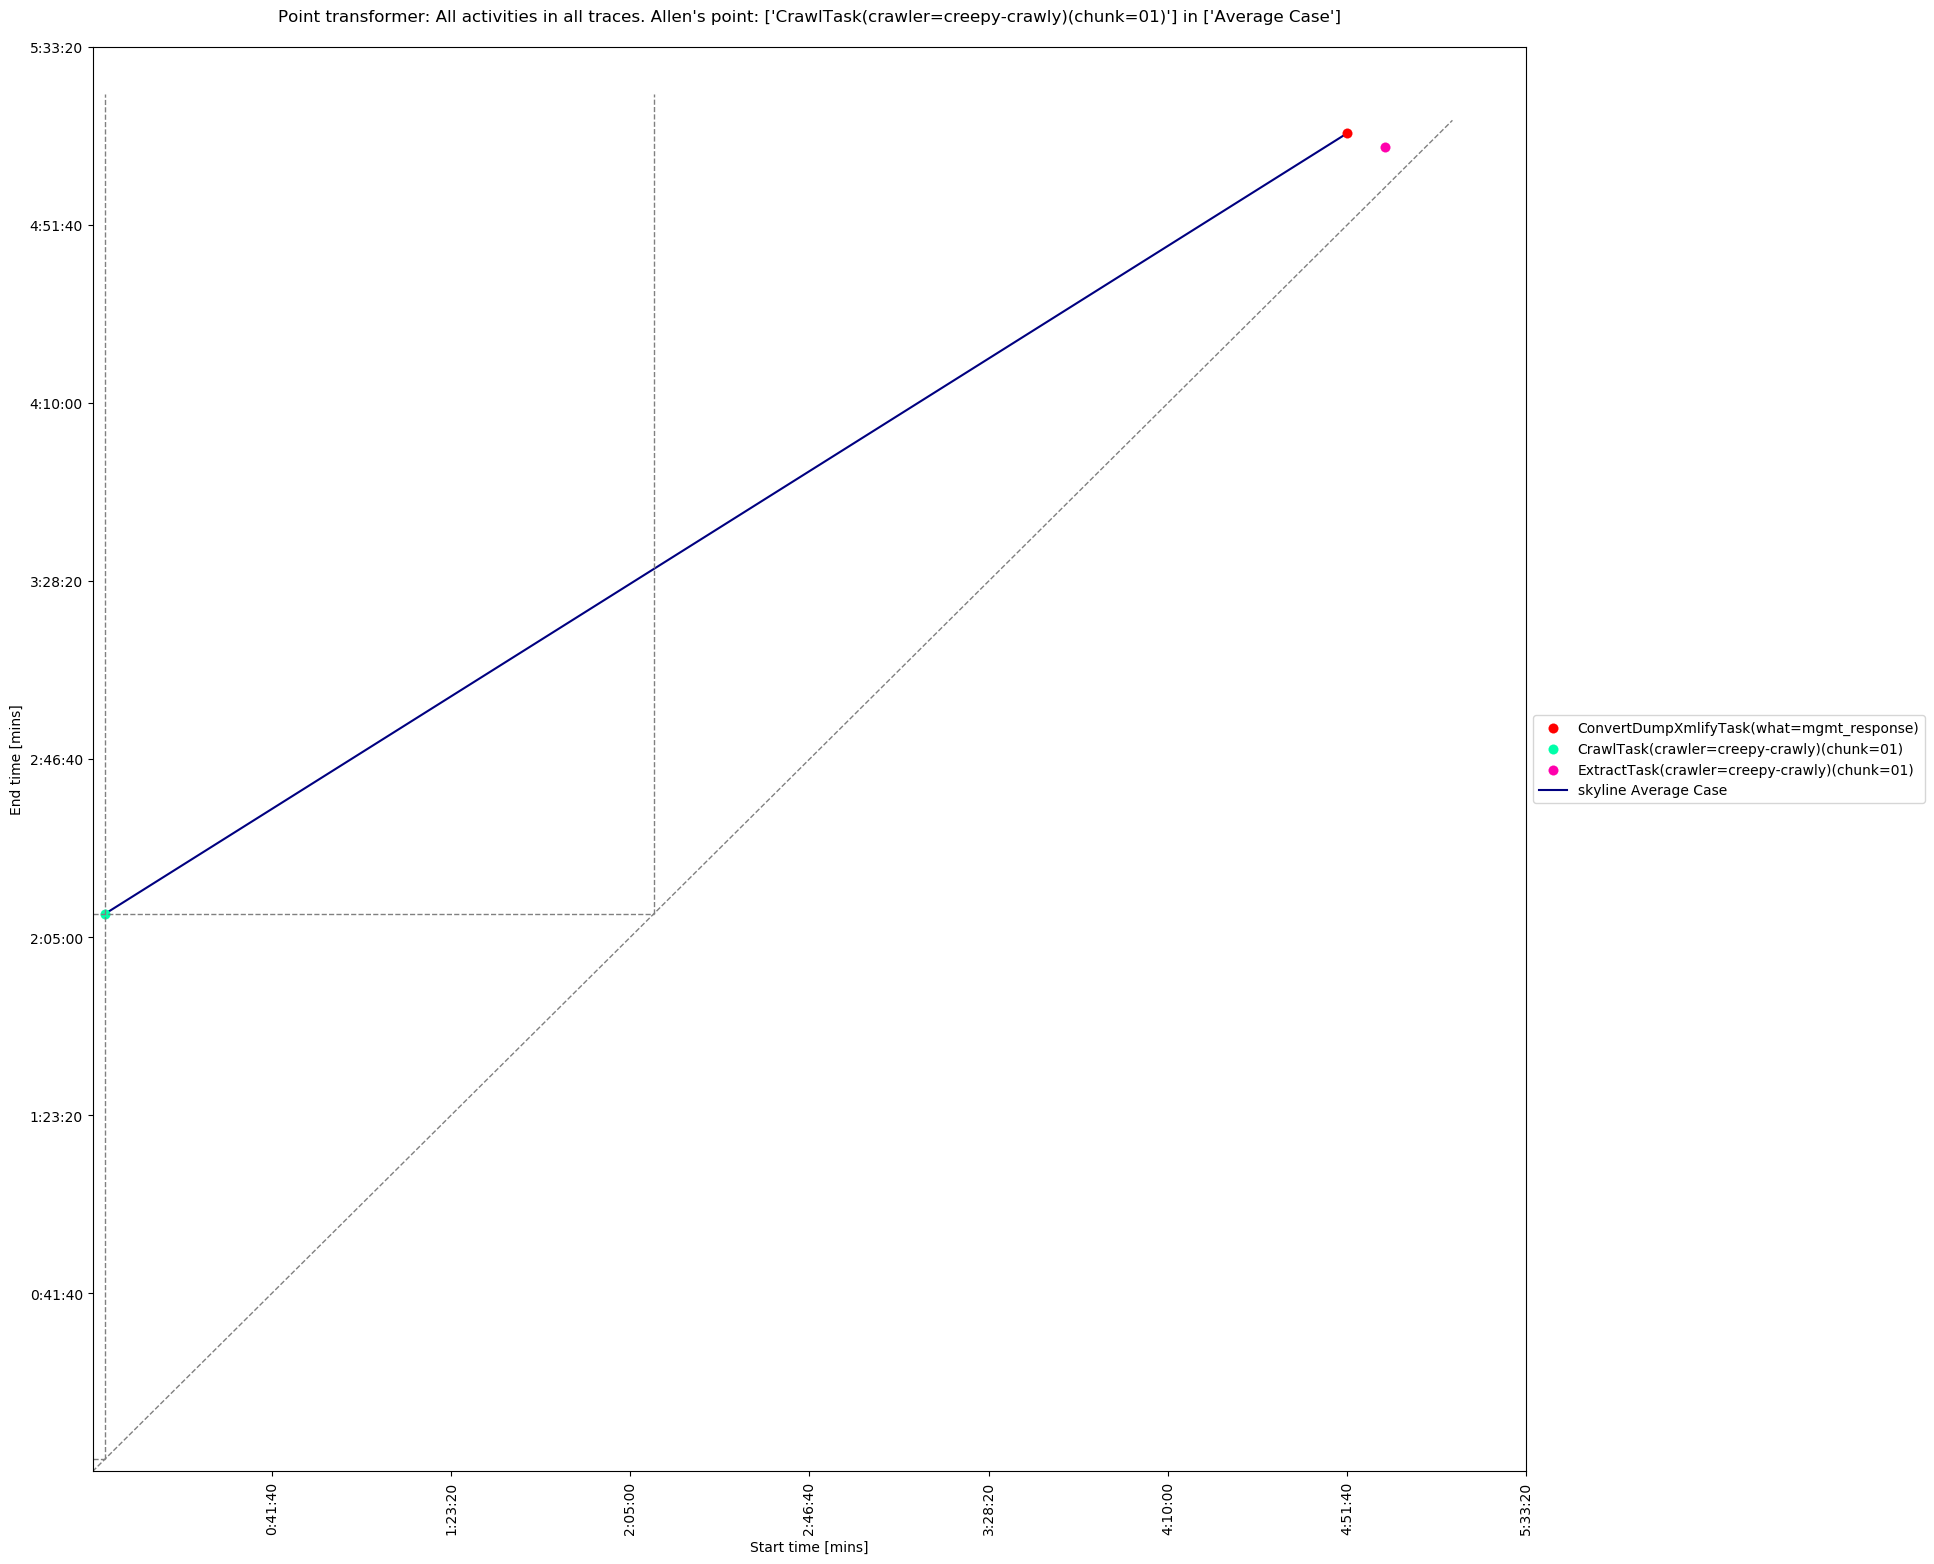

In [44]:
two_cases=['daily.2019-08-07_09-18-01', 'Average Case']
#skyline_plot= pt.plot_traces(snippet=suspects_and_average[suspects_and_average['case'].isin(suspects_intersection)], draw_skylines=1)
skyline_plot= pt.plot_traces(snippet=suspects_and_average[suspects_and_average['case'].isin(two_cases)], draw_skylines=1, show_plot=None)
#skyline_plot= pt.plot_traces(snippet=suspects_and_average[suspects_and_average['case']=='daily.2019-07-01_10-28-01'], draw_skylines=1)

# How to show those anomalies in graph 

In [45]:
reference_point=average_skyline.head(10)
#print(reference_point)
#plot_star_from_point(skyline_plot, average_skyline, suspects_and_average[suspects_and_average['case'].isin(two_cases)])
plot_star_from_point(skyline_plot, suspects_and_average[suspects_and_average['case'].isin(two_cases)],average_trace_activities)


NameError: name 'average_skyline' is not defined

147


array(['daily.2019-09-03_03-44-01.csv', 'Expected Skyline'], dtype=object)

In [ ]:
skyline_pointsi = skyline_points[skyline_points['case']!='anomaly']
print(len(skyline_pointsi))
skyline_pointsi.head(30)

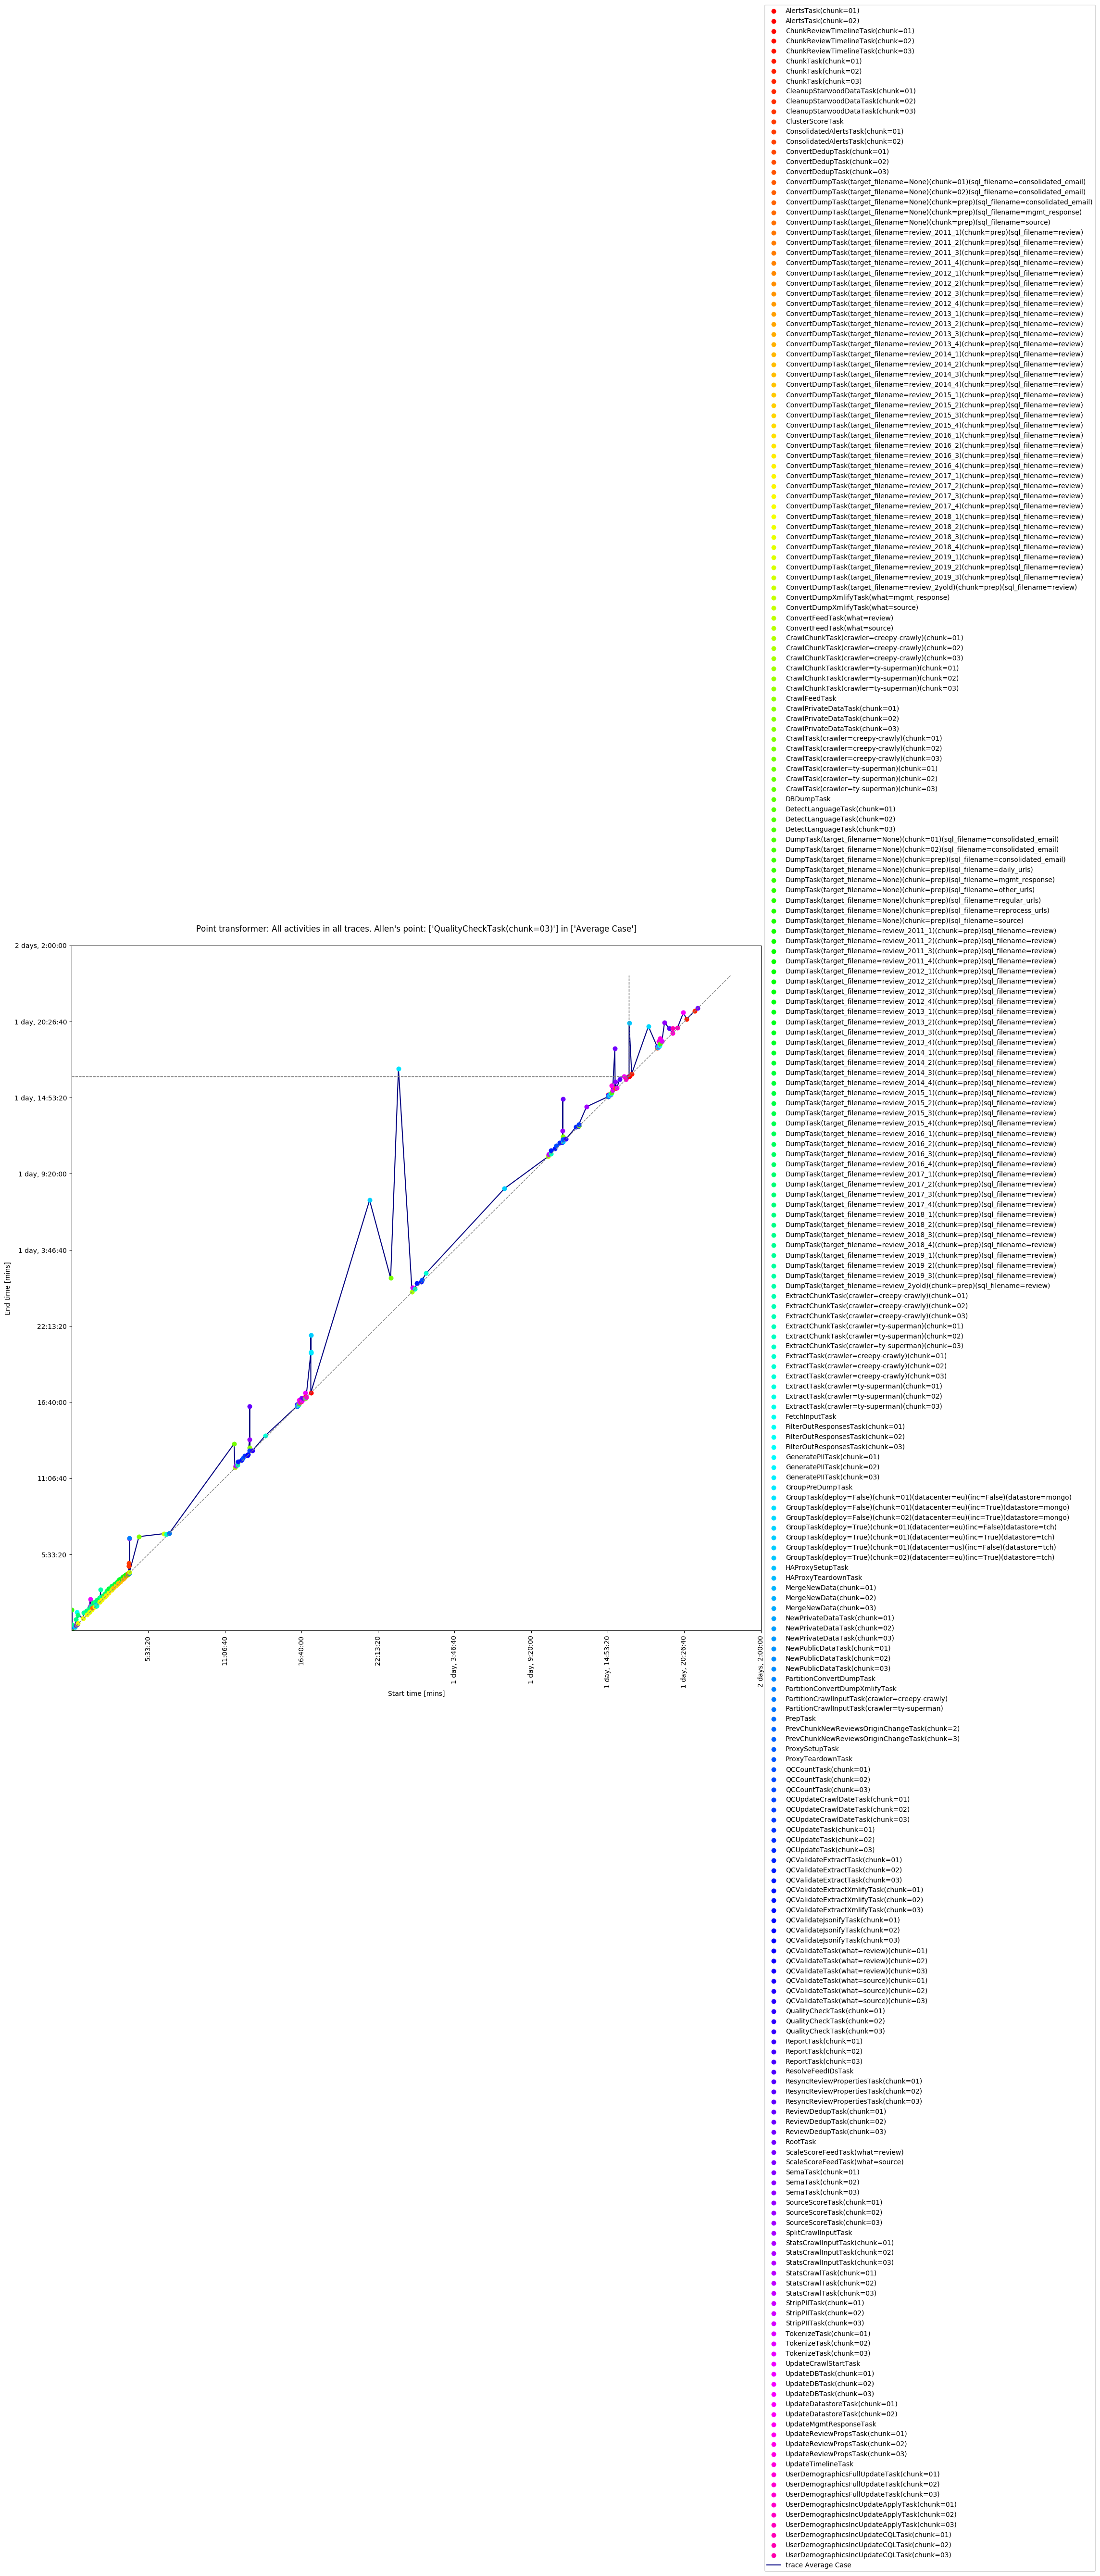

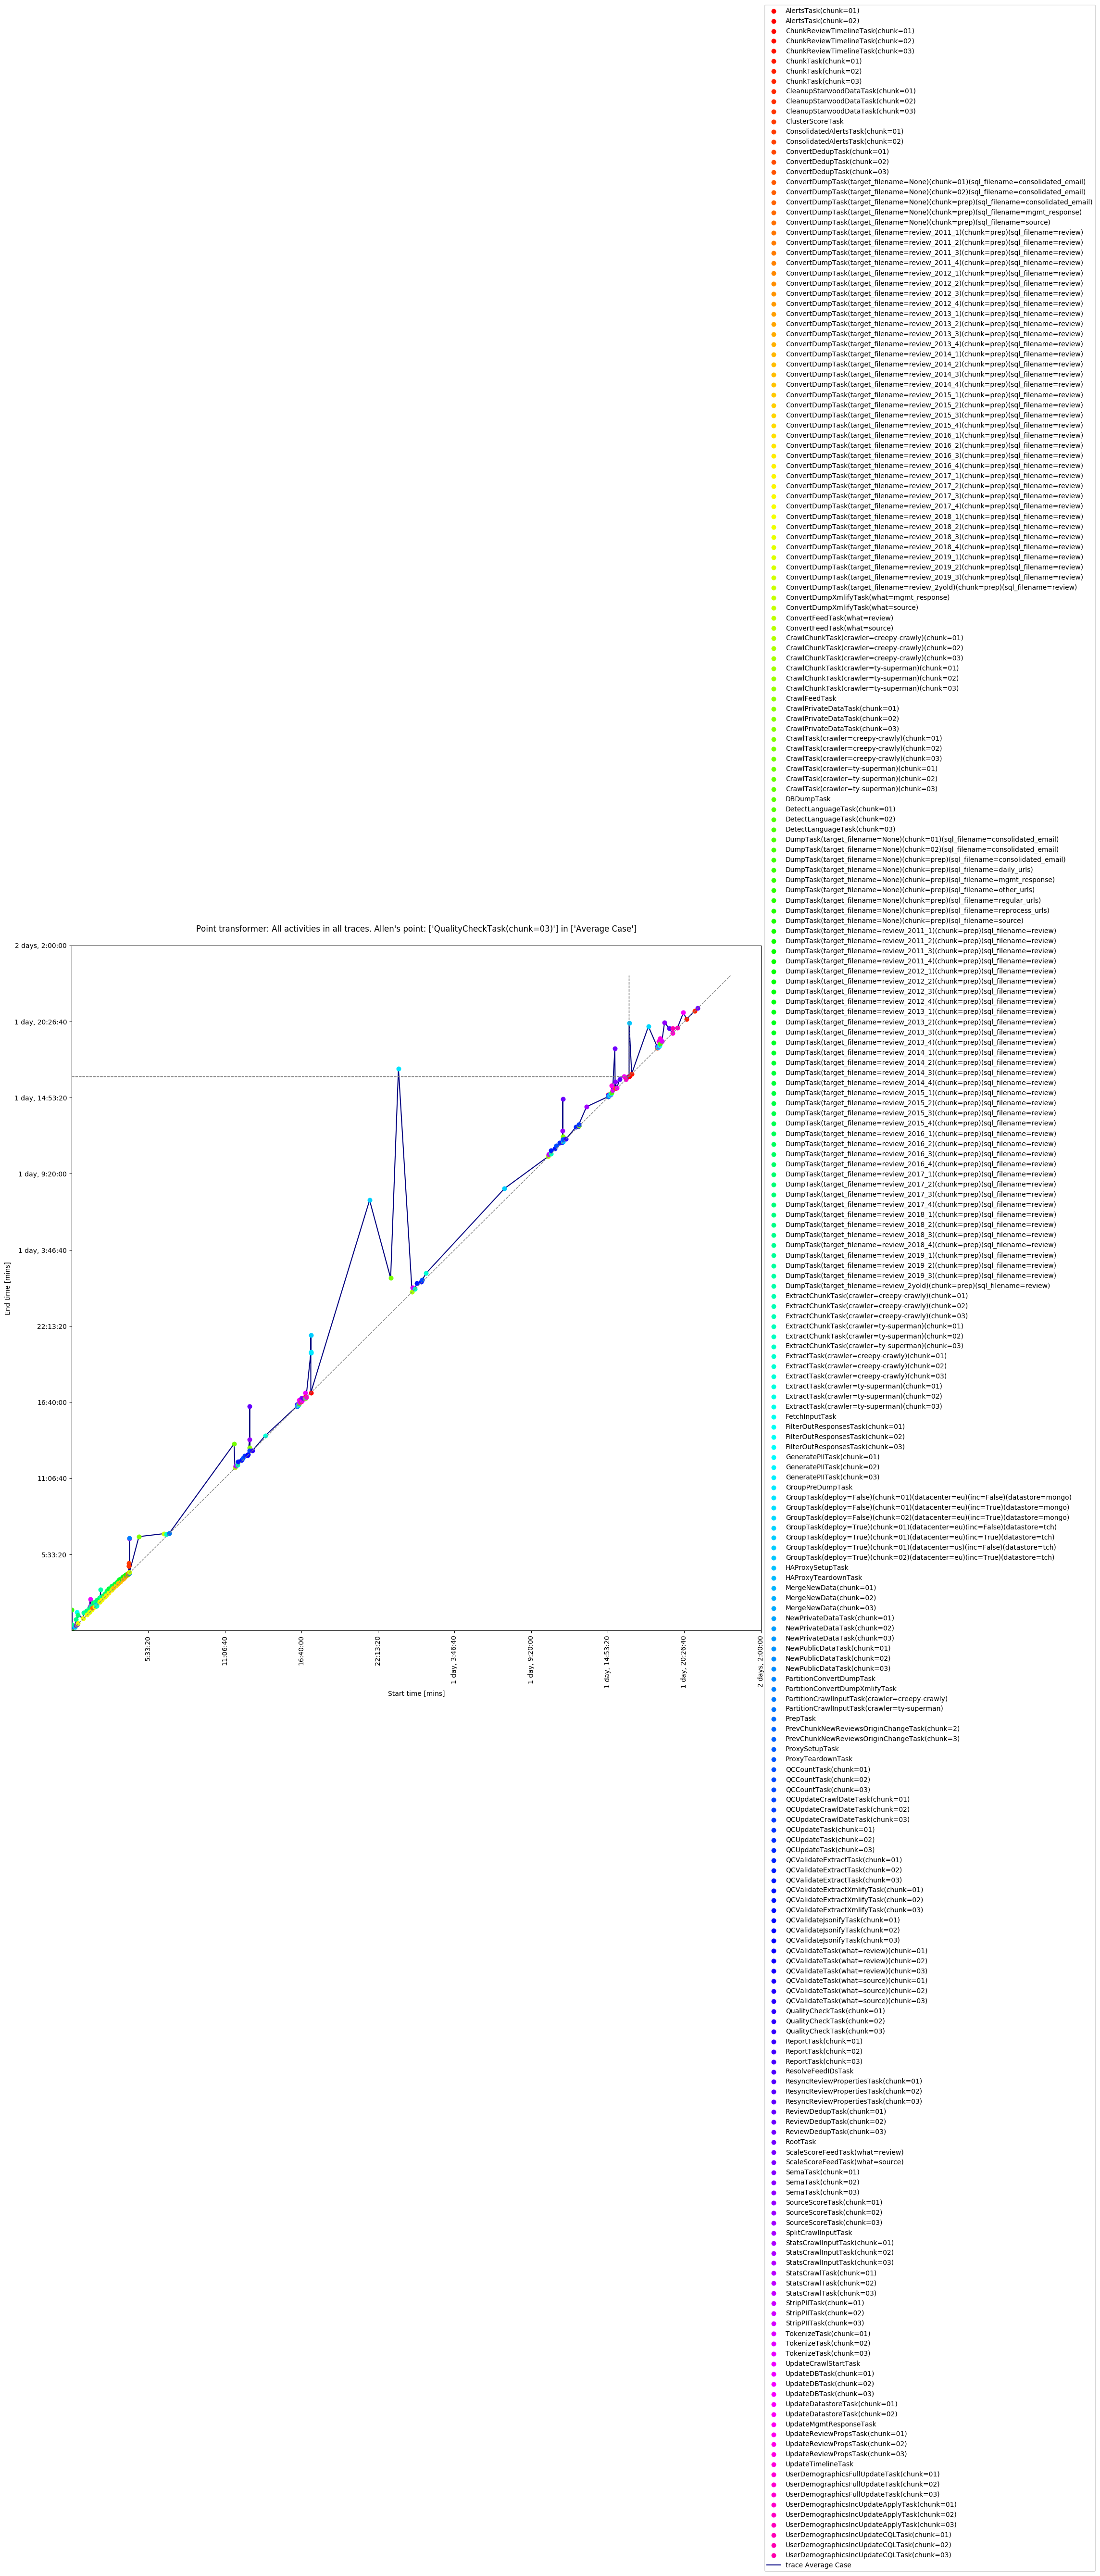

In [49]:
pt.plot_traces(snippet=average_trace_activities, show_plot=None)

In [ ]:
pt.plot_traces(snippet=subset[subset['case'].str.startswith('daily.2019-09-04')], draw_skylines=1)

In [ ]:
for figure in plt.get_fignums():
    plt.close(figure)

In [ ]:
pt.plot_traces(snippet=subset[subset['case']=='daily.2019-09-01_09-29-01.csv'], draw_skylines=1, show_plot=1)


In [48]:
print(len(subset),' length of subset')

skyline_points = pt.get_skyline_points(subset)
expected = skyline_points[skyline_points['case']=='daily.2019-09-04_23-23-01.csv'].loc[:]
print(len(expected))
expected['case'] ='Expected Skyline'

skyline_points = skyline_points.append(expected, ignore_index=True)

#skyline_points = skyline_points.sort_values(by='case', ascending=False)

print(len(skyline_points), 'points on the skylines')
print(skyline_points['case'].unique())
skyline_points.head()

15708  length of subset
67
948 points on the skylines
['daily.2019-09-01_09-29-01.csv' 'daily.2019-09-03_03-44-01.csv'
 'daily.2019-09-04_23-23-01.csv' 'daily.2019-09-06_20-34-01.csv'
 'daily.2019-09-09_01-34-02.csv' 'daily.2019-09-11_05-40-02.csv'
 'daily.2019-09-13_04-11-01.csv' 'daily.2019-09-15_01-41-01.csv'
 'daily.2019-09-16_19-44-01.csv' 'daily.2019-09-18_14-08-01.csv'
 'daily.2019-09-20_12-49-01.csv' 'daily.2019-09-22_07-40-01.csv'
 'daily.2019-09-24_05-05-02.csv' 'Expected Skyline']


num_start  num_end  \
0  0.0        1141.0    
1  0.0        1607.0    
2  0.0        1607.0    
3  0.0        1607.0    
4  0.0        1607.0    

                                                                activity  \
0  CrawlFeedTask                                                           
1  DumpTask(target_filename=None)(chunk=prep)(sql_filename=regular_urls)   
2  DumpTask(target_filename=None)(chunk=prep)(sql_filename=other_urls)     
3  DumpTask(target_filename=None)(chunk=prep)(sql_filename=daily_urls)     
4  ProxySetupTask                                                          

                            case  
0  daily.2019-09-01_09-29-01.csv  
1  daily.2019-09-01_09-29-01.csv  
2  daily.2019-09-01_09-29-01.csv  
3  daily.2019-09-01_09-29-01.csv  
4  daily.2019-09-01_09-29-01.csv

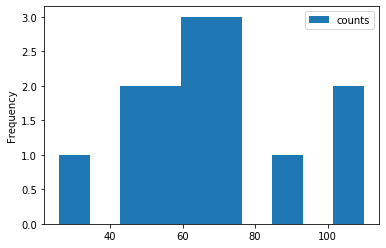

In [49]:
by_case = skyline_points.groupby('case').size().reset_index(name='counts').sort_values(by=['counts'], ascending=False)
by_case.plot.hist()

In [50]:
by_case

case  counts
4   daily.2019-09-06_20-34-01.csv  110   
5   daily.2019-09-09_01-34-02.csv  107   
8   daily.2019-09-15_01-41-01.csv  92    
2   daily.2019-09-03_03-44-01.csv  75    
7   daily.2019-09-13_04-11-01.csv  72    
12  daily.2019-09-22_07-40-01.csv  69    
0   Expected Skyline               67    
3   daily.2019-09-04_23-23-01.csv  67    
10  daily.2019-09-18_14-08-01.csv  61    
9   daily.2019-09-16_19-44-01.csv  55    
1   daily.2019-09-01_09-29-01.csv  53    
11  daily.2019-09-20_12-49-01.csv  49    
6   daily.2019-09-11_05-40-02.csv  45    
13  daily.2019-09-24_05-05-02.csv  26

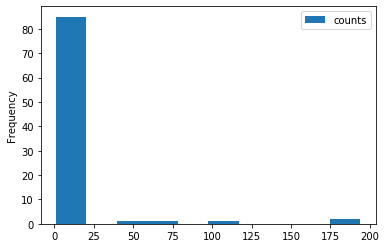

In [51]:
by_activity = skyline_points.groupby('activity').size().reset_index(name='counts').sort_values(by=['counts'], ascending=False)
#print(by_activity)
by_activity.plot.hist()

In [52]:
by_activity.head()

activity  counts
23  CrawlTask(crawler=creepy-crawly)(chunk=03)    194   
21  CrawlTask(crawler=creepy-crawly)(chunk=01)    181   
45  ExtractTask(crawler=creepy-crawly)(chunk=03)  102   
22  CrawlTask(crawler=creepy-crawly)(chunk=02)    64    
43  ExtractTask(crawler=creepy-crawly)(chunk=01)  48

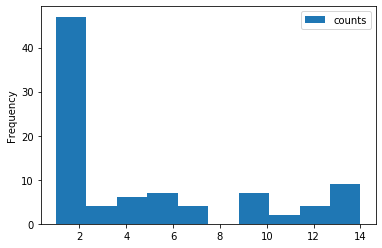

In [53]:
representative = skyline_points[['case','activity']].drop_duplicates()
r_by_activity = representative.groupby('activity').size().reset_index(name='counts').sort_values(by=['counts'], ascending=False)
r_by_activity.plot.hist()

In [54]:
r_by_activity.head()

activity  \
45  ExtractTask(crawler=creepy-crawly)(chunk=03)                             
29  DumpTask(target_filename=None)(chunk=prep)(sql_filename=regular_urls)    
27  DumpTask(target_filename=None)(chunk=prep)(sql_filename=mgmt_response)   
23  CrawlTask(crawler=creepy-crawly)(chunk=03)                               
21  CrawlTask(crawler=creepy-crawly)(chunk=01)                               

    counts  
45  14      
29  14      
27  14      
23  14      
21  14

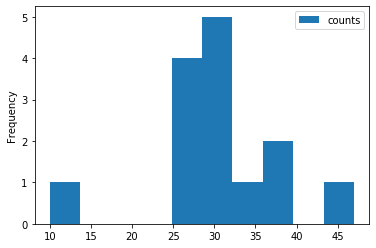

In [55]:
r_by_case = representative.groupby('case').size().reset_index(name='counts').sort_values(by=['counts'], ascending=False)
r_by_case.plot.hist()

In [56]:
r_by_case

case  counts
5   daily.2019-09-09_01-34-02.csv  47    
4   daily.2019-09-06_20-34-01.csv  37    
10  daily.2019-09-18_14-08-01.csv  37    
8   daily.2019-09-15_01-41-01.csv  33    
2   daily.2019-09-03_03-44-01.csv  31    
6   daily.2019-09-11_05-40-02.csv  31    
7   daily.2019-09-13_04-11-01.csv  30    
9   daily.2019-09-16_19-44-01.csv  30    
12  daily.2019-09-22_07-40-01.csv  30    
1   daily.2019-09-01_09-29-01.csv  27    
0   Expected Skyline               26    
3   daily.2019-09-04_23-23-01.csv  26    
11  daily.2019-09-20_12-49-01.csv  25    
13  daily.2019-09-24_05-05-02.csv  10

In [57]:
#print(len(skyline_points), 'points are part of skylines')
unique_sk_activities = skyline_points['activity'].unique().tolist()
#print(len(unique_sk_activities), 'activities in the skyline')
skyline_points.groupby('case').size().reset_index(name='counts').sort_values(by=['counts'], ascending=False)

activities=[]
for i, case in enumerate(skyline_points['case'].unique()):
    acts = skyline_points[skyline_points['case']==case]['activity'].unique().tolist()
    activities.append(acts)
    #print(case, len(acts))

representative = skyline_points[['case','activity']].drop_duplicates()
rep_appereances = representative.groupby(by = ['activity']).size().reset_index(name='counts').sort_values(by=['counts'], ascending=False)
#rep_appereances = skyline_points.groupby(by = ['activity']).size().reset_index(name='counts').sort_values(by=['counts'], ascending=False)

pd.set_option('display.max_rows', None)
print('\n',len(rep_appereances), 'Activities appear in the skyline:')
rep_appereances.head()
#rep_appereances[rep_appereances['counts']<13]

#rep_appereances.groupby(by = ['counts']).size().reset_index(name='activities').sort_values(by=['counts'], ascending=False)


 90 Activities appear in the skyline:


activity  \
45  ExtractTask(crawler=creepy-crawly)(chunk=03)                             
29  DumpTask(target_filename=None)(chunk=prep)(sql_filename=regular_urls)    
27  DumpTask(target_filename=None)(chunk=prep)(sql_filename=mgmt_response)   
23  CrawlTask(crawler=creepy-crawly)(chunk=03)                               
21  CrawlTask(crawler=creepy-crawly)(chunk=01)                               

    counts  
45  14      
29  14      
27  14      
23  14      
21  14

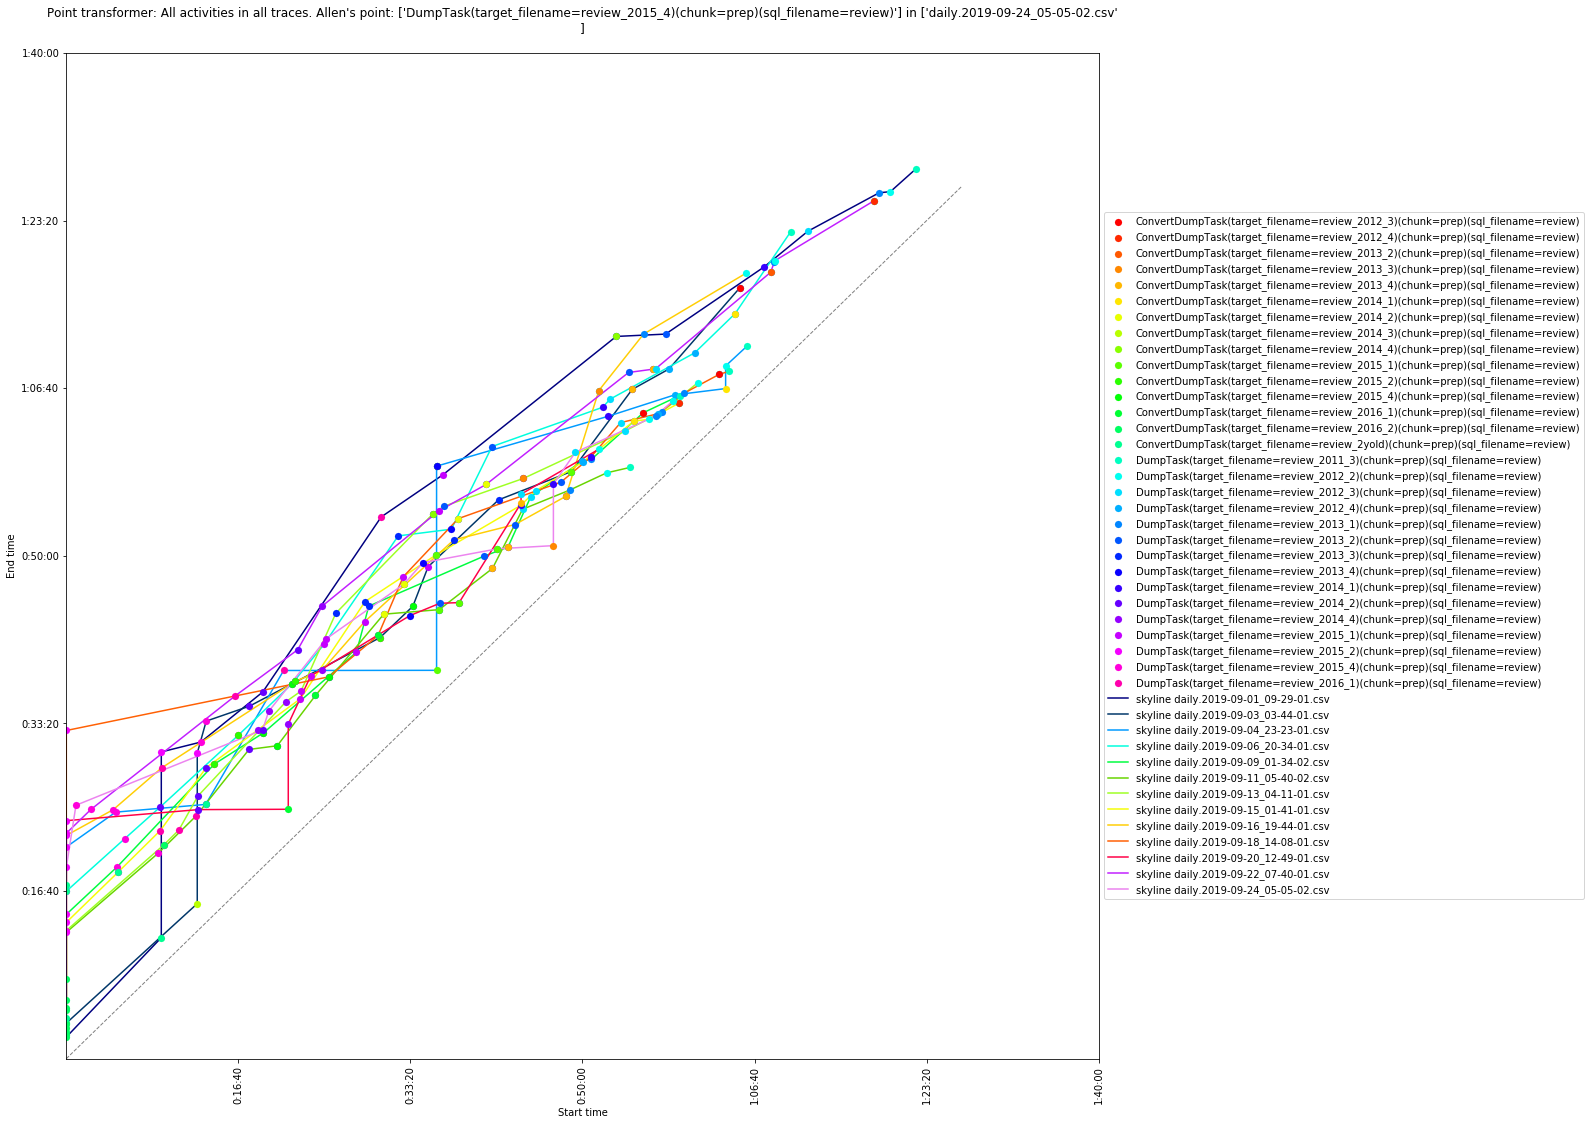

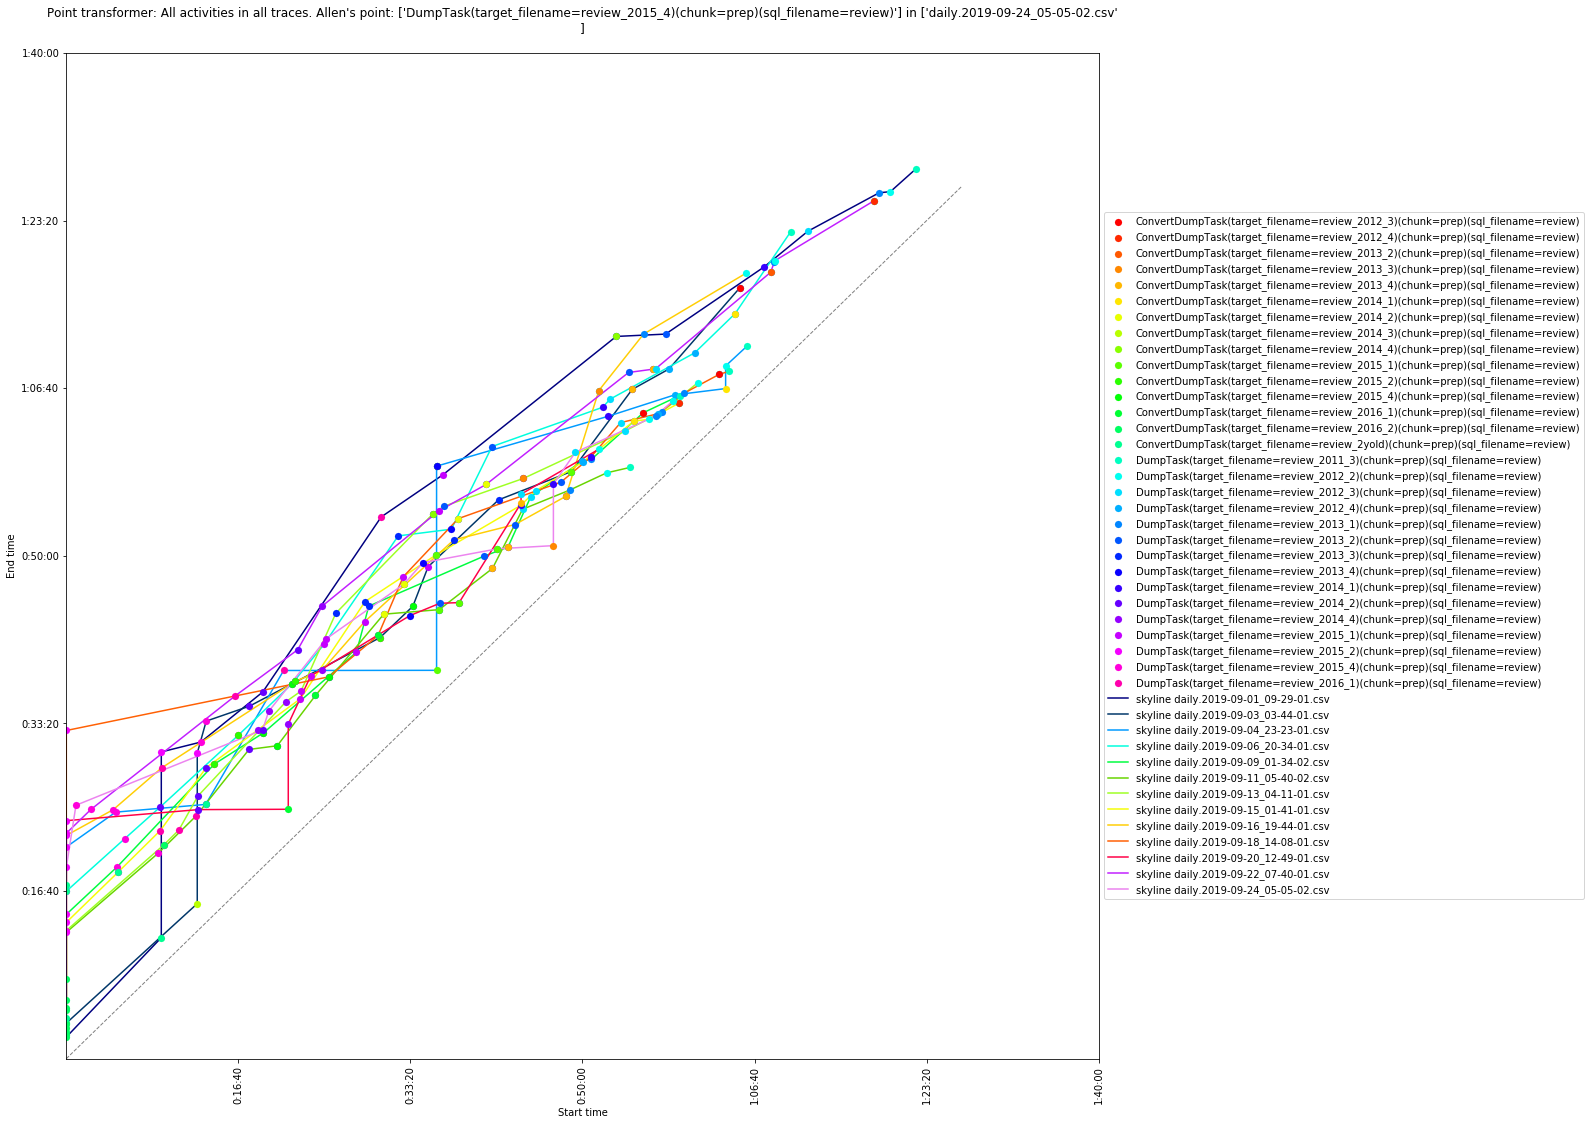

In [58]:
skyline_points = pt.get_skyline_points(all_tasks)
#output_path=LUIGI_LOG_PATH+'graphs/avgActSlideSplit/param_catts_daily.2019-09-All_21_50act_390pts_skylines_allTraces.png'
pt.plot_traces(snippet=skyline_points, draw_skylines=1)

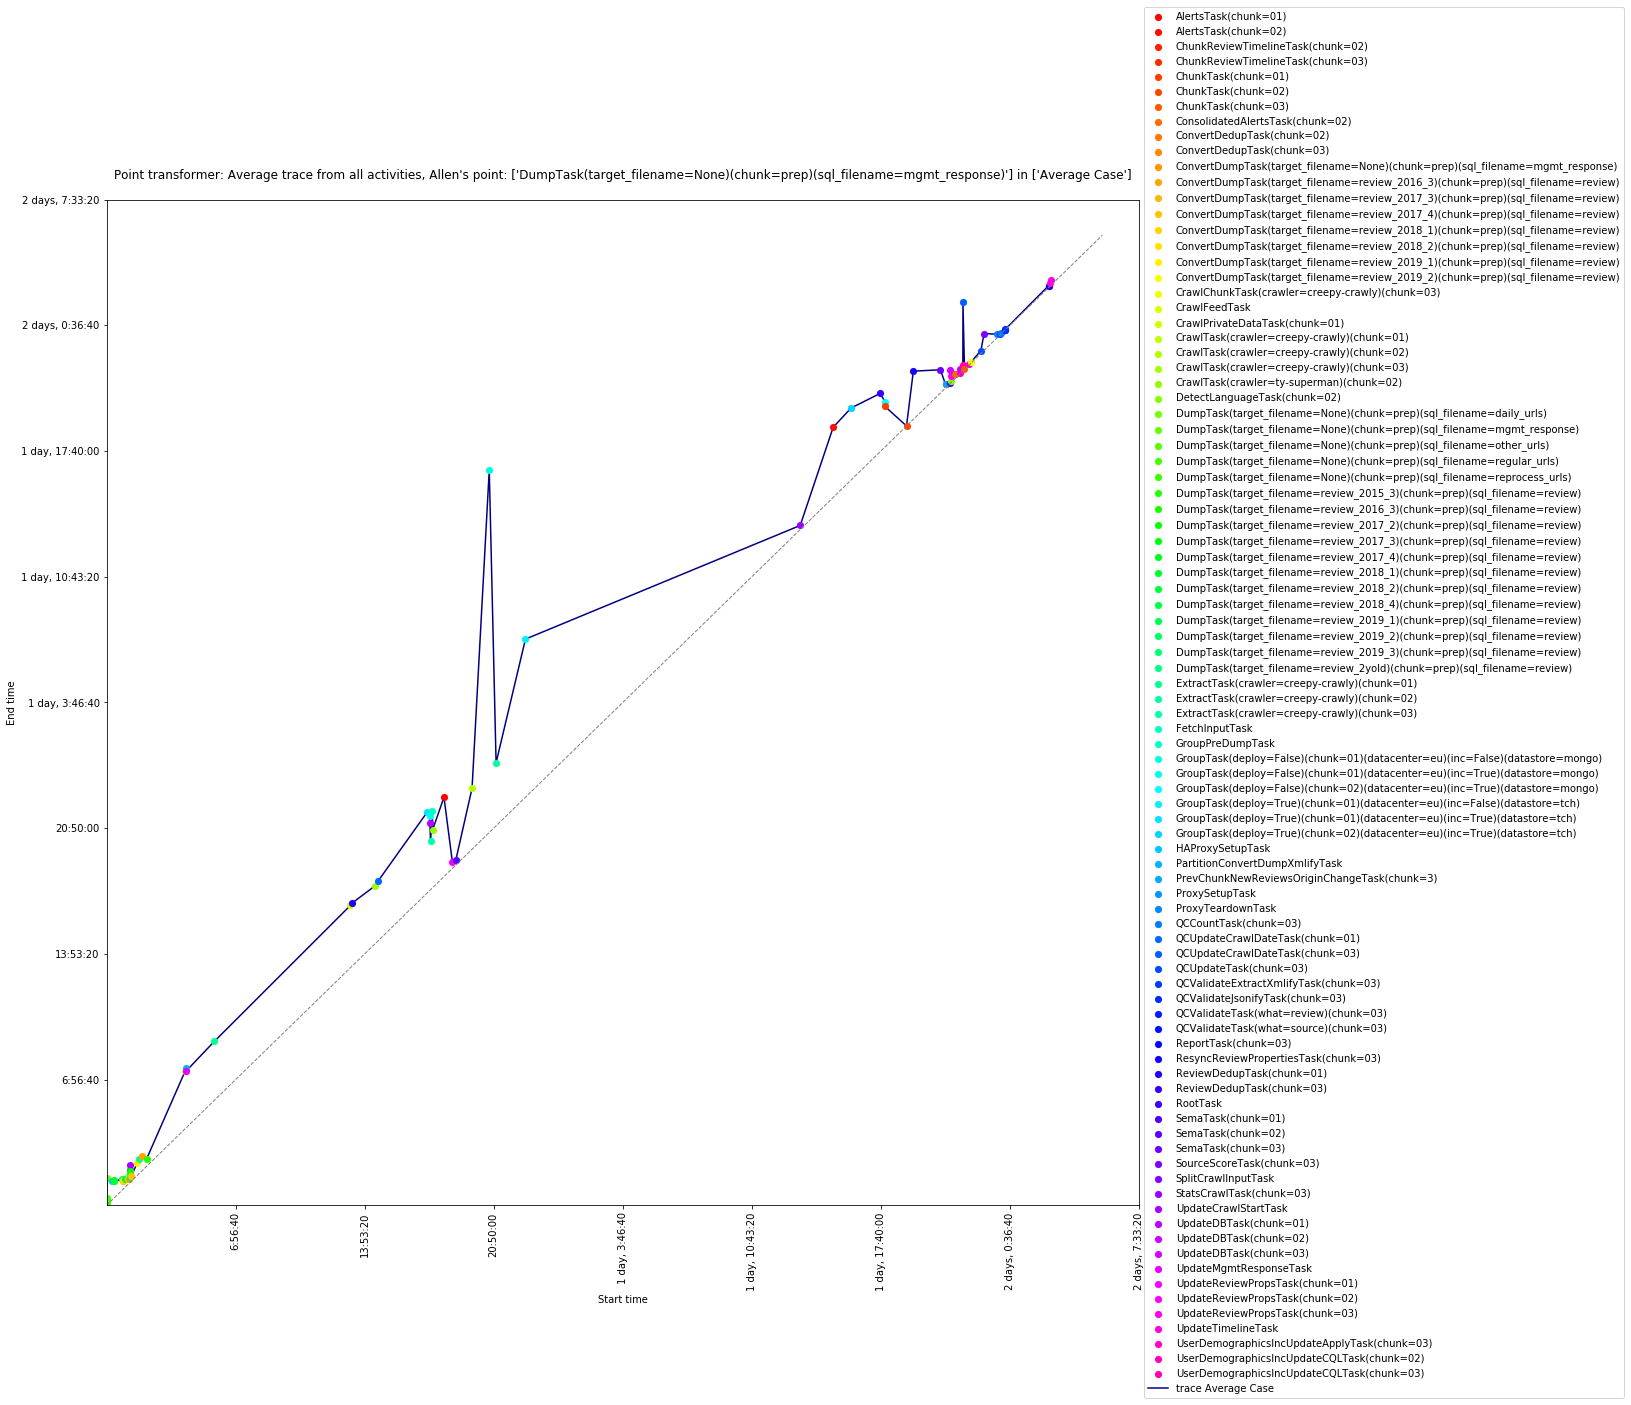

In [15]:
#output_path=LUIGI_LOG_PATH+'graphs/avgActSlideSplit/param_catts_daily.2019-09-All_21_50act_390pts_skylines_averageSkyline.png'
average_points = 
pt.plot_average_trace(snippet=skyline_points) #DEPRECATED: See tuto.ipynb

# Duration plots
## Duration trace

In [8]:
average_trace_activities.head()

activity average_start  \
0                                      CrawlFeedTask      00:00:00   
1  DumpTask(target_filename=None)(chunk=prep)(sql...      00:00:07   
3  DumpTask(target_filename=None)(chunk=prep)(sql...      00:00:12   
2  DumpTask(target_filename=None)(chunk=prep)(sql...      00:00:16   
5  DumpTask(target_filename=None)(chunk=prep)(sql...      00:00:16   

  average_end  num_start      num_end          case   std_num_end  
0    00:19:47   0.076923  1187.307692  Average Case  4.733160e-13  
1    00:22:53   7.846154  1373.692308  Average Case  4.733160e-13  
3    00:01:31  12.076923    91.923077  Average Case  0.000000e+00  
2    00:01:13  16.692308    73.846154  Average Case  1.479113e-14  
5    00:01:02  16.692308    62.307692  Average Case  1.479113e-14

Index(['activity', 'average_start', 'average_end', 'num_start', 'num_end',
       'case', 'std_num_end'],
      dtype='object')
Saving in  /usr/local/trustyou/home/andream/nfs/processmining/minilogs/daily/graphs/allDataAtOnce/pgr_duration_snippet.png


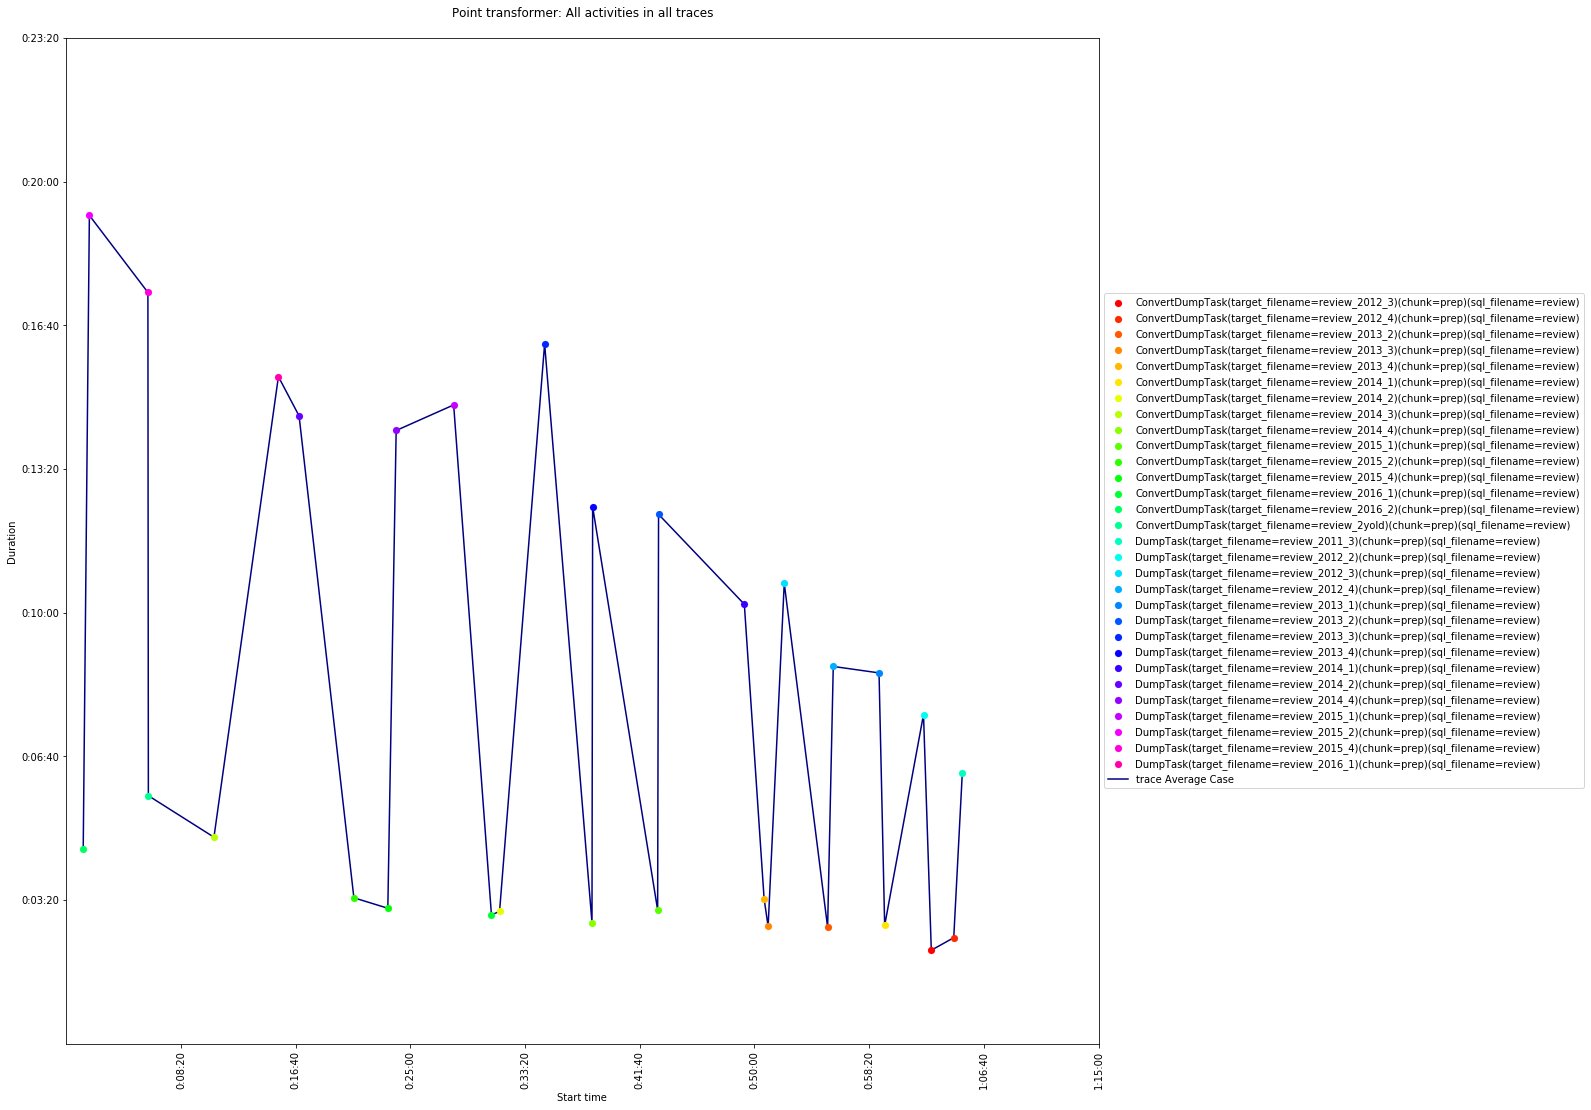

In [26]:
def get_duration(start, end):
    duration = abs(end - start)
    return duration

suspects_and_average = pt.get_data_selection_avgtrace(pt.get_relative_timestamps(subset)).sort_values(by=['num_start'])
print(suspects_and_average.columns)
# Anomaly of number of points in trace
#two_cases=['daily.2019-09-24_05-05-02', 'Average Case']
two_cases=['anomaly', 'Average Case']


w_duration = suspects_and_average[suspects_and_average['case'].isin(two_cases)].loc[:]
#w_duration['duration'] = w_duration.apply(lambda row: str(get_duration(str(row['num_start']),str(row['num_end']))), axis=1)
#w_duration['rel_end']=w_duration['duration']
w_duration['t_duration']= w_duration.apply(lambda row: (get_duration(row['num_start'],row['num_end'])), axis=1)
w_duration['num_end']=w_duration['t_duration']
w_duration = w_duration[['case','activity','num_start', 'num_end']]
    

#skyline_plot= pt.plot_traces(snippet=suspects_and_average[suspects_and_average['case'].isin(two_cases)], show_plot=None)
#output_path=LUIGI_LOG_PATH+'graphs/avgActSlideSplit/param_catts_daily.2019-09-All_61_90act_390pts_point_transformer_duration_averageTrace.png'
skyline_plot= pt.plot_duration_traces(w_duration, show_plot=None)
#some_plot= plot_star_from_point(skyline_plot, suspects_and_average[suspects_and_average['case'].isin(two_cases)], average_trace_activities)



#output_path=LUIGI_LOG_PATH+'graphs/avgActSlideSplit/param_catts_daily.2019-09-All_21_50act_390pts_number_events_trace_anomaly.png'
#some_plot.savefig(output_path,  bbox_inches='tight')

## Duration skyline

In [ ]:
#skyline_plot= pt.plot_duration_traces(w_duration, show_plot=None)
#output_path=LUIGI_LOG_PATH+'graphs/avgActSlideSplit/param_catts_daily.2019-09-All_61_90act_390pts_point_transformer_duration_averageTrace.png'
skyline_sus = pt.get_skyline_points(df=suspects_and_average)
skyline_sus = skyline_sus[skyline_sus['case'].isin(two_cases)].loc[:]
w_duration = skyline_sus[skyline_sus['case'].isin(two_cases)].loc[:]
#w_duration['duration'] = w_duration.apply(lambda row: str(get_duration(str(row['num_start']),str(row['num_end']))), axis=1)
#w_duration['rel_end']=w_duration['duration']
w_duration['t_duration']= w_duration.apply(lambda row: (get_duration(row['num_start'],row['num_end'])), axis=1)
w_duration['num_end']=w_duration['t_duration']
w_duration = w_duration[['case','activity','num_start', 'num_end']]

output_path=LUIGI_LOG_PATH+'graphs/allDataAtOnce/pgr_duration_performance_skyline.png'

#output_path=LUIGI_LOG_PATH+'graphs/avgActSlideSplit/param_catts_daily.2019-09-All_61_90act_390pts_performance_skyline.png'
pt.plot_duration_traces(w_duration, show_plot=None, output_path=output_path)
#pt.plot_traces(snippet=skyline_sus, show_plot=None)
#pt.plot_traces(suspects_and_average[suspects_and_average['case'].isin(two_cases)], show_plot=None)